In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

from dataset_split import *
from evaluation import *

from sklearn.model_selection import ParameterSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, StackDataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchmetrics.classification import (MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score,
                                        MultilabelAccuracy, MultilabelRecall, MultilabelPrecision, MultilabelF1Score)
from torcheval.metrics import MultilabelAUPRC, MulticlassAUPRC
from torchmetrics import MetricCollection

# Loading and preparing the data 

In [2]:
e_coli = pd.read_pickle("e_coli_driams_a_bin3_2000_20000Da.pkl")
k_pneu = pd.read_pickle("k_pneumoniae_driams_a_bin3_2000_20000Da.pkl")
s_aure = pd.read_pickle("s_aureus_driams_a_bin3_2000_20000Da.pkl")

In [188]:
e_coli.describe()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19985,19988,19991,19994,19997,Ciprofloxacin,Ceftriaxone,Cefepime,Piperacillin-Tazobactam,Tobramycin
count,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000,...,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000,4911.000000,4961.000000,4890.000000,4799.000000,4876.000000
mean,1510.606311,1503.370588,1433.426979,1406.003457,1416.175930,1472.162962,1423.608929,1421.219550,1429.695856,1359.886308,...,22.560675,22.889145,22.686109,22.941450,22.129603,0.298514,0.218907,0.171575,0.072932,0.130435
std,2414.081128,2346.449464,2270.697335,2211.874519,2232.816498,2324.723554,2260.533951,2269.843512,2314.797389,2202.570032,...,44.932276,46.484668,46.097244,46.623155,44.012021,0.457653,0.413547,0.377049,0.260052,0.336816
min,6.142857,4.500000,2.142857,4.857143,5.125000,7.000000,7.428571,3.714286,4.571429,5.428571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,405.071429,402.392857,389.107143,406.321429,406.535714,407.214286,388.607143,379.107143,384.500000,372.526786,...,3.000000,2.666667,3.000000,3.000000,3.890346,0.000000,0.000000,0.000000,0.000000,0.000000
50%,928.919643,927.857143,893.714286,882.723214,890.357143,908.857143,878.285714,873.071429,882.955357,850.714286,...,11.333333,11.666667,11.500000,11.500000,12.358065,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1835.535714,1838.964286,1727.937500,1693.678571,1701.446429,1788.428571,1720.669643,1711.468750,1724.678571,1645.321429,...,27.500000,27.000000,28.000000,28.000000,26.467227,1.000000,0.000000,0.000000,0.000000,0.000000
max,80780.000000,74742.857143,74021.125000,72271.857143,73725.428571,75865.571429,73112.142857,73956.285714,79376.000000,74221.500000,...,1463.333333,1605.000000,1521.500000,1586.000000,1543.009615,1.000000,1.000000,1.000000,1.000000,1.000000


In [189]:
k_pneu.describe()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19985,19988,19991,19994,19997,Ciprofloxacin,Ceftriaxone,Cefepime,Meropenem,Tobramycin
count,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,...,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2838.000000,2860.000000,2839.000000,2855.000000,2846.000000
mean,2610.645438,2576.286816,2451.289505,2369.574603,2282.228533,2489.888961,2382.391482,2474.952584,2523.245189,2352.807704,...,20.809550,20.746573,20.718282,20.918526,20.383734,0.180761,0.156993,0.127510,0.021366,0.112087
std,2955.041026,2827.482631,2614.058263,2529.558440,2446.099800,2669.204109,2597.518611,2663.218884,2742.108387,2522.944806,...,35.371797,35.849332,35.828743,35.697947,34.540778,0.384888,0.363858,0.333602,0.144627,0.315529
min,15.000000,12.571429,13.000000,12.571429,7.285714,6.857143,17.142857,11.142857,12.142857,10.571429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,891.000000,893.285714,862.142857,839.857143,817.285714,864.857143,831.857143,850.000000,855.714286,840.857143,...,3.000000,3.000000,3.000000,3.000000,3.647619,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1829.857143,1840.428571,1717.625000,1669.714286,1628.428571,1757.000000,1664.571429,1753.428571,1749.285714,1686.000000,...,11.500000,11.666667,11.500000,11.500000,12.044248,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3301.714286,3279.428571,3148.142857,3065.375000,2894.857143,3210.142857,3055.571429,3173.857143,3236.285714,3017.142857,...,27.000000,26.000000,25.666667,26.500000,25.838095,0.000000,0.000000,0.000000,0.000000,0.000000
max,57856.857143,51892.714286,46026.000000,46961.428571,48059.125000,48508.000000,49561.714286,47862.714286,46929.000000,46029.571429,...,1019.500000,1072.000000,1072.500000,1042.000000,1054.600000,1.000000,1.000000,1.000000,1.000000,1.000000


In [190]:
s_aure.describe()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19985,19988,19991,19994,19997,Oxacillin,Clindamycin,Ceftriaxone,Ciprofloxacin,Fusidic acid
count,3791.000000,3791.000000,3791.000000,3791.000000,3791.000000,3791.000000,3791.000000,3791.000000,3791.000000,3791.000000,...,3791.000000,3791.000000,3791.000000,3791.000000,3791.000000,3790.000000,3575.000000,3640.000000,3757.000000,3766.000000
mean,1156.377336,1145.777499,1106.457705,1129.429429,1181.391312,1195.957856,1156.196108,1091.633427,1077.090025,1069.982699,...,20.770311,21.204959,21.045920,21.314978,21.366017,0.191557,0.145175,0.195604,0.163961,0.067180
std,2100.324359,2034.633189,2066.817533,2128.707498,2144.878547,2121.230664,2123.191805,2057.978914,2059.442521,2083.600724,...,32.913599,33.458460,33.601308,33.547534,32.993834,0.393578,0.352326,0.396720,0.370289,0.250367
min,10.428571,8.714286,8.714286,14.000000,8.500000,14.000000,15.000000,10.000000,13.857143,9.428571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,362.642857,362.776786,354.428571,369.642857,386.428571,387.071429,375.526786,336.857143,341.196429,340.937500,...,2.000000,2.000000,2.000000,2.000000,2.615385,0.000000,0.000000,0.000000,0.000000,0.000000
50%,694.875000,700.571429,664.571429,685.428571,708.250000,738.571429,700.857143,653.625000,639.714286,640.857143,...,10.000000,10.000000,10.000000,10.000000,11.153846,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1327.071429,1318.428571,1269.642857,1290.875000,1346.857143,1378.785714,1338.357143,1237.214286,1230.857143,1230.223214,...,25.583333,26.500000,25.500000,26.000000,26.269585,0.000000,0.000000,0.000000,0.000000,0.000000
max,52956.800000,52032.142857,58146.500000,66106.857143,57094.285714,53663.714286,58881.571429,56590.857143,60031.428571,61728.750000,...,420.333333,452.500000,464.000000,426.000000,449.452174,1.000000,1.000000,1.000000,1.000000,1.000000


In [191]:
e_coli.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19988,19991,19994,19997,species,Ciprofloxacin,Ceftriaxone,Cefepime,Piperacillin-Tazobactam,Tobramycin
0,1541.571429,1596.875000,1651.857143,1691.571429,1336.000000,1617.000000,1367.428571,1963.142857,2402.571429,1695.875000,...,37.5,37.0,38.5,30.371429,Escherichia coli,0.0,0.0,0.0,0.0,0.0
1,189.142857,123.625000,202.285714,221.571429,188.285714,209.142857,220.000000,192.428571,207.428571,133.000000,...,117.0,57.0,67.0,74.742857,Escherichia coli,0.0,0.0,0.0,0.0,0.0
2,219.000000,220.250000,286.000000,160.000000,159.428571,235.428571,166.571429,245.571429,131.857143,173.125000,...,4.0,29.0,0.5,10.695238,Escherichia coli,0.0,1.0,NaN,0.0,0.0
3,938.714286,1037.250000,667.428571,838.428571,739.285714,850.285714,845.714286,789.714286,864.428571,852.500000,...,32.0,32.0,44.5,35.800000,Escherichia coli,0.0,0.0,1.0,NaN,0.0
4,866.000000,810.857143,853.285714,930.714286,835.000000,981.428571,792.571429,945.571429,897.750000,690.428571,...,28.0,6.5,32.0,20.317308,Escherichia coli,1.0,0.0,0.0,0.0,0.0


In [4]:
k_pneu.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19988,19991,19994,19997,species,Ciprofloxacin,Ceftriaxone,Cefepime,Meropenem,Tobramycin
0,2206.625000,2477.142857,2537.571429,2107.142857,2221.285714,2471.428571,2107.714286,2654.714286,2338.125000,2209.571429,...,33.500000,20.5,7.0,30.134615,Klebsiella pneumoniae,0.0,0.0,0.0,0.0,0.0
1,1743.500000,1653.285714,1830.000000,1818.142857,1402.857143,2034.428571,1657.857143,1950.285714,1864.750000,1492.000000,...,56.000000,94.0,65.5,52.038462,Klebsiella pneumoniae,1.0,1.0,1.0,0.0,0.0
2,1921.857143,1706.250000,1882.714286,1918.714286,1817.000000,1937.857143,1618.857143,1853.142857,1900.000000,1585.750000,...,45.000000,39.0,50.0,40.542857,Klebsiella pneumoniae,0.0,0.0,0.0,0.0,0.0
3,2730.285714,2297.714286,2889.857143,2985.428571,3238.428571,2960.875000,2489.142857,2825.000000,2760.428571,2775.571429,...,78.000000,53.0,69.5,79.390000,Klebsiella pneumoniae,0.0,1.0,1.0,0.0,0.0
4,928.857143,1152.000000,952.375000,924.285714,852.714286,848.142857,938.000000,845.000000,763.571429,808.571429,...,18.333333,22.5,40.0,27.105769,Klebsiella pneumoniae,0.0,0.0,0.0,0.0,0.0


In [3]:
s_aure.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19988,19991,19994,19997,species,Oxacillin,Clindamycin,Ceftriaxone,Ciprofloxacin,Fusidic acid
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,50.0,35.5,20.5,27.342857,Staphylococcus aureus,0.0,0.0,0.0,0.0,1.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,31.0,30.0,40.5,34.695238,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,11.5,2.5,30.5,11.288462,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,24.5,15.5,8.0,20.057143,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,24.5,25.5,32.0,24.990476,Staphylococcus aureus,1.0,0.0,1.0,1.0,0.0


In [4]:
# Visualizing a sample
sample = e_coli.iloc[0,:6000]

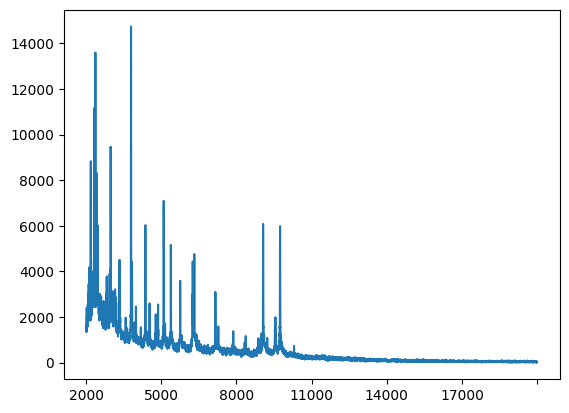

In [39]:
%matplotlib inline
e_coli.iloc[0,:6000].plot.line()
plt.show()

In [3]:
# Concatenate e_coli, k_pneu, and s_aure dfs, reset the index 
combined = pd.concat([e_coli, k_pneu, s_aure], ignore_index=True).reset_index(drop=True)

In [6]:
combined.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,species,Ciprofloxacin,Ceftriaxone,Cefepime,Piperacillin-Tazobactam,Tobramycin,Meropenem,Oxacillin,Clindamycin,Fusidic acid
0,1541.571429,1596.875000,1651.857143,1691.571429,1336.000000,1617.000000,1367.428571,1963.142857,2402.571429,1695.875000,...,Escherichia coli,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,189.142857,123.625000,202.285714,221.571429,188.285714,209.142857,220.000000,192.428571,207.428571,133.000000,...,Escherichia coli,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,219.000000,220.250000,286.000000,160.000000,159.428571,235.428571,166.571429,245.571429,131.857143,173.125000,...,Escherichia coli,0.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,938.714286,1037.250000,667.428571,838.428571,739.285714,850.285714,845.714286,789.714286,864.428571,852.500000,...,Escherichia coli,0.0,0.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN
4,866.000000,810.857143,853.285714,930.714286,835.000000,981.428571,792.571429,945.571429,897.750000,690.428571,...,Escherichia coli,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [7]:
combined.shape

(11650, 6010)

In [4]:
# Rename for easier use
combined = combined.rename(columns={'Piperacillin-Tazobactam': 'Piperacillin'})

In [5]:
# Drop antibiotics that are not of interest within this project
columns_to_drop = ['Meropenem', 'Oxacillin', 'Clindamycin', 'Fusidic acid']
filtered = combined.drop(columns=columns_to_drop)

In [125]:
filtered.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19988,19991,19994,19997,species,Ciprofloxacin,Ceftriaxone,Cefepime,Piperacillin,Tobramycin
0,1541.571429,1596.875000,1651.857143,1691.571429,1336.000000,1617.000000,1367.428571,1963.142857,2402.571429,1695.875000,...,37.5,37.0,38.5,30.371429,Escherichia coli,0.0,0.0,0.0,0.0,0.0
1,189.142857,123.625000,202.285714,221.571429,188.285714,209.142857,220.000000,192.428571,207.428571,133.000000,...,117.0,57.0,67.0,74.742857,Escherichia coli,0.0,0.0,0.0,0.0,0.0
2,219.000000,220.250000,286.000000,160.000000,159.428571,235.428571,166.571429,245.571429,131.857143,173.125000,...,4.0,29.0,0.5,10.695238,Escherichia coli,0.0,1.0,NaN,0.0,0.0
3,938.714286,1037.250000,667.428571,838.428571,739.285714,850.285714,845.714286,789.714286,864.428571,852.500000,...,32.0,32.0,44.5,35.800000,Escherichia coli,0.0,0.0,1.0,NaN,0.0
4,866.000000,810.857143,853.285714,930.714286,835.000000,981.428571,792.571429,945.571429,897.750000,690.428571,...,28.0,6.5,32.0,20.317308,Escherichia coli,1.0,0.0,0.0,0.0,0.0


In [126]:
filtered.shape

(11650, 6006)

# Missing values

In [127]:
# Calculate and show the count and percentage of missing values
nan_counts = filtered.isna().sum()
nan_percentage = (filtered.isna().sum() / len(filtered)) * 100

missing_data = pd.DataFrame({
    'Missing Values': nan_counts,
    'Percentage': nan_percentage
})

missing_data[missing_data['Missing Values'] > 0]

,Missing Values,Percentage
Ciprofloxacin,144,1.236052
Ceftriaxone,189,1.622318
Cefepime,3921,33.656652
Piperacillin,6851,58.806867
Tobramycin,3928,33.716738


# Label encoding

In [10]:
filtered['species'].value_counts()

species
Escherichia coli         4990
Staphylococcus aureus    3791
Klebsiella pneumoniae    2869
Name: count, dtype: int64

In [6]:
# Encode categorical 'species' values into numerical labels
le = LabelEncoder()
filtered['species'] = le.fit_transform(filtered['species'])

In [12]:
filtered['species'].value_counts()

species
0    4990
2    3791
1    2869
Name: count, dtype: int64

# Dataset split

In [7]:
# Defining the features and antibiotic columns 
# species are within features and will be split later
features = filtered.iloc[:, :-5]
antibiotic_columns = filtered.columns[-5:]

In [8]:
features.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,species
0,1541.571429,1596.875000,1651.857143,1691.571429,1336.000000,1617.000000,1367.428571,1963.142857,2402.571429,1695.875000,...,24.000000,51.5,29.5,4.5,26.333333,37.5,37.0,38.5,30.371429,0
1,189.142857,123.625000,202.285714,221.571429,188.285714,209.142857,220.000000,192.428571,207.428571,133.000000,...,79.666667,93.0,111.0,83.0,61.666667,117.0,57.0,67.0,74.742857,0
2,219.000000,220.250000,286.000000,160.000000,159.428571,235.428571,166.571429,245.571429,131.857143,173.125000,...,9.000000,11.5,13.0,3.0,9.666667,4.0,29.0,0.5,10.695238,0
3,938.714286,1037.250000,667.428571,838.428571,739.285714,850.285714,845.714286,789.714286,864.428571,852.500000,...,57.666667,36.0,35.5,22.0,48.666667,32.0,32.0,44.5,35.800000,0
4,866.000000,810.857143,853.285714,930.714286,835.000000,981.428571,792.571429,945.571429,897.750000,690.428571,...,32.000000,30.0,30.5,12.0,20.000000,28.0,6.5,32.0,20.317308,0


In [8]:
split_results = split_data(filtered, antibiotic_columns)

In [125]:
split_results['Ciprofloxacin']['X_train']

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,species
4417,1544.142857,1501.000000,1500.000000,1542.285714,1485.571429,1664.428571,1676.750000,1743.428571,1537.285714,1426.000000,...,15.0,26.5,25.500000,14.000000,15.500000,7.000000,25.500000,12.666667,14.384615,0
1109,29.000000,44.571429,17.714286,71.142857,82.000000,24.285714,47.285714,26.857143,26.000000,18.571429,...,0.0,8.0,9.000000,5.000000,6.500000,10.000000,1.500000,3.000000,7.784314,0
1757,977.571429,957.125000,939.428571,849.142857,842.571429,881.142857,955.857143,986.000000,996.714286,980.625000,...,56.0,46.5,41.666667,40.500000,37.500000,52.500000,66.000000,44.500000,56.221154,0
7629,5051.857143,4213.250000,3658.428571,3348.428571,3295.000000,3922.714286,3748.714286,3903.000000,3698.000000,3876.714286,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028188,1
9068,405.714286,385.375000,356.714286,419.000000,344.714286,383.428571,354.571429,370.428571,332.428571,319.142857,...,10.0,25.0,5.000000,3.000000,4.333333,7.500000,6.000000,17.500000,7.676190,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,1910.000000,2056.000000,1831.857143,1797.142857,1725.285714,1948.285714,1836.285714,1710.285714,1565.000000,1795.250000,...,256.5,311.5,302.500000,291.666667,249.000000,346.500000,255.000000,249.666667,278.625000,0
4824,5851.571429,5874.714286,5266.857143,4835.250000,4794.714286,4933.857143,5526.571429,5228.714286,4946.714286,5013.285714,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047043,0
660,510.714286,517.625000,505.142857,518.428571,462.285714,508.285714,564.571429,496.285714,464.000000,453.571429,...,2.5,8.5,11.000000,4.500000,10.000000,10.000000,8.333333,22.000000,11.369369,0
2620,2268.285714,2064.000000,1998.875000,2064.571429,2134.142857,2182.714286,2251.142857,2104.428571,2022.142857,2043.857143,...,46.0,30.0,46.000000,25.500000,40.500000,21.000000,40.000000,46.000000,39.250000,0


In [9]:
# for combined task
antibiotic_columns = ['Ciprofloxacin', 'Ceftriaxone', 'Cefepime', 'Piperacillin', 'Tobramycin']
combined_df = process_and_combine_data(split_results, antibiotic_columns)

In [10]:
combined_df

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19991,19994,19997,split,y_species,Ciprofloxacin,Ceftriaxone,Cefepime,Piperacillin,Tobramycin
0,1544.142857,1501.000000,1500.000000,1542.285714,1485.571429,1664.428571,1676.750000,1743.428571,1537.285714,1426.000000,...,25.5,12.666667,14.384615,0,0,0.0,NaN,NaN,NaN,NaN
1,29.000000,44.571429,17.714286,71.142857,82.000000,24.285714,47.285714,26.857143,26.000000,18.571429,...,1.5,3.000000,7.784314,0,0,0.0,NaN,NaN,NaN,NaN
2,977.571429,957.125000,939.428571,849.142857,842.571429,881.142857,955.857143,986.000000,996.714286,980.625000,...,66.0,44.500000,56.221154,0,0,0.0,NaN,NaN,NaN,NaN
3,5051.857143,4213.250000,3658.428571,3348.428571,3295.000000,3922.714286,3748.714286,3903.000000,3698.000000,3876.714286,...,0.0,0.000000,0.028188,0,1,0.0,NaN,NaN,NaN,NaN
4,405.714286,385.375000,356.714286,419.000000,344.714286,383.428571,354.571429,370.428571,332.428571,319.142857,...,6.0,17.500000,7.676190,0,2,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43212,610.285714,546.714286,489.250000,422.857143,350.142857,476.428571,452.714286,458.714286,455.000000,511.875000,...,0.0,0.000000,0.001346,2,1,NaN,NaN,NaN,NaN,0.0
43213,578.428571,505.428571,548.571429,625.000000,548.250000,554.571429,551.428571,521.000000,630.571429,563.428571,...,0.0,0.000000,0.022667,2,0,NaN,NaN,NaN,NaN,0.0
43214,3082.571429,3350.125000,3681.142857,3558.000000,3108.857143,3611.857143,3183.571429,3406.571429,3542.285714,3309.750000,...,36.0,40.000000,37.096154,2,1,NaN,NaN,NaN,NaN,1.0
43215,1197.571429,1095.714286,1026.428571,886.571429,1066.857143,1131.875000,1008.428571,1143.714286,1043.714286,913.857143,...,11.5,9.333333,11.086538,2,0,NaN,NaN,NaN,NaN,0.0


In [128]:
combined_df['Tobramycin'].value_counts()

Tobramycin
0.0    6767
1.0     955
Name: count, dtype: int64

In [129]:
filtered['Tobramycin'].value_counts()

Tobramycin
0.0    6767
1.0     955
Name: count, dtype: int64

Our classification task is two-fold:

first classifier is aimed to predict the species of the species
second classifier aims to predict resistance of the bacteria
I am going to have three models: Logistic Regression (LR), Random Forest (RF), and neural network (NN). For LR and RF, separate classifiers will be built for the tasks whereas for the NN I will create one model to perform both tasks.

For species prediction task, I will combine all train data for all antibiotics.

# First task: classification of the species

In [10]:
# Store all the features and outcomes together
X_train_species_comb = []
y_train_species_comb = []

for antibiotic, data in split_results.items():
    X_train_species = data['X_train'].copy()
    y_train_species = X_train_species.pop('species')
    X_train_species_comb.append(X_train_species) 
    y_train_species_comb.append(y_train_species) 

X_train_species_comb = pd.concat(X_train_species_comb)
y_train_species_comb = pd.concat(y_train_species_comb)

In [11]:
# Reset the index of the concatenated features df 
X_train_species_comb.reset_index(drop=True, inplace=True)
y_train_species_comb.reset_index(drop=True, inplace=True)

In [12]:
X_valid_species_comb = []
y_valid_species_comb = []

for antibiotic, data in split_results.items():
    X_valid_species = data['X_valid'].copy()
    y_valid_species = X_valid_species.pop('species')
    X_valid_species_comb.append(X_valid_species)
    y_valid_species_comb.append(y_valid_species)

X_valid_species_comb = pd.concat(X_valid_species_comb)
y_valid_species_comb = pd.concat(y_valid_species_comb)

In [13]:
X_valid_species_comb.reset_index(drop=True, inplace=True)
X_valid_species_comb.reset_index(drop=True, inplace=True)

In [14]:
X_test_species_comb = []
y_test_species_comb = []

for antibiotic, data in split_results.items():
    X_test_species = data['X_test'].copy()
    y_test_species = X_test_species.pop('species')
    X_test_species_comb.append(X_test_species)
    y_test_species_comb.append(y_test_species)

X_test_species_comb = pd.concat(X_test_species_comb)
y_test_species_comb = pd.concat(y_test_species_comb)

In [15]:
X_test_species_comb.reset_index(drop=True, inplace=True)
y_test_species_comb.reset_index(drop=True, inplace=True)

In [81]:
X_test_species_comb

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19970,19973,19976,19979,19982,19985,19988,19991,19994,19997
0,866.428571,988.142857,858.571429,830.000000,814.714286,854.500000,882.428571,826.714286,783.142857,787.428571,...,116.333333,112.500000,108.000000,117.000000,112.333333,84.500000,114.500000,96.666667,107.000000,112.740385
1,2712.000000,2687.285714,3165.000000,3483.428571,3363.142857,3537.857143,2714.750000,3038.428571,3191.142857,3176.571429,...,10.500000,6.500000,13.500000,12.666667,9.000000,14.000000,7.500000,12.000000,16.500000,9.923810
2,348.571429,364.857143,412.571429,507.000000,380.875000,460.714286,410.000000,470.857143,444.285714,306.714286,...,13.500000,8.333333,15.000000,18.500000,16.500000,5.000000,11.000000,3.500000,10.000000,9.200000
3,899.375000,1083.714286,955.714286,781.714286,743.142857,869.000000,679.000000,853.142857,872.750000,759.857143,...,62.500000,25.333333,25.500000,14.500000,30.000000,38.333333,19.000000,35.500000,14.500000,27.461538
4,1539.714286,1615.142857,1311.000000,1269.428571,1202.125000,1385.428571,1288.571429,1257.714286,1238.142857,1300.714286,...,3.000000,2.500000,3.000000,4.000000,4.666667,3.500000,7.500000,2.000000,1.000000,3.586538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6480,610.285714,546.714286,489.250000,422.857143,350.142857,476.428571,452.714286,458.714286,455.000000,511.875000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001346
6481,578.428571,505.428571,548.571429,625.000000,548.250000,554.571429,551.428571,521.000000,630.571429,563.428571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022667
6482,3082.571429,3350.125000,3681.142857,3558.000000,3108.857143,3611.857143,3183.571429,3406.571429,3542.285714,3309.750000,...,23.000000,33.000000,33.333333,41.000000,21.500000,26.500000,42.666667,36.000000,40.000000,37.096154
6483,1197.571429,1095.714286,1026.428571,886.571429,1066.857143,1131.875000,1008.428571,1143.714286,1043.714286,913.857143,...,12.666667,16.000000,8.000000,15.000000,6.000000,10.000000,12.000000,11.500000,9.333333,11.086538


## Exploratory data analysis

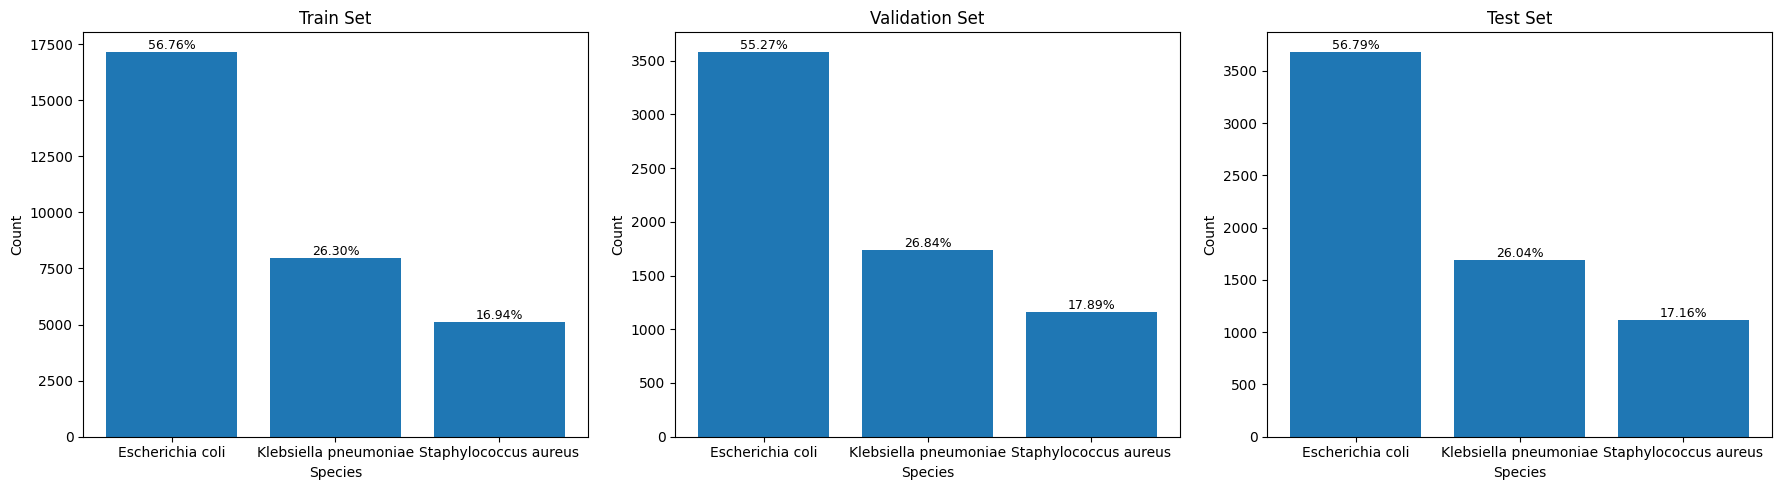

In [15]:
# Dictionary mapping numerical labels to corresponding species names
species_mapping = {0: 'Escherichia coli', 1: 'Klebsiella pneumoniae', 2: 'Staphylococcus aureus'}

datasets = {'Train': y_train_species_comb,
            'Validation': y_valid_species_comb,
            'Test': y_test_species_comb}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))  

# Iterate over datasets and their labels
for i, (label, data) in enumerate(datasets.items()):
    # Calculate counts and proportions of each species label in the current dataset
    counts = data.value_counts().sort_index()
    proportions = data.value_counts(normalize=True).sort_index()

    species_names = [species_mapping[label] for label in counts.index]

    bars = axes[i].bar(species_names, counts.values)  # Use species names on x-axis

    for bar, proportion in zip(bars, proportions):
        yval = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2, yval, f'{proportion:.2%}', va='bottom', ha='center', fontsize=9, color='black')

    axes[i].set_title(f'{label} Set')
    axes[i].set_xlabel('Species')  
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(species_names) 

plt.tight_layout()
plt.savefig('Proportions_species_comb.png', dpi=300, bbox_inches='tight')
plt.show()

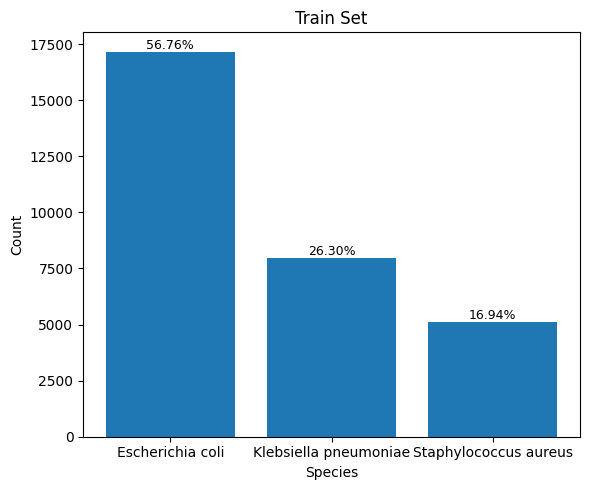

In [145]:
species_mapping = {0: 'Escherichia coli', 1: 'Klebsiella pneumoniae', 2: 'Staphylococcus aureus'}
datasets = {
    'Train': y_train_species_comb
}

fig, ax = plt.subplots(figsize=(6, 5))  

for label, data in datasets.items():
    counts = data.value_counts().sort_index()
    proportions = data.value_counts(normalize=True).sort_index()

    species_names = [species_mapping[label] for label in counts.index]

    bars = ax.bar(species_names, counts.values)  # Use species names on x-axis

    for bar, proportion in zip(bars, proportions):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{proportion:.2%}', va='bottom', ha='center', fontsize=9, color='black')

    ax.set_title(f'{label} Set')
    ax.set_xlabel('Species')  
    ax.set_ylabel('Count')
    ax.set_xticks(range(len(species_names)))  
    ax.set_xticklabels(species_names)  

plt.tight_layout()
plt.show()

In [146]:
X_train_species_comb

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19970,19973,19976,19979,19982,19985,19988,19991,19994,19997
0,1544.142857,1501.000000,1500.000000,1542.285714,1485.571429,1664.428571,1676.750000,1743.428571,1537.285714,1426.000000,...,14.333333,15.000000,26.500000,25.500000,14.0,15.500000,7.000000,25.5,12.666667,14.384615
1,29.000000,44.571429,17.714286,71.142857,82.000000,24.285714,47.285714,26.857143,26.000000,18.571429,...,18.000000,0.000000,8.000000,9.000000,5.0,6.500000,10.000000,1.5,3.000000,7.784314
2,977.571429,957.125000,939.428571,849.142857,842.571429,881.142857,955.857143,986.000000,996.714286,980.625000,...,53.500000,56.000000,46.500000,41.666667,40.5,37.500000,52.500000,66.0,44.500000,56.221154
3,5051.857143,4213.250000,3658.428571,3348.428571,3295.000000,3922.714286,3748.714286,3903.000000,3698.000000,3876.714286,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.028188
4,405.714286,385.375000,356.714286,419.000000,344.714286,383.428571,354.571429,370.428571,332.428571,319.142857,...,14.500000,10.000000,25.000000,5.000000,3.0,4.333333,7.500000,6.0,17.500000,7.676190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30243,1438.142857,1637.000000,1380.571429,1192.714286,1100.285714,1207.571429,1244.500000,1592.428571,1417.571429,1192.142857,...,19.000000,25.000000,18.500000,25.000000,21.0,22.500000,37.000000,38.0,28.500000,26.317308
30244,1251.714286,1362.428571,1139.428571,1022.714286,957.250000,1094.857143,1109.571429,1181.571429,1249.142857,1245.714286,...,5.500000,6.500000,2.333333,5.500000,1.5,5.000000,2.666667,2.5,2.500000,4.076190
30245,100.125000,108.285714,89.714286,110.857143,113.142857,95.428571,103.714286,77.428571,89.625000,88.571429,...,10.666667,13.000000,0.500000,5.500000,9.0,9.500000,4.500000,11.5,25.666667,8.375000
30246,1319.714286,1265.714286,1257.000000,1446.857143,1492.375000,1411.285714,1360.714286,1289.000000,1272.857143,1366.857143,...,27.500000,17.500000,11.000000,22.000000,20.0,20.500000,21.666667,28.5,27.500000,27.500000


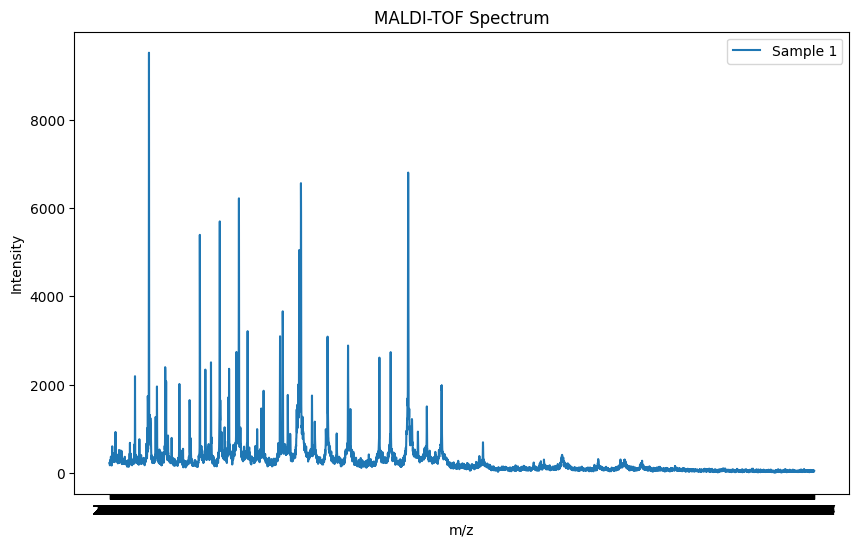

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(X_train_species_comb.columns, X_train_species_comb.iloc[0], label='Sample 1') 
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title('MALDI-TOF Spectrum')
plt.legend()
plt.show()

In [115]:
# missing values
X_train_nans = X_train_species_comb.isna().sum() 
X_train_nans[X_train_nans > 0]

Series([], dtype: int64)

In [30]:
num_columns = 50
sub_X_train = X_train_species_comb.sample(n=num_columns, axis=1, random_state=42)

## Dataset cleaning

### Outlier detection

In [82]:
# Detection of the outliers using IsolationForest
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
outliers_iso_forest = iso_forest.fit_predict(X_train_species_comb)

scores_iso_forest = iso_forest.decision_function(X_train_species_comb)
sum(scores_iso_forest == -1)

0

In [21]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
outliers_iso_forest = iso_forest.fit_predict(X_valid_species_comb)

scores_iso_forest = iso_forest.decision_function(X_valid_species_comb)
sum(scores_iso_forest == -1)

0

In [25]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
outliers_iso_forest = iso_forest.fit_predict(X_test_species_comb)

scores_iso_forest = iso_forest.decision_function(X_test_species_comb)
sum(scores_iso_forest == -1)

0

In [26]:
# Detection of the outliers using LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
outliers_lof = lof.fit_predict(X_train_species_comb)
scores_lof = lof.negative_outlier_factor_
sum(scores_lof == -1)

0

In [22]:
# Detection of the outliers using LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
outliers_lof = lof.fit_predict(X_valid_species_comb)
scores_lof = lof.negative_outlier_factor_
sum(scores_lof == -1)

0

In [27]:
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
outliers_lof = lof.fit_predict(X_test_species_comb)
scores_lof = lof.negative_outlier_factor_
sum(scores_lof == -1)

0

### Normalization

In [ ]:
# from sklearn.preprocessing import RobustScaler
# transformer = RobustScaler().fit(X_train)
# transformer
# transformer.transform(X_train)

In [16]:
# Scale the X-s
scaler = StandardScaler()
X_train_comb_scaled = pd.DataFrame(scaler.fit_transform(X_train_species_comb), 
                                   columns=X_train_species_comb.columns, 
                                   index=X_train_species_comb.index)

X_valid_comb_scaled = pd.DataFrame(scaler.transform(X_valid_species_comb), 
                                   columns=X_valid_species_comb.columns, 
                                   index=X_valid_species_comb.index)

X_test_comb_scaled = pd.DataFrame(scaler.transform(X_test_species_comb), 
                                  columns=X_test_species_comb.columns, 
                                  index=X_test_species_comb.index)

In [17]:
print("Original Data: Mean and Std for the first 5 features")
print("Means:", np.mean(X_train_species_comb, axis=0)[:5])
print("Standard Deviations:", np.std(X_train_species_comb, axis=0)[:5])

print("\nScaled Data: Mean and Std for the first 5 features")
print("Means:", np.mean(X_train_comb_scaled, axis=0)[:5])
print("Standard Deviations:", np.std(X_train_comb_scaled, axis=0)[:5])

Original Data: Mean and Std for the first 5 features
Means: 2000    1736.612488
2003    1720.555995
2006    1641.137970
2009    1610.351608
2012    1602.236707
dtype: float64
Standard Deviations: 2000    2596.694385
2003    2513.939265
2006    2419.241180
2009    2378.166447
2012    2353.090346
dtype: float64

Scaled Data: Mean and Std for the first 5 features
Means: 2000    1.503396e-17
2003   -3.194717e-17
2006   -5.825661e-17
2009    7.892831e-17
2012    6.953208e-17
dtype: float64
Standard Deviations: 2000    1.0
2003    1.0
2006    1.0
2009    1.0
2012    1.0
dtype: float64


In [123]:
type(X_train_comb_scaled)

pandas.core.frame.DataFrame

In [31]:
num_columns = 20
sub_X_train = X_train_species_comb.sample(n=num_columns, axis=1, random_state=42)
sub_scaled_X_train = X_train_comb_scaled.sample(n=num_columns, axis=1, random_state=42)

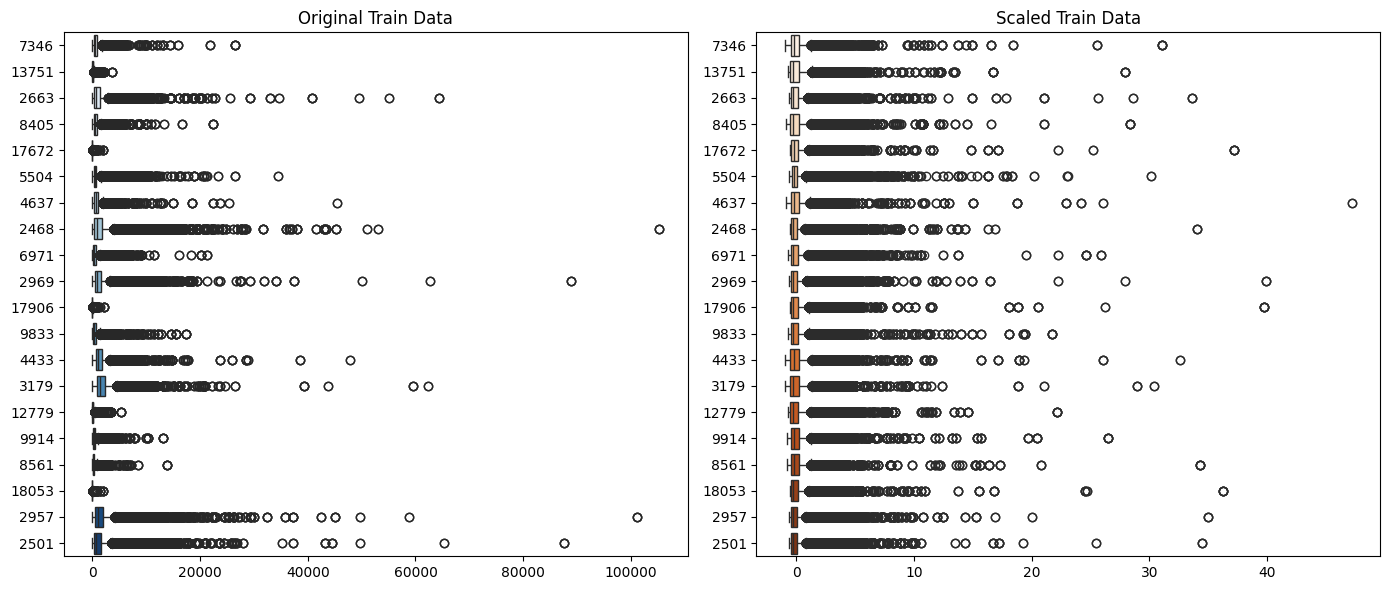

In [32]:
# Visualize the scaling
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=sub_X_train, orient='h', palette="Blues")
plt.title('Original Train Data')

plt.subplot(1, 2, 2)
sns.boxplot(data=sub_scaled_X_train, orient='h', palette="Oranges")
plt.title('Scaled Train Data')

plt.tight_layout()
plt.show()

## Dimensionality reduction: visualization PCA, t-SNE

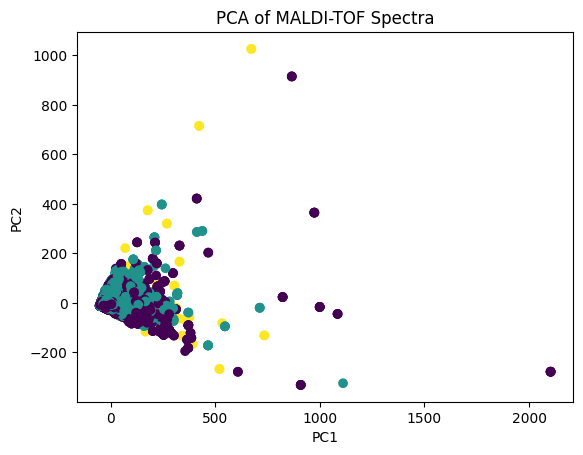

In [47]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_train_comb_scaled)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_train_species_comb, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of MALDI-TOF Spectra')
plt.show()

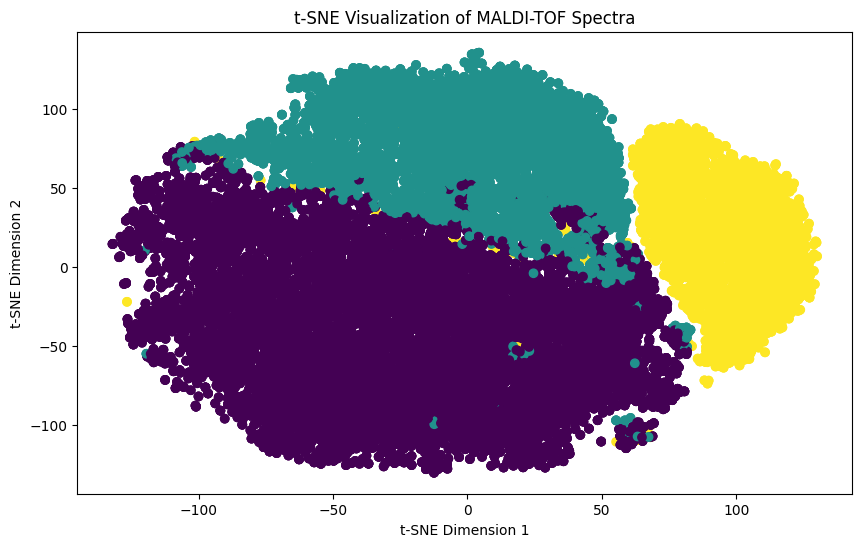

In [48]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_train_comb_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_train_species_comb, cmap='viridis')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of MALDI-TOF Spectra')
plt.show()

# Helper functions

In [17]:
def evaluate_model(model, x_train, y_train, x_valid, y_valid, x_test, y_test, task=None):
    model.fit(x_train, y_train)
    
    # Predict on training, validation, and test data
    y_train_pred = model.predict(x_train)
    y_valid_pred = model.predict(x_valid)
    y_test_pred = model.predict(x_test)
    
    # Training data metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
    train_precision_weighted = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_recall_weighted = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
    
    if task == 1:
        train_auprc = average_precision_score(y_train, model.predict_proba(x_train), average='weighted')
    elif task == 2:
        y_train_probabilities = model.predict_proba(x_train)
        train_auprc = np.mean([
            average_precision_score((y_train == c).astype(int), y_train_probabilities[:, c]) 
            for c in range(y_train_probabilities.shape[1])
        ])
    
    # Validation data metrics
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)
    valid_balanced_accuracy = balanced_accuracy_score(y_valid, y_valid_pred)
    valid_precision_weighted = precision_score(y_valid, y_valid_pred, average='weighted', zero_division=0)
    valid_recall_weighted = recall_score(y_valid, y_valid_pred, average='weighted', zero_division=0)
    valid_f1_weighted = f1_score(y_valid, y_valid_pred, average='weighted', zero_division=0)

    if task == 1:
        valid_auprc = average_precision_score(y_valid, model.predict_proba(x_valid), average='weighted')
    elif task == 2:
        y_valid_probabilities = model.predict_proba(x_valid)
        valid_auprc = np.mean([
            average_precision_score((y_valid == c).astype(int), y_valid_probabilities[:, c]) 
            for c in range(y_valid_probabilities.shape[1])
        ])
    
    # Test data metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
    test_precision_weighted = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_recall_weighted = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

    if task == 1:
        test_auprc = average_precision_score(y_test, model.predict_proba(x_test), average='weighted')
    elif task == 2:
        y_test_probabilities = model.predict_proba(x_test)
        test_auprc = np.mean([
            average_precision_score((y_test == c).astype(int), y_test_probabilities[:, c]) 
            for c in range(y_test_probabilities.shape[1])
        ])

    results = {
        'Metric': ['Accuracy', 'Balanced Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1 Score (Weighted)', 'AUPRC'],
        'Train Score': [
            train_accuracy, train_balanced_accuracy, train_precision_weighted,
            train_recall_weighted, train_f1_weighted, train_auprc
        ],
        'Validation Score': [
            valid_accuracy, valid_balanced_accuracy, valid_precision_weighted,
            valid_recall_weighted, valid_f1_weighted, valid_auprc
        ],
        'Test Score': [
            test_accuracy, test_balanced_accuracy, test_precision_weighted,
            test_recall_weighted, test_f1_weighted, test_auprc
        ]
    }
    
    return pd.DataFrame(results)

In [18]:
def format_time(seconds):
    minutes = int(seconds // 60)
    seconds_remaining = round(seconds % 60)  
    return f'{minutes} min {seconds_remaining} sec'

def evaluate_model_with_time(model, x_train, y_train, x_valid, y_valid, x_test, y_test, task=None):
    start_time = time.time()
    results = evaluate_model(model, x_train, y_train, x_valid, y_valid, x_test, y_test, task=task)
    end_time = time.time()

    execution_time_seconds = end_time - start_time
    execution_time_formatted = format_time(execution_time_seconds)
    time_df = pd.DataFrame({'Execution Time': [execution_time_formatted]})
    
    final_df = pd.concat([results, time_df], axis=1)
    final_df['Execution Time'] = final_df['Execution Time'].ffill()
    return final_df

## Model comparison

### RF

In [86]:
parameters  = {
    'n_estimators': randint(50, 200),        # The number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50], # The maximum depth of the tree
}

In [140]:
# Number of parameter settings to sample
n_iter = 10

param_sampler = ParameterSampler(parameters, n_iter=n_iter, random_state=42)

best_params = None
best_score = 0

for params in tqdm(param_sampler):
    rf_model = RandomForestClassifier(**params, 
                                      n_jobs=100,      # Parallelization
                                      random_state=42) # Reproducibility
    
    rf_model.fit(X_train_comb_scaled, y_train_species_comb)
    y_pred = rf_model.predict(X_valid_comb_scaled)
    score = f1_score(y_valid_species_comb, y_pred, average='weighted')

    if score > best_score:
        best_score = score
        best_params = params

print("Best parameters found: ", best_params)
print("Best validation F1-score: ", best_score)

100%|██████████| 10/10 [00:54<00:00,  5.45s/it]

Best parameters found:  {'max_depth': 40, 'n_estimators': 70}
Best validation F1-score:  0.9996914583786641


In [141]:
# Train the final model with the best parameters
final_rf_model = RandomForestClassifier(**best_params, random_state=42)
results_rf_model_species = evaluate_model_with_time(final_rf_model, 
                                                    X_train_comb_scaled, y_train_species_comb, 
                                                    X_valid_comb_scaled, y_valid_species_comb, 
                                                    X_test_comb_scaled, y_test_species_comb, task=1)

In [142]:
results_rf_model_species

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,1.0,0.999692,1.0,1 min 13 sec
1,Balanced Accuracy,1.0,0.999425,1.0,1 min 13 sec
2,Precision (Weighted),1.0,0.999692,1.0,1 min 13 sec
3,Recall (Weighted),1.0,0.999692,1.0,1 min 13 sec
4,F1 Score (Weighted),1.0,0.999691,1.0,1 min 13 sec
5,AUPRC,1.0,1.000000,1.0,1 min 13 sec


In [143]:
# Extract test F1 score and AUPRC from the results dataframe
f1_scores_test = results_rf_model_species.loc[results_rf_model_species['Metric'] == 'F1 Score (Weighted)', 'Test Score'].values
auprc_test = results_rf_model_species.loc[results_rf_model_species['Metric'] == 'AUPRC', 'Test Score'].values

In [144]:
f1_scores_test, auprc_test

(array([1.]), array([1.]))

### SVM

In [227]:
parameters_svm = {
    "C": np.logspace(-3,3,7), 
    "kernel": ['linear', 'rbf']
}

In [228]:
# Number of parameter settings to sample
n_iter = 5

param_sampler_svm = ParameterSampler(parameters_svm, n_iter=n_iter, random_state=42)

best_params = None
best_score = 0

for params in tqdm(param_sampler_svm):
    svc_model = svm.SVC(**params, decision_function_shape='ovr', probability=True, random_state=42)  

    svc_model.fit(X_train_species_comb, y_train_species_comb)
    y_pred = svc_model.predict(X_valid_species_comb)
    score = f1_score(y_valid_species_comb, y_pred, average='weighted')

    if score > best_score:
        best_score_svm_1 = score
        best_params_svm_1 = params

print("Best parameters found: ", best_params_svm_1)
print("Best validation score: ", best_score_svm_1)

100%|██████████| 5/5 [35:53<00:00, 430.69s/it]

Best parameters found:  {'kernel': 'rbf', 'C': 0.1}
Best validation score:  0.9927414997906688


In [101]:
final_svm_ovr_model = svm.SVC(**best_params_svm_1, decision_function_shape='ovr', probability=True, random_state=42)
results_svm_model_species = evaluate_model_with_time(final_svm_ovr_model,
                                                     X_train_comb_scaled, y_train_species_comb, 
                                                     X_valid_comb_scaled, y_valid_species_comb, 
                                                     X_test_comb_scaled, y_test_species_comb, task=1)

In [102]:
results_svm_model_species

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,0.998149,0.997995,0.998458,4 min 29 sec
1,Balanced Accuracy,0.997510,0.997225,0.998245,4 min 29 sec
2,Precision (Weighted),0.998152,0.998000,0.998458,4 min 29 sec
3,Recall (Weighted),0.998149,0.997995,0.998458,4 min 29 sec
4,F1 Score (Weighted),0.998148,0.997995,0.998458,4 min 29 sec
5,AUPRC,0.999998,0.999997,0.999996,4 min 29 sec


In [103]:
models = ['RF', 'SVM']

combined_results_species = pd.DataFrame()

for model, df in zip(models, [results_rf_model_species, results_svm_model_species]):
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[model], df_selected.columns])
    combined_results_species = pd.concat([combined_results_species, df_selected], axis=1)

combined_results_species.columns.names = ['Model', None]

combined_results_species

Model                         RF                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                     1.0         0.999692        1.0   1 min 13 sec   
Balanced Accuracy            1.0         0.999425        1.0   1 min 13 sec   
Precision (Weighted)         1.0         0.999692        1.0   1 min 13 sec   
Recall (Weighted)            1.0         0.999692        1.0   1 min 13 sec   
F1 Score (Weighted)          1.0         0.999691        1.0   1 min 13 sec   
AUPRC                        1.0         1.000000        1.0   1 min 13 sec   

Model                        SVM                                             
                     Train Score Validation Score Test Score Execution Time  
Metric                                                                       
Accuracy                0.998149         0.997995   0.998458   4 min 29 sec  
Balanced Accuracy       0.997510         0.997225   0.998245   4 min 29 sec  
Precision (Weighted)    0.998152         0.998000   0.998458   4 min 29 sec  
Recall (Weighted)       0.998149         0.997995   0.998458   4 min 29 sec  
F1 Score (Weighted)     0.998148         0.997995   0.998458   4 min 29 sec  
AUPRC                   0.999998         0.999997   0.999996   4 min 29 sec

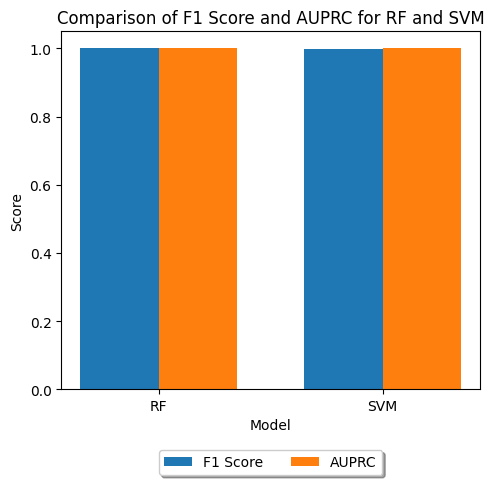

In [104]:
models = ['RF', 'SVM']

#  F1 Scores and AUPRC 
f1_scores = {model: combined_results_species.loc['F1 Score (Weighted)', (model, 'Test Score')] for model in models}
auprc_scores = {model: combined_results_species.loc['AUPRC', (model, 'Test Score')] for model in models}

# Create the plot
fig, ax = plt.subplots(figsize=(5, 5))
index = np.arange(len(models))
bar_width = 0.35

# Plotting both F1 and AUPRC for each model
ax.bar(index - bar_width/2, [f1_scores[model] for model in models], bar_width, label='F1 Score')
ax.bar(index + bar_width/2, [auprc_scores[model] for model in models], bar_width, label='AUPRC')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Comparison of F1 Score and AUPRC for RF and SVM')
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.show()

## Feature importance

In [105]:
clf = DecisionTreeClassifier(max_depth=40, random_state=42)
clf.fit(X_train_comb_scaled, y_train_species_comb)

DecisionTreeClassifier(max_depth=40, random_state=42)

In [106]:
y_valid_pred = clf.predict(X_valid_comb_scaled)

In [107]:
importances = clf.feature_importances_
clf_importance_df = pd.DataFrame({'Feature': X_train_species_comb.columns, 'Importance': importances})
clf_importance_df = clf_importance_df.sort_values(by='Importance', ascending=False)  

In [108]:
clf_importance_df.head(15)

,Feature,Importance
1419,6257,0.353674
1914,7742,0.284028
1615,6845,0.276410
2354,9062,0.015435
1470,6410,0.013873
2584,9752,0.006533
1630,6890,0.006080
2492,9476,0.005876
1957,7871,0.004979
2495,9485,0.004290


### Decision Tree after dim reduction

In [110]:
threshold = 0.2
selected_features = X_train_comb_scaled.columns[importances > threshold]

In [111]:
X_train_selected_3 = X_train_comb_scaled[selected_features]
X_valid_selected_3 = X_valid_comb_scaled[selected_features]
X_test_selected_3 = X_test_comb_scaled[selected_features]

In [112]:
clf_3 = DecisionTreeClassifier(max_depth=40, random_state=42)

In [113]:
results_dr_model_species_3 = evaluate_model_with_time(clf_3,
                                                     X_train_selected_3, y_train_species_comb, 
                                                     X_valid_selected_3, y_valid_species_comb, 
                                                     X_test_selected_3,  y_test_species_comb, task=1)

In [114]:
results_dr_model_species_3

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,1.0,0.999229,0.998921,0 min 0 sec
1,Balanced Accuracy,1.0,0.999042,0.998619,0 min 0 sec
2,Precision (Weighted),1.0,0.999230,0.998923,0 min 0 sec
3,Recall (Weighted),1.0,0.999229,0.998921,0 min 0 sec
4,F1 Score (Weighted),1.0,0.999229,0.998920,0 min 0 sec
5,AUPRC,1.0,0.998666,0.998124,0 min 0 sec


In [115]:
threshold = 0.28
selected_features_2 = X_train_comb_scaled.columns[importances > threshold]

In [119]:
X_train_selected_2 = X_train_comb_scaled[selected_features_2]
X_valid_selected_2 = X_valid_comb_scaled[selected_features_2]
X_test_selected_2 = X_test_comb_scaled[selected_features_2]

In [117]:
clf_2 = DecisionTreeClassifier(max_depth=40, random_state=42)

In [120]:
results_dr_model_species_2 = evaluate_model_with_time(clf_2,
                                                    X_train_selected_2, y_train_species_comb, 
                                                    X_valid_selected_2, y_valid_species_comb, 
                                                    X_test_selected_2, y_test_species_comb, task=1)

In [121]:
results_dr_model_species_2

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,1.0,0.991518,0.989514,0 min 0 sec
1,Balanced Accuracy,1.0,0.985249,0.980962,0 min 0 sec
2,Precision (Weighted),1.0,0.991599,0.989644,0 min 0 sec
3,Recall (Weighted),1.0,0.991518,0.989514,0 min 0 sec
4,F1 Score (Weighted),1.0,0.991492,0.989467,0 min 0 sec
5,AUPRC,1.0,0.984875,0.981259,0 min 0 sec


In [122]:
threshold = 0.3
selected_feature_1 = X_train_comb_scaled.columns[importances > threshold]

In [123]:
X_train_selected_1 = X_train_comb_scaled[selected_feature_1]
X_valid_selected_1 = X_valid_comb_scaled[selected_feature_1]
X_test_selected_1 = X_test_comb_scaled[selected_feature_1]

In [124]:
clf_1 = DecisionTreeClassifier(max_depth=40, random_state=42)

In [125]:
results_dr_model_species_1 = evaluate_model_with_time(clf_1,
                                                    X_train_selected_1, y_train_species_comb, 
                                                    X_valid_selected_1, y_valid_species_comb, 
                                                    X_test_selected_1, y_test_species_comb, task=1)

In [126]:
results_dr_model_species_1

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,0.951931,0.922270,0.925675,0 min 0 sec
1,Balanced Accuracy,0.928230,0.889043,0.890675,0 min 0 sec
2,Precision (Weighted),0.952775,0.923762,0.926850,0 min 0 sec
3,Recall (Weighted),0.951931,0.922270,0.925675,0 min 0 sec
4,F1 Score (Weighted),0.951679,0.921782,0.925105,0 min 0 sec
5,AUPRC,0.991431,0.953299,0.957122,0 min 0 sec


In [127]:
models = ['RF', 'SVM']

combined_results_species = pd.DataFrame()

for model, df in zip(models, [results_rf_model_species, results_svm_model_species]):
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[model], df_selected.columns])
    combined_results_species = pd.concat([combined_results_species, df_selected], axis=1)

combined_results_species.columns.names = ['Model', None]

combined_results_species

Model                         RF                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                     1.0         0.999692        1.0   1 min 13 sec   
Balanced Accuracy            1.0         0.999425        1.0   1 min 13 sec   
Precision (Weighted)         1.0         0.999692        1.0   1 min 13 sec   
Recall (Weighted)            1.0         0.999692        1.0   1 min 13 sec   
F1 Score (Weighted)          1.0         0.999691        1.0   1 min 13 sec   
AUPRC                        1.0         1.000000        1.0   1 min 13 sec   

Model                        SVM                                             
                     Train Score Validation Score Test Score Execution Time  
Metric                                                                       
Accuracy                0.998149         0.997995   0.998458   4 min 29 sec  
Balanced Accuracy       0.997510         0.997225   0.998245   4 min 29 sec  
Precision (Weighted)    0.998152         0.998000   0.998458   4 min 29 sec  
Recall (Weighted)       0.998149         0.997995   0.998458   4 min 29 sec  
F1 Score (Weighted)     0.998148         0.997995   0.998458   4 min 29 sec  
AUPRC                   0.999998         0.999997   0.999996   4 min 29 sec

In [128]:
Features = ['"6257", "7742", "6845"', '"6257", "7742"', '"6257"']

rf_dim_red_combined = pd.DataFrame()

for feature, df in zip(Features, [results_dr_model_species_3, results_dr_model_species_2, results_dr_model_species_1]):
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[feature], df_selected.columns])
    rf_dim_red_combined = pd.concat([rf_dim_red_combined, df_selected], axis=1)

rf_dim_red_combined.columns.names = ['Features', None]

rf_dim_red_combined

Features             "6257", "7742", "6845"                              \
                                Train Score Validation Score Test Score   
Metric                                                                    
Accuracy                                1.0         0.999229   0.998921   
Balanced Accuracy                       1.0         0.999042   0.998619   
Precision (Weighted)                    1.0         0.999230   0.998923   
Recall (Weighted)                       1.0         0.999229   0.998921   
F1 Score (Weighted)                     1.0         0.999229   0.998920   
AUPRC                                   1.0         0.998666   0.998124   

Features                            "6257", "7742"                   \
                     Execution Time    Train Score Validation Score   
Metric                                                                
Accuracy                0 min 0 sec            1.0         0.991518   
Balanced Accuracy       0 min 0 sec            1.0         0.985249   
Precision (Weighted)    0 min 0 sec            1.0         0.991599   
Recall (Weighted)       0 min 0 sec            1.0         0.991518   
F1 Score (Weighted)     0 min 0 sec            1.0         0.991492   
AUPRC                   0 min 0 sec            1.0         0.984875   

Features                                            "6257"                   \
                     Test Score Execution Time Train Score Validation Score   
Metric                                                                        
Accuracy               0.989514    0 min 0 sec    0.951931         0.922270   
Balanced Accuracy      0.980962    0 min 0 sec    0.928230         0.889043   
Precision (Weighted)   0.989644    0 min 0 sec    0.952775         0.923762   
Recall (Weighted)      0.989514    0 min 0 sec    0.951931         0.922270   
F1 Score (Weighted)    0.989467    0 min 0 sec    0.951679         0.921782   
AUPRC                  0.981259    0 min 0 sec    0.991431         0.953299   

Features                                        
                     Test Score Execution Time  
Metric                                          
Accuracy               0.925675    0 min 0 sec  
Balanced Accuracy      0.890675    0 min 0 sec  
Precision (Weighted)   0.926850    0 min 0 sec  
Recall (Weighted)      0.925675    0 min 0 sec  
F1 Score (Weighted)    0.925105    0 min 0 sec  
AUPRC                  0.957122    0 min 0 sec

In [88]:
rf_dim_red_combined.T

Metric                                      Accuracy Balanced Accuracy  \
Features                                                                 
"6257", "7742", "6845" Train Score               1.0               1.0   
                       Validation Score     0.999229          0.999042   
                       Execution Time    0 min 0 sec       0 min 0 sec   
"6257", "7742"         Train Score               1.0               1.0   
                       Validation Score     0.991518          0.985249   
                       Execution Time    0 min 0 sec       0 min 0 sec   
"6257"                 Train Score          0.951931           0.92823   
                       Validation Score      0.92227          0.889043   
                       Execution Time    0 min 0 sec       0 min 0 sec   

Metric                                  Precision (Weighted)  \
Features                                                       
"6257", "7742", "6845" Train Score                       1.0   
                       Validation Score              0.99923   
                       Execution Time            0 min 0 sec   
"6257", "7742"         Train Score                       1.0   
                       Validation Score             0.991599   
                       Execution Time            0 min 0 sec   
"6257"                 Train Score                  0.952775   
                       Validation Score             0.923762   
                       Execution Time            0 min 0 sec   

Metric                                  Recall (Weighted) F1 Score (Weighted)  \
Features                                                                        
"6257", "7742", "6845" Train Score                    1.0                 1.0   
                       Validation Score          0.999229            0.999229   
                       Execution Time         0 min 0 sec         0 min 0 sec   
"6257", "7742"         Train Score                    1.0                 1.0   
                       Validation Score          0.991518            0.991492   
                       Execution Time         0 min 0 sec         0 min 0 sec   
"6257"                 Train Score               0.951931            0.951679   
                       Validation Score           0.92227            0.921782   
                       Execution Time         0 min 0 sec         0 min 0 sec   

Metric                                         AUPRC  
Features                                              
"6257", "7742", "6845" Train Score               1.0  
                       Validation Score     0.998666  
                       Execution Time    0 min 0 sec  
"6257", "7742"         Train Score               1.0  
                       Validation Score     0.984875  
                       Execution Time    0 min 0 sec  
"6257"                 Train Score          0.991431  
                       Validation Score     0.953299  
                       Execution Time    0 min 0 sec

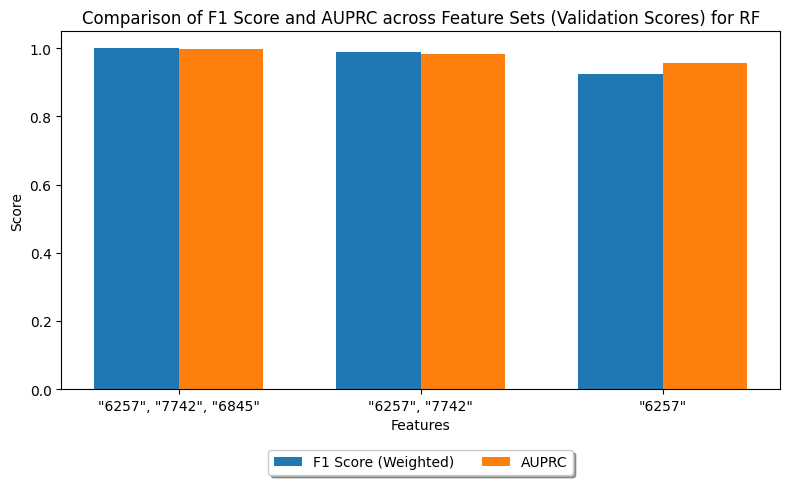

In [129]:
# Define the features and metrics to plot
metrics = ['F1 Score (Weighted)', 'AUPRC']
features = ['"6257", "7742", "6845"', '"6257", "7742"', '"6257"']
test_col = 'Test Score'

# Extract F1 scores and AUPRC for each feature set
f1_scores = [rf_dim_red_combined.loc['F1 Score (Weighted)', (feature, test_col)] for feature in features]
auprc_scores = [rf_dim_red_combined.loc['AUPRC', (feature, test_col)] for feature in features]

bar_width = 0.35
index = np.arange(len(features))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plotting F1 scores and AUPRC side by side for each feature set
ax.bar(index - bar_width/2, f1_scores, bar_width, label='F1 Score (Weighted)')
ax.bar(index + bar_width/2, auprc_scores, bar_width, label='AUPRC')

# Set the labels and titles
ax.set_xlabel('Features')
ax.set_ylabel('Score')
ax.set_title('Comparison of F1 Score and AUPRC across Feature Sets (Validation Scores) for RF')
ax.set_xticks(index)
ax.set_xticklabels(features, rotation=0)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

plt.tight_layout()

plt.show()

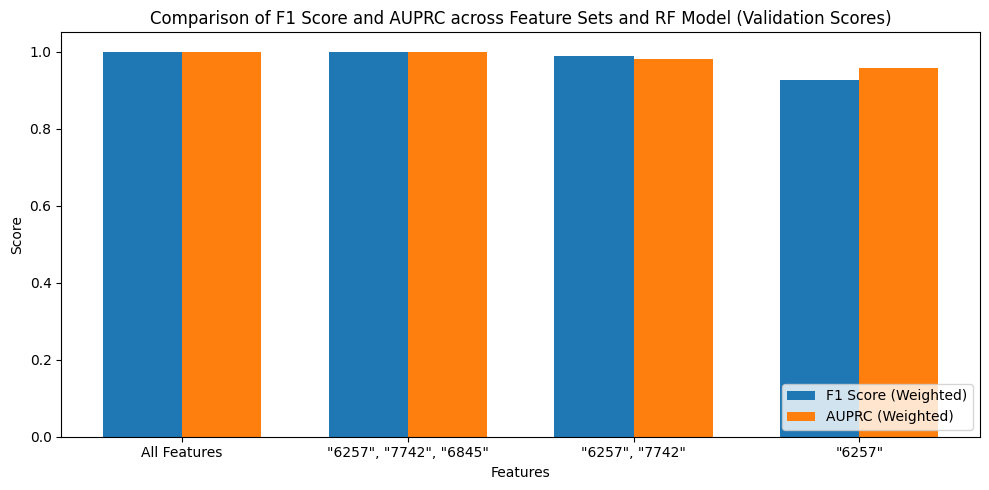

In [130]:
# Model names and feature set names
models = ['RF', 'SVM']
features = ['"6257", "7742", "6845"', '"6257", "7742"', '"6257"']

# Extract F1 Scores and AUPRC for each model
model_f1_scores = {model: combined_results_species.loc['F1 Score (Weighted)', (model, 'Test Score')] for model in models}
model_auprc_scores = {model: combined_results_species.loc['AUPRC', (model, 'Test Score')] for model in models}

# Extract F1 Scores and AUPRC for each feature set
feature_f1_scores = [rf_dim_red_combined.loc['F1 Score (Weighted)', (feature, 'Test Score')] for feature in features]
feature_auprc_scores = [rf_dim_red_combined.loc['AUPRC', (feature, 'Test Score')] for feature in features]

# Include RF model scores
feature_f1_scores.insert(0, model_f1_scores['RF'])
feature_auprc_scores.insert(0, model_auprc_scores['RF'])
features.insert(0, 'RF')
features[0] = 'All Features'

# Set up plotting parameters
bar_width = 0.35
index = np.arange(len(features))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting F1 scores and AUPRC side by side for each feature set and the RF model
ax.bar(index - bar_width/2, feature_f1_scores, bar_width, label='F1 Score (Weighted)')
ax.bar(index + bar_width/2, feature_auprc_scores, bar_width, label='AUPRC (Weighted)')

# Set the labels and titles
ax.set_xlabel('Features')
ax.set_ylabel('Score')
ax.set_title('Comparison of F1 Score and AUPRC across Feature Sets and RF Model (Validation Scores)')
ax.set_xticks(index)
ax.set_xticklabels(features, rotation=0)
ax.legend(loc='lower right')

plt.tight_layout()
fig.savefig('rf_features_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### SVM after dim reduction

In [131]:
svm_ovr_model_3 = svm.SVC(**best_params_svm_1, decision_function_shape='ovr', probability=True, random_state=42)

In [132]:
results_svm_model_species_3 = evaluate_model_with_time(svm_ovr_model_3,
                                                        X_train_selected_3, y_train_species_comb, 
                                                        X_valid_selected_3, y_valid_species_comb, 
                                                        X_test_selected_3, y_test_species_comb, task=1)

In [133]:
results_svm_model_species_3

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,0.964196,0.963911,0.961758,0 min 33 sec
1,Balanced Accuracy,0.950321,0.951402,0.948960,0 min 33 sec
2,Precision (Weighted),0.965375,0.965304,0.962973,0 min 33 sec
3,Recall (Weighted),0.964196,0.963911,0.961758,0 min 33 sec
4,F1 Score (Weighted),0.964012,0.963735,0.961511,0 min 33 sec
5,AUPRC,0.995384,0.997794,0.992493,0 min 33 sec


In [134]:
svm_ovr_model_2 = svm.SVC(**best_params_svm_1, decision_function_shape='ovr', probability=True, random_state=42)
results_svm_model_species_2 = evaluate_model_with_time(svm_ovr_model_2,
                                                        X_train_selected_2, y_train_species_comb, 
                                                        X_valid_selected_2, y_valid_species_comb, 
                                                        X_test_selected_2, y_test_species_comb, task=1)

In [135]:
results_svm_model_species_2

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,0.870901,0.877699,0.873246,0 min 50 sec
1,Balanced Accuracy,0.780664,0.802642,0.788983,0 min 50 sec
2,Precision (Weighted),0.863528,0.873243,0.867046,0 min 50 sec
3,Recall (Weighted),0.870901,0.877699,0.873246,0 min 50 sec
4,F1 Score (Weighted),0.862127,0.870953,0.865866,0 min 50 sec
5,AUPRC,0.955120,0.953843,0.953643,0 min 50 sec


In [136]:
svm_ovr_model_1 = svm.SVC(**best_params_svm_1, decision_function_shape='ovr', probability=True, random_state=42)
results_svm_model_species_1 = evaluate_model_with_time(svm_ovr_model_1,
                                                        X_train_selected_1, y_train_species_comb, 
                                                        X_valid_selected_1, y_valid_species_comb, 
                                                        X_test_selected_1, y_test_species_comb, task=1)
results_svm_model_species_1

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,0.703385,0.701110,0.703007,1 min 17 sec
1,Balanced Accuracy,0.559909,0.567991,0.561458,1 min 17 sec
2,Precision (Weighted),0.638595,0.633614,0.638942,1 min 17 sec
3,Recall (Weighted),0.703385,0.701110,0.703007,1 min 17 sec
4,F1 Score (Weighted),0.657653,0.652280,0.657144,1 min 17 sec
5,AUPRC,0.829508,0.835287,0.829956,1 min 17 sec


In [137]:
Features = ['"6257", "7742", "6845"', '"6257", "7742"', '"6257"']

svm_dim_red_combined = pd.DataFrame()

for feature, df in zip(Features, [results_svm_model_species_3, results_svm_model_species_2, results_svm_model_species_1]):
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[feature], df_selected.columns])
    svm_dim_red_combined = pd.concat([svm_dim_red_combined, df_selected], axis=1)

svm_dim_red_combined.columns.names = ['Features', None]
svm_dim_red_combined = svm_dim_red_combined.round(4)

svm_dim_red_combined

Features             "6257", "7742", "6845"                              \
                                Train Score Validation Score Test Score   
Metric                                                                    
Accuracy                             0.9642           0.9639     0.9618   
Balanced Accuracy                    0.9503           0.9514     0.9490   
Precision (Weighted)                 0.9654           0.9653     0.9630   
Recall (Weighted)                    0.9642           0.9639     0.9618   
F1 Score (Weighted)                  0.9640           0.9637     0.9615   
AUPRC                                0.9954           0.9978     0.9925   

Features                            "6257", "7742"                   \
                     Execution Time    Train Score Validation Score   
Metric                                                                
Accuracy               0 min 33 sec         0.8709           0.8777   
Balanced Accuracy      0 min 33 sec         0.7807           0.8026   
Precision (Weighted)   0 min 33 sec         0.8635           0.8732   
Recall (Weighted)      0 min 33 sec         0.8709           0.8777   
F1 Score (Weighted)    0 min 33 sec         0.8621           0.8710   
AUPRC                  0 min 33 sec         0.9551           0.9538   

Features                                            "6257"                   \
                     Test Score Execution Time Train Score Validation Score   
Metric                                                                        
Accuracy                 0.8732   0 min 50 sec      0.7034           0.7011   
Balanced Accuracy        0.7890   0 min 50 sec      0.5599           0.5680   
Precision (Weighted)     0.8670   0 min 50 sec      0.6386           0.6336   
Recall (Weighted)        0.8732   0 min 50 sec      0.7034           0.7011   
F1 Score (Weighted)      0.8659   0 min 50 sec      0.6577           0.6523   
AUPRC                    0.9536   0 min 50 sec      0.8295           0.8353   

Features                                        
                     Test Score Execution Time  
Metric                                          
Accuracy                 0.7030   1 min 17 sec  
Balanced Accuracy        0.5615   1 min 17 sec  
Precision (Weighted)     0.6389   1 min 17 sec  
Recall (Weighted)        0.7030   1 min 17 sec  
F1 Score (Weighted)      0.6571   1 min 17 sec  
AUPRC                    0.8300   1 min 17 sec

In [138]:
svm_dim_red_combined.T

Metric                                       Accuracy Balanced Accuracy  \
Features                                                                  
"6257", "7742", "6845" Train Score             0.9642            0.9503   
                       Validation Score        0.9639            0.9514   
                       Test Score              0.9618             0.949   
                       Execution Time    0 min 33 sec      0 min 33 sec   
"6257", "7742"         Train Score             0.8709            0.7807   
                       Validation Score        0.8777            0.8026   
                       Test Score              0.8732             0.789   
                       Execution Time    0 min 50 sec      0 min 50 sec   
"6257"                 Train Score             0.7034            0.5599   
                       Validation Score        0.7011             0.568   
                       Test Score               0.703            0.5615   
                       Execution Time    1 min 17 sec      1 min 17 sec   

Metric                                  Precision (Weighted)  \
Features                                                       
"6257", "7742", "6845" Train Score                    0.9654   
                       Validation Score               0.9653   
                       Test Score                      0.963   
                       Execution Time           0 min 33 sec   
"6257", "7742"         Train Score                    0.8635   
                       Validation Score               0.8732   
                       Test Score                      0.867   
                       Execution Time           0 min 50 sec   
"6257"                 Train Score                    0.6386   
                       Validation Score               0.6336   
                       Test Score                     0.6389   
                       Execution Time           1 min 17 sec   

Metric                                  Recall (Weighted) F1 Score (Weighted)  \
Features                                                                        
"6257", "7742", "6845" Train Score                 0.9642               0.964   
                       Validation Score            0.9639              0.9637   
                       Test Score                  0.9618              0.9615   
                       Execution Time        0 min 33 sec        0 min 33 sec   
"6257", "7742"         Train Score                 0.8709              0.8621   
                       Validation Score            0.8777               0.871   
                       Test Score                  0.8732              0.8659   
                       Execution Time        0 min 50 sec        0 min 50 sec   
"6257"                 Train Score                 0.7034              0.6577   
                       Validation Score            0.7011              0.6523   
                       Test Score                   0.703              0.6571   
                       Execution Time        1 min 17 sec        1 min 17 sec   

Metric                                          AUPRC  
Features                                               
"6257", "7742", "6845" Train Score             0.9954  
                       Validation Score        0.9978  
                       Test Score              0.9925  
                       Execution Time    0 min 33 sec  
"6257", "7742"         Train Score             0.9551  
                       Validation Score        0.9538  
                       Test Score              0.9536  
                       Execution Time    0 min 50 sec  
"6257"                 Train Score             0.8295  
                       Validation Score        0.8353  
                       Test Score                0.83  
                       Execution Time    1 min 17 sec

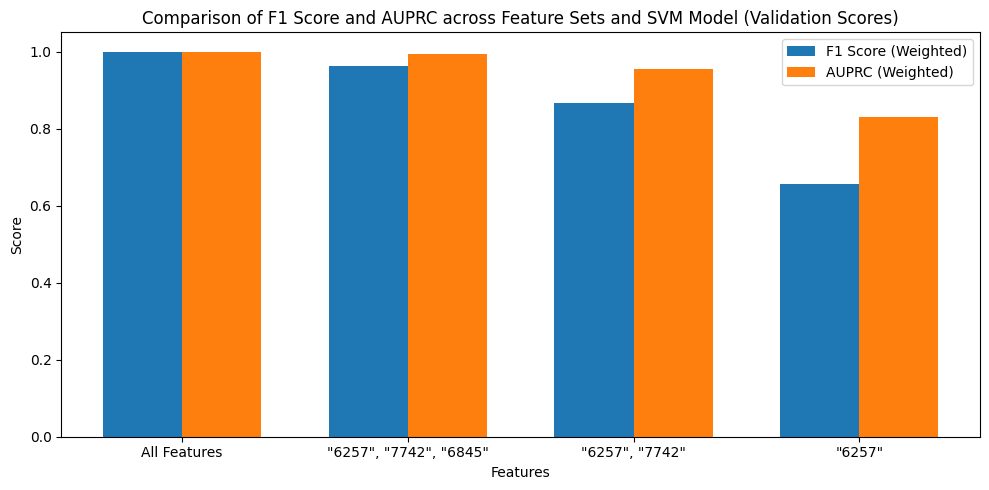

In [139]:
models = ['RF', 'SVM']
features = ['"6257", "7742", "6845"', '"6257", "7742"', '"6257"']

# Extract F1 Scores and AUPRC 
model_f1_scores = {model: combined_results_species.loc['F1 Score (Weighted)', (model, 'Test Score')] for model in models}
model_auprc_scores = {model: combined_results_species.loc['AUPRC', (model, 'Test Score')] for model in models}

# Extract F1 Scores and AUPRC 
feature_f1_scores = [svm_dim_red_combined.loc['F1 Score (Weighted)', (feature, 'Test Score')] for feature in features]
feature_auprc_scores = [svm_dim_red_combined.loc['AUPRC', (feature, 'Test Score')] for feature in features]

# Include SVM model scores
feature_f1_scores.insert(0, model_f1_scores['SVM'])
feature_auprc_scores.insert(0, model_auprc_scores['SVM'])
features.insert(0, 'All Features')  

# Set up plotting parameters
bar_width = 0.35
index = np.arange(len(features))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting F1 scores and AUPRC side by side for each feature set and the SVM model
ax.bar(index - bar_width/2, feature_f1_scores, bar_width, label='F1 Score (Weighted)')
ax.bar(index + bar_width/2, feature_auprc_scores, bar_width, label='AUPRC (Weighted)')

# Set the labels and titles
ax.set_xlabel('Features')
ax.set_ylabel('Score')
ax.set_title('Comparison of F1 Score and AUPRC across Feature Sets and SVM Model (Validation Scores)')
ax.set_xticks(index)
ax.set_xticklabels(features, rotation=0)
ax.legend(loc='upper right')

plt.tight_layout()
fig.savefig('svm_features_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Visualization after dim reduction

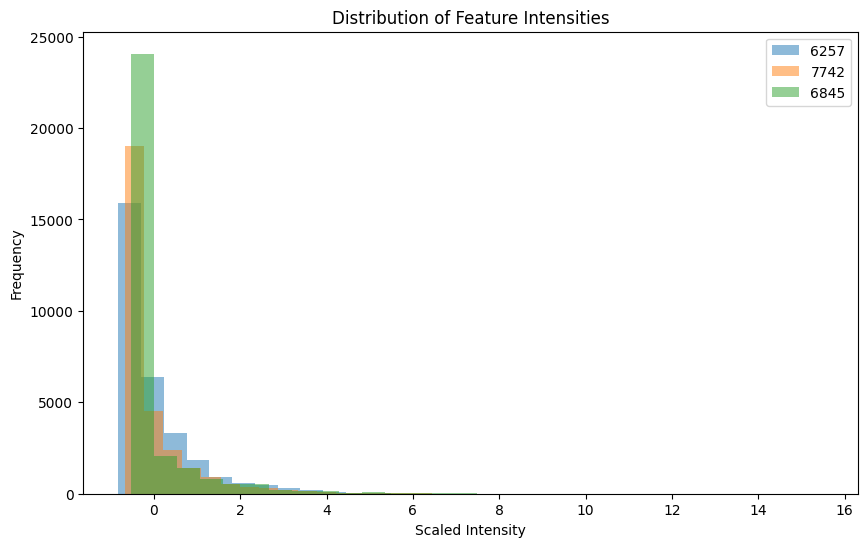

In [73]:
plt.figure(figsize=(10, 6))
plt.hist(X_train_comb_scaled['6257'], bins=30, alpha=0.5, label='6257')
plt.hist(X_train_comb_scaled['7742'], bins=30, alpha=0.5, label='7742')
plt.hist(X_train_comb_scaled['6845'], bins=30, alpha=0.5, label='6845')
plt.title('Distribution of Feature Intensities')
plt.xlabel('Scaled Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [22]:
species_mapping = {0: 'Escherichia coli', 1: 'Klebsiella pneumoniae', 2: 'Staphylococcus aureus'}

data = X_train_comb_scaled[['6257', '7742', '6845']].copy()
data['Species'] = y_train_species_comb

data['Species'] = data['Species'].map(species_mapping)

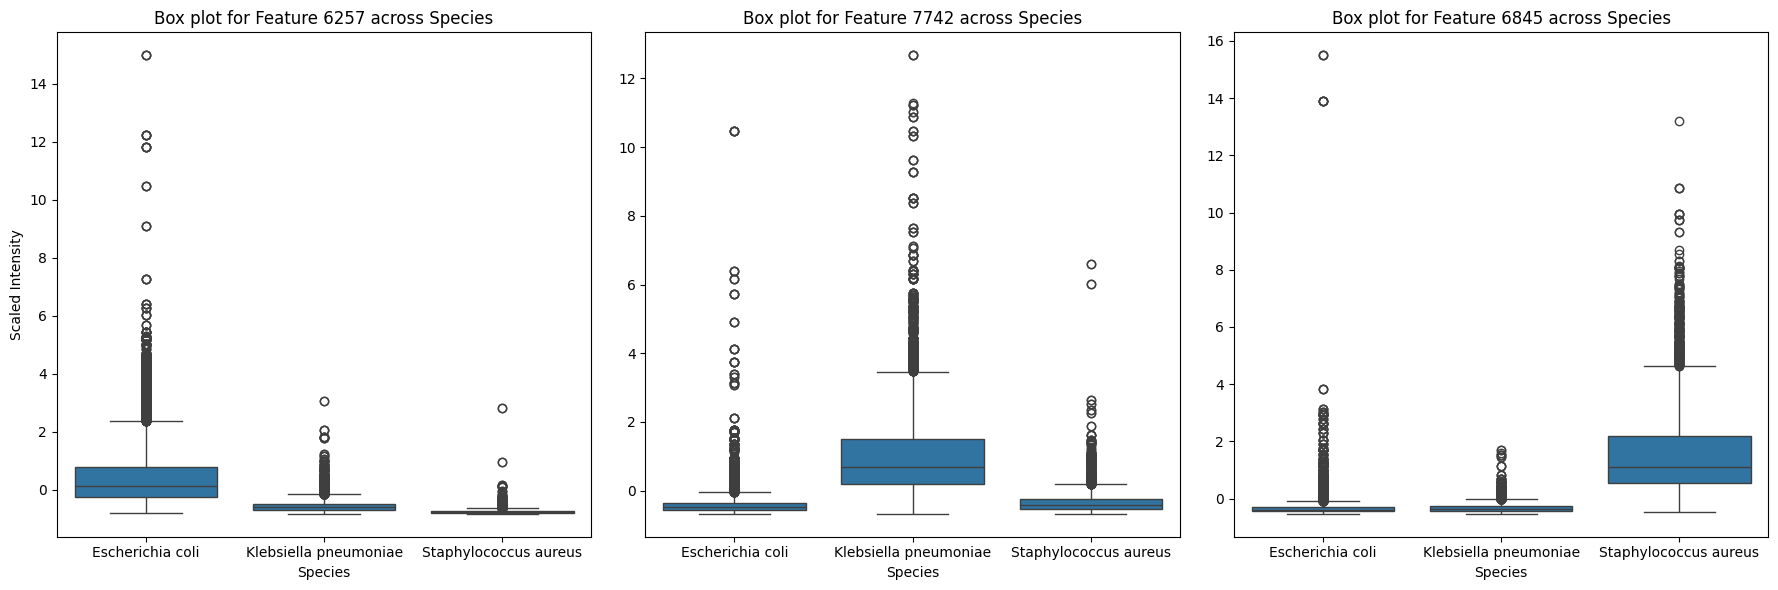

In [23]:
plt.figure(figsize=(18, 6))

# Feature 6257
plt.subplot(1, 3, 1)
sns.boxplot(data=data, x='Species', y='6257')
plt.title('Box plot for Feature 6257 across Species')
plt.ylabel('Scaled Intensity')  

# Feature 7742
plt.subplot(1, 3, 2)
sns.boxplot(data=data, x='Species', y='7742')
plt.title('Box plot for Feature 7742 across Species')
plt.ylabel('')  

# Feature 6845
plt.subplot(1, 3, 3)
sns.boxplot(data=data, x='Species', y='6845')
plt.title('Box plot for Feature 6845 across Species')
plt.ylabel('') 

plt.tight_layout()
plt.show()

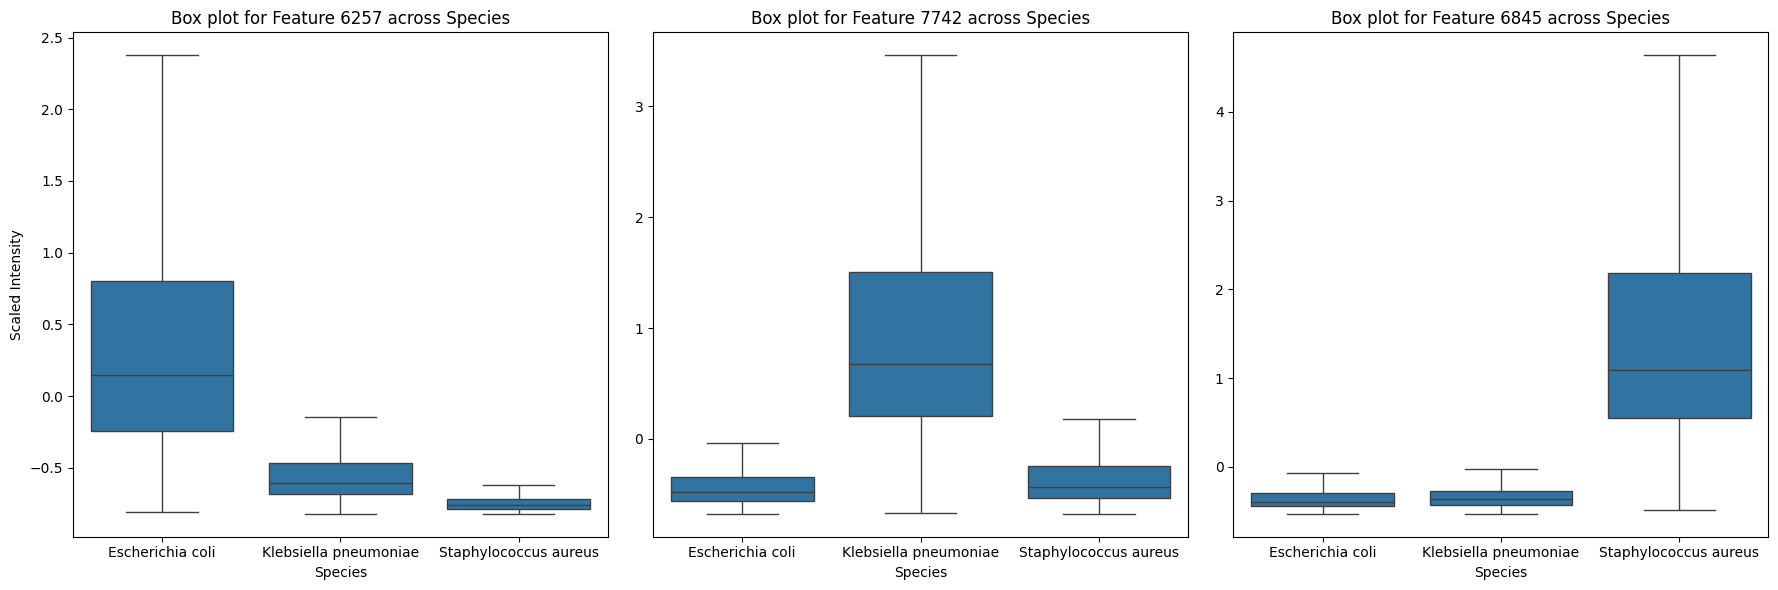

In [24]:
plt.figure(figsize=(18, 6))

# Feature 6257
plt.subplot(1, 3, 1)
sns.boxplot(data=data, x='Species', y='6257', showfliers=False)
plt.title('Box plot for Feature 6257 across Species')
plt.ylabel('Scaled Intensity')  

# Feature 7742
plt.subplot(1, 3, 2)
sns.boxplot(data=data, x='Species', y='7742', showfliers=False)
plt.title('Box plot for Feature 7742 across Species')
plt.ylabel('')  

# Feature 6845
plt.subplot(1, 3, 3)
sns.boxplot(data=data, x='Species', y='6845', showfliers=False)
plt.title('Box plot for Feature 6845 across Species')
plt.ylabel('')  

plt.tight_layout()
plt.savefig('Features_vs_species_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

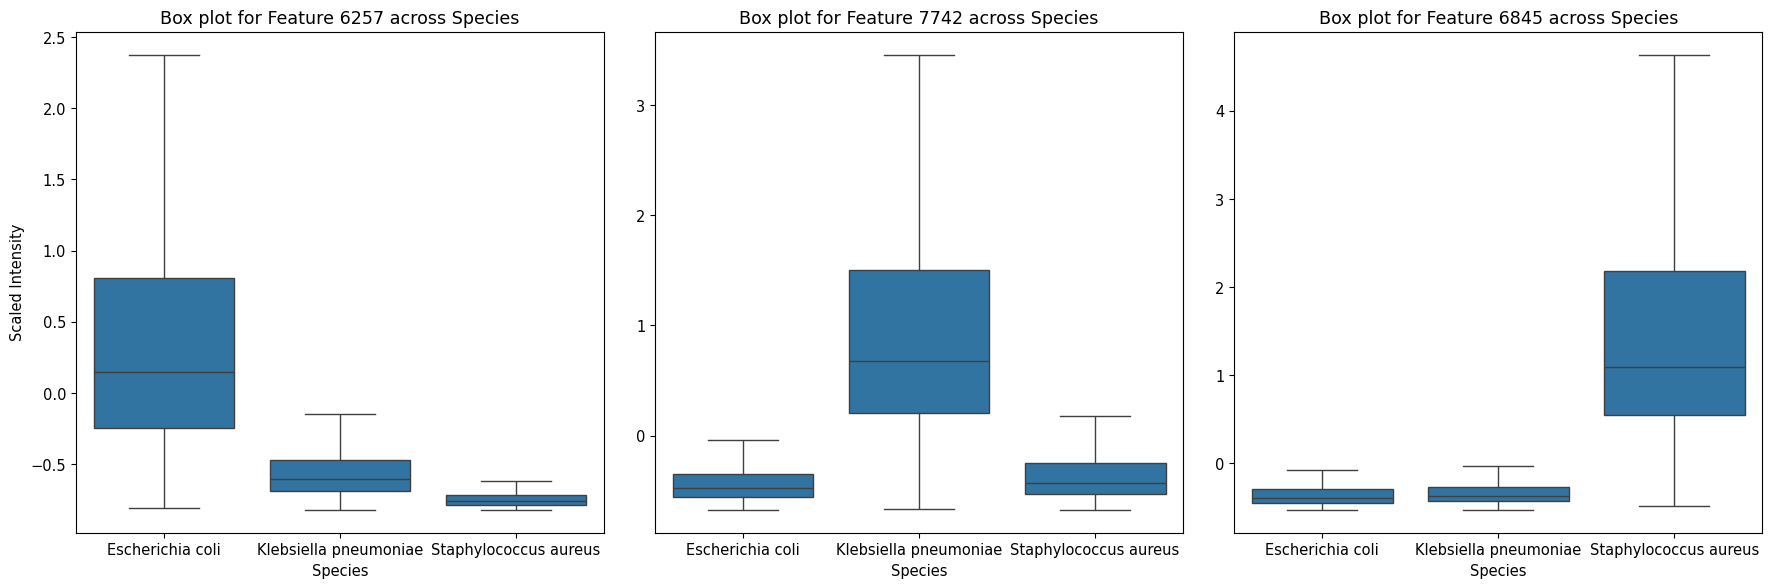

In [30]:
plt.rcParams.update({'font.size': 10.5})

plt.figure(figsize=(18, 6))

# Feature 6257
plt.subplot(1, 3, 1)
sns.boxplot(data=data, x='Species', y='6257', showfliers=False)
plt.title('Box plot for Feature 6257 across Species')
plt.ylabel('Scaled Intensity')  

# Feature 7742
plt.subplot(1, 3, 2)
sns.boxplot(data=data, x='Species', y='7742', showfliers=False)
plt.title('Box plot for Feature 7742 across Species')
plt.ylabel('')  

# Feature 6845
plt.subplot(1, 3, 3)
sns.boxplot(data=data, x='Species', y='6845', showfliers=False)
plt.title('Box plot for Feature 6845 across Species')
plt.ylabel('') 

plt.tight_layout()
plt.show()

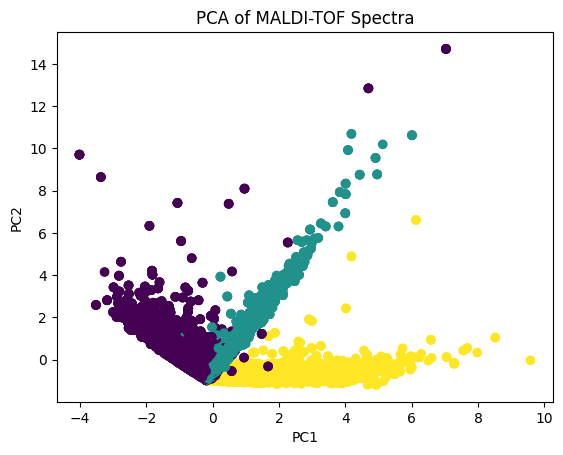

In [233]:
pca_3 = PCA(n_components=2)
pca_3_result = pca.fit_transform(X_train_selected_3)

plt.scatter(pca_3_result[:, 0], pca_3_result[:, 1], c=y_train_species_comb, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of MALDI-TOF Spectra')
plt.show()

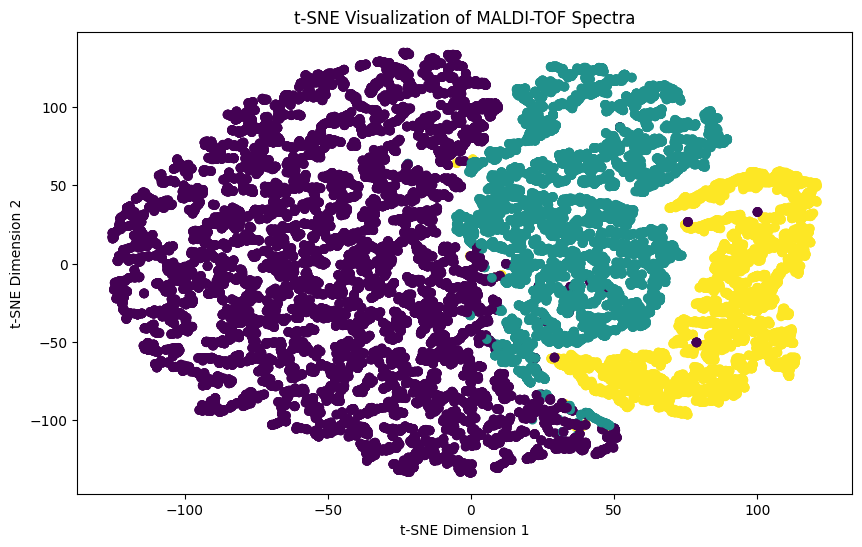

In [234]:
tsne_3 = TSNE(n_components=2, random_state=42)
tsne_3_results = tsne.fit_transform(X_train_selected_3)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_3_results[:, 0], tsne_3_results[:, 1], c=y_train_species_comb, cmap='viridis')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of MALDI-TOF Spectra')
plt.show()

## Feature selection with Lasso (switched to PCA)

In [55]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=40000)

In [56]:
%%time
lasso_cv.fit(X_train_comb_scaled, y_train_species_comb)

KeyboardInterrupt: 

The code above was running very long ( >1h), tried ElasticNet, it was also slow, so I switched to PCA

### PCA + RF comparison

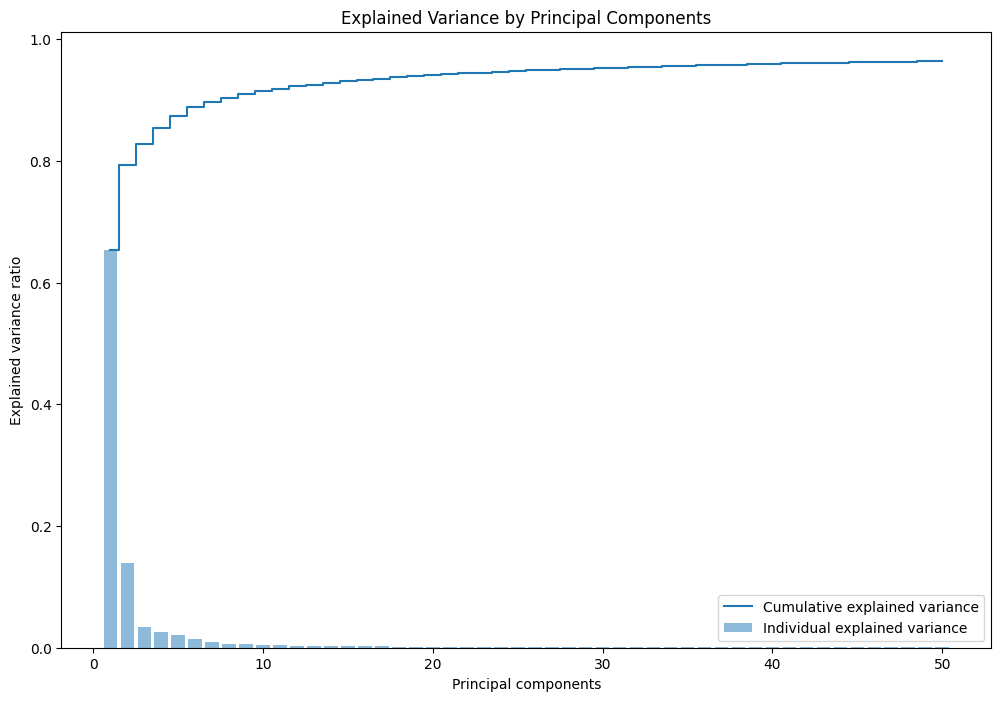

In [134]:
n_components = 50

# Fit PCA with 50 components
pca_50 = PCA(n_components=n_components)
X_train_pca_50 = pca_50.fit_transform(X_train_comb_scaled)
X_valid_pca_50 = pca_50.transform(X_valid_comb_scaled)

# Variance explained by each component
explained_variance_ratio = pca_50.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance = explained_variance_ratio.cumsum()

# Plotting the variance explained
plt.figure(figsize=(12, 8))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Explained Variance by Principal Components')
plt.show()

In [145]:
pca = PCA(n_components=10)  
X_train_pca = pca.fit_transform(X_train_comb_scaled)
X_valid_pca = pca.transform(X_valid_comb_scaled)
X_test_pca = pca.transform(X_test_comb_scaled)

rf_model_after_d_red = RandomForestClassifier(**best_params, random_state=42)
results_rf_model_species_dim = evaluate_model_with_time(rf_model_after_d_red, 
                                          X_train_pca, y_train_species_comb, 
                                          X_valid_pca, y_valid_species_comb,
                                          X_test_pca, y_test_species_comb, task=1)
results_rf_model_species_dim

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,1.0,0.999537,0.999537,0 min 4 sec
1,Balanced Accuracy,1.0,0.999138,0.999102,0 min 4 sec
2,Precision (Weighted),1.0,0.999538,0.999538,0 min 4 sec
3,Recall (Weighted),1.0,0.999537,0.999537,0 min 4 sec
4,F1 Score (Weighted),1.0,0.999537,0.999537,0 min 4 sec
5,AUPRC,1.0,0.999999,0.999999,0 min 4 sec


In [146]:
pca_7 = PCA(n_components=7)  
X_train_pca_7 = pca_7.fit_transform(X_train_comb_scaled)
X_valid_pca_7 = pca_7.transform(X_valid_comb_scaled)
X_test_pca_7 = pca_7.transform(X_test_comb_scaled)

rf_model_after_d_red_7 = RandomForestClassifier(**best_params, random_state=42)
results_rf_model_species_dim_7 = evaluate_model_with_time(rf_model_after_d_red_7, 
                                          X_train_pca_7, y_train_species_comb, 
                                          X_valid_pca_7, y_valid_species_comb, 
                                          X_test_pca_7, y_test_species_comb, task=1)
results_rf_model_species_dim_7

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,1.0,0.999537,0.999537,0 min 3 sec
1,Balanced Accuracy,1.0,0.999138,0.999102,0 min 3 sec
2,Precision (Weighted),1.0,0.999538,0.999538,0 min 3 sec
3,Recall (Weighted),1.0,0.999537,0.999537,0 min 3 sec
4,F1 Score (Weighted),1.0,0.999537,0.999537,0 min 3 sec
5,AUPRC,1.0,0.999999,1.000000,0 min 3 sec


In [147]:
pca_6 = PCA(n_components=6)  
X_train_pca_6 = pca_6.fit_transform(X_train_comb_scaled)
X_valid_pca_6 = pca_6.transform(X_valid_comb_scaled)
X_test_pca_6 = pca_6.transform(X_test_comb_scaled)

rf_model_after_d_red_6 = RandomForestClassifier(**best_params, random_state=42)
results_rf_model_species_dim_6 = evaluate_model_with_time(rf_model_after_d_red_6, 
                                                          X_train_pca_6, y_train_species_comb, 
                                                          X_valid_pca_6, y_valid_species_comb,
                                                        X_test_pca_6, y_test_species_comb, task=1)
results_rf_model_species_dim_6

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,1.0,0.999383,0.999383,0 min 3 sec
1,Balanced Accuracy,1.0,0.998851,0.998802,0 min 3 sec
2,Precision (Weighted),1.0,0.999384,0.999384,0 min 3 sec
3,Recall (Weighted),1.0,0.999383,0.999383,0 min 3 sec
4,F1 Score (Weighted),1.0,0.999383,0.999383,0 min 3 sec
5,AUPRC,1.0,1.000000,0.999999,0 min 3 sec


In [148]:
pca_5 = PCA(n_components=5)  
X_train_pca_5 = pca_5.fit_transform(X_train_comb_scaled)
X_valid_pca_5 = pca_5.transform(X_valid_comb_scaled)
X_test_pca_5 = pca_5.transform(X_test_comb_scaled)

rf_model_after_d_red_5 = RandomForestClassifier(**best_params, random_state=42)
results_rf_model_species_dim_5 = evaluate_model_with_time(rf_model_after_d_red_5, 
                                                          X_train_pca_5, y_train_species_comb, 
                                                          X_valid_pca_5, y_valid_species_comb,
                                                          X_test_pca_5, y_test_species_comb, task=1)
results_rf_model_species_dim_5

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,1.0,0.996761,0.995837,0 min 3 sec
1,Balanced Accuracy,1.0,0.996571,0.995006,0 min 3 sec
2,Precision (Weighted),1.0,0.996761,0.995838,0 min 3 sec
3,Recall (Weighted),1.0,0.996761,0.995837,0 min 3 sec
4,F1 Score (Weighted),1.0,0.996760,0.995834,0 min 3 sec
5,AUPRC,1.0,0.999751,0.999754,0 min 3 sec


In [149]:
pca_3 = PCA(n_components=3)  
X_train_pca_3 = pca_3.fit_transform(X_train_comb_scaled)
X_valid_pca_3 = pca_3.transform(X_valid_comb_scaled)
X_test_pca_3 = pca_3.transform(X_test_comb_scaled)

rf_model_after_d_red_3 = RandomForestClassifier(**best_params, random_state=42)
results_rf_model_species_dim_3 = evaluate_model_with_time(rf_model_after_d_red_3, 
                                          X_train_pca_3, y_train_species_comb, 
                                          X_valid_pca_3, y_valid_species_comb, 
                                          X_test_pca_3, y_test_species_comb, task=1)
results_rf_model_species_dim_3

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,1.0,0.993677,0.993215,0 min 3 sec
1,Balanced Accuracy,1.0,0.992652,0.992603,0 min 3 sec
2,Precision (Weighted),1.0,0.993679,0.993218,0 min 3 sec
3,Recall (Weighted),1.0,0.993677,0.993215,0 min 3 sec
4,F1 Score (Weighted),1.0,0.993671,0.993205,0 min 3 sec
5,AUPRC,1.0,0.999250,0.999252,0 min 3 sec


In [150]:
pca_2 = PCA(n_components=2)  
X_train_pca_2 = pca_2.fit_transform(X_train_comb_scaled)
X_valid_pca_2 = pca_2.transform(X_valid_comb_scaled)
X_test_pca_2 = pca_2.transform(X_test_comb_scaled)

rf_model_after_d_red_2 = RandomForestClassifier(**best_params, random_state=42)
results_rf_model_species_dim_2 = evaluate_model_with_time(rf_model_after_d_red_2, 
                                          X_train_pca_2, y_train_species_comb, 
                                          X_valid_pca_2, y_valid_species_comb, 
                                          X_test_pca_2, y_test_species_comb, task=1)
results_rf_model_species_dim_2

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,0.999967,0.943553,0.951118,0 min 3 sec
1,Balanced Accuracy,0.999935,0.903132,0.911845,0 min 3 sec
2,Precision (Weighted),0.999967,0.944920,0.952215,0 min 3 sec
3,Recall (Weighted),0.999967,0.943553,0.951118,0 min 3 sec
4,F1 Score (Weighted),0.999967,0.940870,0.949076,0 min 3 sec
5,AUPRC,1.000000,0.980431,0.979660,0 min 3 sec


In [151]:
Components = [10, 6, 5, 3, 2]

rf_dim_red_combined_pca = pd.DataFrame()

for component, df in zip(Components, [results_rf_model_species_dim, results_rf_model_species_dim_6,
                                      results_rf_model_species_dim_5, results_rf_model_species_dim_3, results_rf_model_species_dim_2]):
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[component], df_selected.columns])
    rf_dim_red_combined_pca = pd.concat([rf_dim_red_combined_pca, df_selected], axis=1)

rf_dim_red_combined_pca.columns.names = ['The Number of Components', None]
rf_dim_red_combined_pca = rf_dim_red_combined_pca.round(4)
rf_dim_red_combined_pca

The Number of Components          10                              \
                         Train Score Validation Score Test Score   
Metric                                                             
Accuracy                         1.0           0.9995     0.9995   
Balanced Accuracy                1.0           0.9991     0.9991   
Precision (Weighted)             1.0           0.9995     0.9995   
Recall (Weighted)                1.0           0.9995     0.9995   
F1 Score (Weighted)              1.0           0.9995     0.9995   
AUPRC                            1.0           1.0000     1.0000   

The Number of Components                         6                    \
                         Execution Time Train Score Validation Score   
Metric                                                                 
Accuracy                    0 min 4 sec         1.0           0.9994   
Balanced Accuracy           0 min 4 sec         1.0           0.9989   
Precision (Weighted)        0 min 4 sec         1.0           0.9994   
Recall (Weighted)           0 min 4 sec         1.0           0.9994   
F1 Score (Weighted)         0 min 4 sec         1.0           0.9994   
AUPRC                       0 min 4 sec         1.0           1.0000   

The Number of Components                                    5   \
                         Test Score Execution Time Train Score   
Metric                                                           
Accuracy                     0.9994    0 min 3 sec         1.0   
Balanced Accuracy            0.9988    0 min 3 sec         1.0   
Precision (Weighted)         0.9994    0 min 3 sec         1.0   
Recall (Weighted)            0.9994    0 min 3 sec         1.0   
F1 Score (Weighted)          0.9994    0 min 3 sec         1.0   
AUPRC                        1.0000    0 min 3 sec         1.0   

The Number of Components                                             \
                         Validation Score Test Score Execution Time   
Metric                                                                
Accuracy                           0.9968     0.9958    0 min 3 sec   
Balanced Accuracy                  0.9966     0.9950    0 min 3 sec   
Precision (Weighted)               0.9968     0.9958    0 min 3 sec   
Recall (Weighted)                  0.9968     0.9958    0 min 3 sec   
F1 Score (Weighted)                0.9968     0.9958    0 min 3 sec   
AUPRC                              0.9998     0.9998    0 min 3 sec   

The Number of Components          3                               \
                         Train Score Validation Score Test Score   
Metric                                                             
Accuracy                         1.0           0.9937     0.9932   
Balanced Accuracy                1.0           0.9927     0.9926   
Precision (Weighted)             1.0           0.9937     0.9932   
Recall (Weighted)                1.0           0.9937     0.9932   
F1 Score (Weighted)              1.0           0.9937     0.9932   
AUPRC                            1.0           0.9993     0.9993   

The Number of Components                         2                    \
                         Execution Time Train Score Validation Score   
Metric                                                                 
Accuracy                    0 min 3 sec      1.0000           0.9436   
Balanced Accuracy           0 min 3 sec      0.9999           0.9031   
Precision (Weighted)        0 min 3 sec      1.0000           0.9449   
Recall (Weighted)           0 min 3 sec      1.0000           0.9436   
F1 Score (Weighted)         0 min 3 sec      1.0000           0.9409   
AUPRC                       0 min 3 sec      1.0000           0.9804   

The Number of Components                            
                         Test Score Execution Time  
Metric                                              
Accuracy                     0.9511    0 min 3 sec  
Balanced Accuracy            

In [152]:
rf_dim_red_combined_pca.T

Metric                                        Accuracy Balanced Accuracy  \
The Number of Components                                                   
10                       Train Score               1.0               1.0   
                         Validation Score       0.9995            0.9991   
                         Test Score             0.9995            0.9991   
                         Execution Time    0 min 4 sec       0 min 4 sec   
6                        Train Score               1.0               1.0   
                         Validation Score       0.9994            0.9989   
                         Test Score             0.9994            0.9988   
                         Execution Time    0 min 3 sec       0 min 3 sec   
5                        Train Score               1.0               1.0   
                         Validation Score       0.9968            0.9966   
                         Test Score             0.9958             0.995   
                         Execution Time    0 min 3 sec       0 min 3 sec   
3                        Train Score               1.0               1.0   
                         Validation Score       0.9937            0.9927   
                         Test Score             0.9932            0.9926   
                         Execution Time    0 min 3 sec       0 min 3 sec   
2                        Train Score               1.0            0.9999   
                         Validation Score       0.9436            0.9031   
                         Test Score             0.9511            0.9118   
                         Execution Time    0 min 3 sec       0 min 3 sec   

Metric                                    Precision (Weighted)  \
The Number of Components                                         
10                       Train Score                       1.0   
                         Validation Score               0.9995   
                         Test Score                     0.9995   
                         Execution Time            0 min 4 sec   
6                        Train Score                       1.0   
                         Validation Score               0.9994   
                         Test Score                     0.9994   
                         Execution Time            0 min 3 sec   
5                        Train Score                       1.0   
                         Validation Score               0.9968   
                         Test Score                     0.9958   
                         Execution Time            0 min 3 sec   
3                        Train Score                       1.0   
                         Validation Score               0.9937   
                         Test Score                     0.9932   
                         Execution Time            0 min 3 sec   
2                        Train Score                       1.0   
                         Validation Score               0.9449   
                         Test Score                     0.9522   
                         Execution Time            0 min 3 sec   

Metric                                    Recall (Weighted)  \
The Number of Components                                      
10                       Train Score                    1.0   
                         Validation Score            0.9995   
                         Test Score                  0.9995   
                         Execution Time         0 min 4 sec   
6                        Train Score                    1.0   
                         Validation Score            0.9994   
                         Test Score                  0.9994   
                         Execution Time         0 min 3 sec   
5                        Train Score                    1.0   
                         Validation Score            0.9968   
                         Test Score                  0.9958   
                         Execution Time         0 min 3

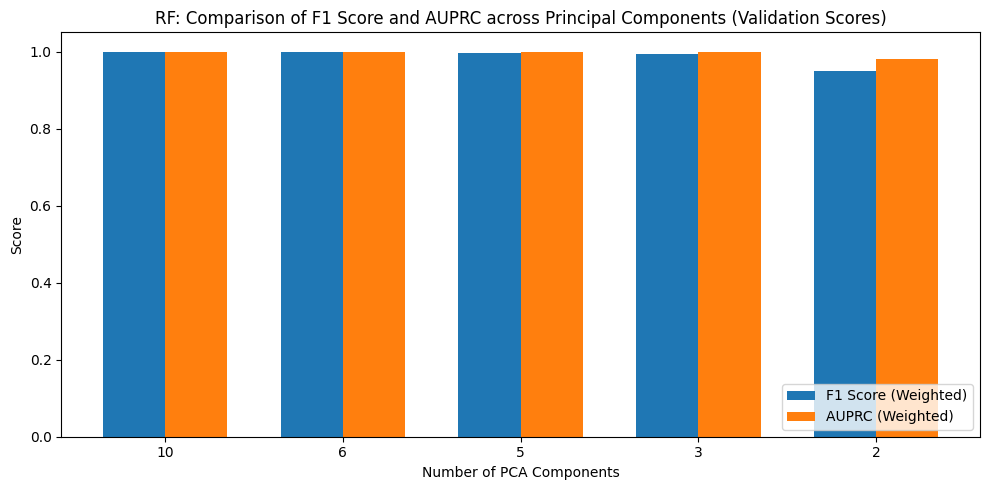

In [153]:
# The number of PCA components
components = [10, 6, 5, 3, 2]  

# Extract F1 Scores and AUPRC for each component
component_f1_scores = [rf_dim_red_combined_pca.loc['F1 Score (Weighted)', (component, 'Test Score')] for component in components]
component_auprc_scores = [rf_dim_red_combined_pca.loc['AUPRC', (component, 'Test Score')] for component in components]

# Set up plotting parameters
bar_width = 0.35
index = np.arange(len(components)) 

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting F1 scores and AUPRC side by side for each PCA component
ax.bar(index - bar_width/2, component_f1_scores, bar_width, label='F1 Score (Weighted)')
ax.bar(index + bar_width/2, component_auprc_scores, bar_width, label='AUPRC (Weighted)')

# Set the labels and titles
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Score')
ax.set_title('RF: Comparison of F1 Score and AUPRC across Principal Components (Validation Scores)')
ax.set_xticks(index)
ax.set_xticklabels(components, rotation=0)  
ax.legend(loc='lower right')
fig.savefig('RF_pca_dim_red_comparison.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

### PCA + SVM comparison

In [154]:
svm_ovr_model_pca_10 = svm.SVC(**best_params_svm_1, decision_function_shape='ovr', probability=True, random_state=42)
results_svm_model_species_pca_10 = evaluate_model_with_time(svm_ovr_model_pca_10,
                                                        X_train_pca, y_train_species_comb, 
                                                        X_valid_pca, y_valid_species_comb, 
                                                        X_test_pca, y_test_species_comb, task=1)
results_svm_model_species_pca_10

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,0.997223,0.996761,0.998458,0 min 5 sec
1,Balanced Accuracy,0.996674,0.996185,0.998245,0 min 5 sec
2,Precision (Weighted),0.997226,0.996765,0.998458,0 min 5 sec
3,Recall (Weighted),0.997223,0.996761,0.998458,0 min 5 sec
4,F1 Score (Weighted),0.997222,0.996761,0.998458,0 min 5 sec
5,AUPRC,0.999584,0.999948,0.999760,0 min 5 sec


In [155]:
svm_ovr_model_pca_7 = svm.SVC(**best_params_svm_1, decision_function_shape='ovr', probability=True, random_state=42)
results_svm_model_species_pca_7 = evaluate_model_with_time(svm_ovr_model_pca_7,
                                                        X_train_pca_7, y_train_species_comb, 
                                                        X_valid_pca_7, y_valid_species_comb, 
                                                        X_test_pca_7, y_test_species_comb, task=1)
results_svm_model_species_pca_7

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,0.996892,0.996299,0.997070,0 min 5 sec
1,Balanced Accuracy,0.996888,0.996202,0.997323,0 min 5 sec
2,Precision (Weighted),0.996892,0.996299,0.997072,0 min 5 sec
3,Recall (Weighted),0.996892,0.996299,0.997070,0 min 5 sec
4,F1 Score (Weighted),0.996892,0.996299,0.997071,0 min 5 sec
5,AUPRC,0.998999,0.999855,0.999291,0 min 5 sec


In [156]:
svm_ovr_model_pca_6 = svm.SVC(**best_params_svm_1, decision_function_shape='ovr', probability=True, random_state=42)
results_svm_model_species_pca_6 = evaluate_model_with_time(svm_ovr_model_pca_6,
                                                        X_train_pca_6, y_train_species_comb, 
                                                        X_valid_pca_6, y_valid_species_comb, 
                                                        X_test_pca_6, y_test_species_comb, task=1)
results_svm_model_species_pca_6

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,0.995570,0.995527,0.996453,0 min 5 sec
1,Balanced Accuracy,0.995886,0.995641,0.996961,0 min 5 sec
2,Precision (Weighted),0.995572,0.995533,0.996460,0 min 5 sec
3,Recall (Weighted),0.995570,0.995527,0.996453,0 min 5 sec
4,F1 Score (Weighted),0.995570,0.995529,0.996455,0 min 5 sec
5,AUPRC,0.998827,0.998590,0.997373,0 min 5 sec


In [157]:
svm_ovr_model_pca_5 = svm.SVC(**best_params_svm_1, decision_function_shape='ovr', probability=True, random_state=42)
results_svm_model_species_pca_5 = evaluate_model_with_time(svm_ovr_model_pca_5,
                                                        X_train_pca_5, y_train_species_comb, 
                                                        X_valid_pca_5, y_valid_species_comb, 
                                                        X_test_pca_5, y_test_species_comb, task=1)
results_svm_model_species_pca_5

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,0.793143,0.793029,0.797070,0 min 59 sec
1,Balanced Accuracy,0.762651,0.765404,0.767745,0 min 59 sec
2,Precision (Weighted),0.787854,0.790689,0.790521,0 min 59 sec
3,Recall (Weighted),0.793143,0.793029,0.797070,0 min 59 sec
4,F1 Score (Weighted),0.769247,0.770125,0.775572,0 min 59 sec
5,AUPRC,0.864539,0.867168,0.867301,0 min 59 sec


In [158]:
svm_ovr_model_pca_3 = svm.SVC(**best_params_svm_1, decision_function_shape='ovr', probability=True, random_state=42)
results_svm_model_species_pca_3 = evaluate_model_with_time(svm_ovr_model_pca_3,
                                                        X_train_pca_3, y_train_species_comb, 
                                                        X_valid_pca_3, y_valid_species_comb, 
                                                        X_test_pca_3, y_test_species_comb, task=1)
results_svm_model_species_pca_3

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,0.758364,0.757403,0.762837,1 min 4 sec
1,Balanced Accuracy,0.712018,0.712475,0.714748,1 min 4 sec
2,Precision (Weighted),0.753016,0.762252,0.759910,1 min 4 sec
3,Recall (Weighted),0.758364,0.757403,0.762837,1 min 4 sec
4,F1 Score (Weighted),0.707443,0.704159,0.712850,1 min 4 sec
5,AUPRC,0.829566,0.837048,0.830915,1 min 4 sec


In [159]:
svm_ovr_model_pca_2 = svm.SVC(**best_params_svm, decision_function_shape='ovr', probability=True, random_state=42)
results_svm_model_species_pca_2 = evaluate_model_with_time(svm_ovr_model_pca_2,
                                                        X_train_pca_2, y_train_species_comb, 
                                                        X_valid_pca_2, y_valid_species_comb, 
                                                        X_test_pca_2, y_test_species_comb, task=1)
results_svm_model_species_pca_2

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,0.567641,0.552745,0.567926,1 min 19 sec
1,Balanced Accuracy,0.333333,0.333333,0.333333,1 min 19 sec
2,Precision (Weighted),0.322216,0.305527,0.322540,1 min 19 sec
3,Recall (Weighted),0.567641,0.552745,0.567926,1 min 19 sec
4,F1 Score (Weighted),0.411084,0.393532,0.411422,1 min 19 sec
5,AUPRC,0.498719,0.485742,0.502289,1 min 19 sec


In [160]:
Components = [10, 6, 5, 3, 2]

svm_dim_red_combined_pca = pd.DataFrame()

for component, df in zip(Components, [results_svm_model_species_pca_10, results_svm_model_species_pca_6, results_svm_model_species_pca_5,
                                      results_svm_model_species_pca_3, results_svm_model_species_pca_2]):
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[component], df_selected.columns])
    svm_dim_red_combined_pca = pd.concat([svm_dim_red_combined_pca, df_selected], axis=1)

svm_dim_red_combined_pca.columns.names = ['The Number of Components', None]
svm_dim_red_combined_pca = svm_dim_red_combined_pca.round(4)
svm_dim_red_combined_pca

The Number of Components          10                              \
                         Train Score Validation Score Test Score   
Metric                                                             
Accuracy                      0.9972           0.9968     0.9985   
Balanced Accuracy             0.9967           0.9962     0.9982   
Precision (Weighted)          0.9972           0.9968     0.9985   
Recall (Weighted)             0.9972           0.9968     0.9985   
F1 Score (Weighted)           0.9972           0.9968     0.9985   
AUPRC                         0.9996           0.9999     0.9998   

The Number of Components                         6                    \
                         Execution Time Train Score Validation Score   
Metric                                                                 
Accuracy                    0 min 5 sec      0.9956           0.9955   
Balanced Accuracy           0 min 5 sec      0.9959           0.9956   
Precision (Weighted)        0 min 5 sec      0.9956           0.9955   
Recall (Weighted)           0 min 5 sec      0.9956           0.9955   
F1 Score (Weighted)         0 min 5 sec      0.9956           0.9955   
AUPRC                       0 min 5 sec      0.9988           0.9986   

The Number of Components                                    5   \
                         Test Score Execution Time Train Score   
Metric                                                           
Accuracy                     0.9965    0 min 5 sec      0.7931   
Balanced Accuracy            0.9970    0 min 5 sec      0.7627   
Precision (Weighted)         0.9965    0 min 5 sec      0.7879   
Recall (Weighted)            0.9965    0 min 5 sec      0.7931   
F1 Score (Weighted)          0.9965    0 min 5 sec      0.7692   
AUPRC                        0.9974    0 min 5 sec      0.8645   

The Number of Components                                             \
                         Validation Score Test Score Execution Time   
Metric                                                                
Accuracy                           0.7930     0.7971   0 min 59 sec   
Balanced Accuracy                  0.7654     0.7677   0 min 59 sec   
Precision (Weighted)               0.7907     0.7905   0 min 59 sec   
Recall (Weighted)                  0.7930     0.7971   0 min 59 sec   
F1 Score (Weighted)                0.7701     0.7756   0 min 59 sec   
AUPRC                              0.8672     0.8673   0 min 59 sec   

The Number of Components          3                               \
                         Train Score Validation Score Test Score   
Metric                                                             
Accuracy                      0.7584           0.7574     0.7628   
Balanced Accuracy             0.7120           0.7125     0.7147   
Precision (Weighted)          0.7530           0.7623     0.7599   
Recall (Weighted)             0.7584           0.7574     0.7628   
F1 Score (Weighted)           0.7074           0.7042     0.7129   
AUPRC                         0.8296           0.8370     0.8309   

The Number of Components                         2                    \
                         Execution Time Train Score Validation Score   
Metric                                                                 
Accuracy                    1 min 4 sec      0.5676           0.5527   
Balanced Accuracy           1 min 4 sec      0.3333           0.3333   
Precision (Weighted)        1 min 4 sec      0.3222           0.3055   
Recall (Weighted)           1 min 4 sec      0.5676           0.5527   
F1 Score (Weighted)         1 min 4 sec      0.4111           0.3935   
AUPRC                       1 min 4 sec      0.4987           0.4857   

The Number of Components                            
                         Test Score Execution Time  
Metric                                              
Accuracy                     0.5679   1 min 19 sec  
Balanced Accuracy            

In [161]:
svm_dim_red_combined_pca.T

Metric                                         Accuracy Balanced Accuracy  \
The Number of Components                                                    
10                       Train Score             0.9972            0.9967   
                         Validation Score        0.9968            0.9962   
                         Test Score              0.9985            0.9982   
                         Execution Time     0 min 5 sec       0 min 5 sec   
6                        Train Score             0.9956            0.9959   
                         Validation Score        0.9955            0.9956   
                         Test Score              0.9965             0.997   
                         Execution Time     0 min 5 sec       0 min 5 sec   
5                        Train Score             0.7931            0.7627   
                         Validation Score         0.793            0.7654   
                         Test Score              0.7971            0.7677   
                         Execution Time    0 min 59 sec      0 min 59 sec   
3                        Train Score             0.7584             0.712   
                         Validation Score        0.7574            0.7125   
                         Test Score              0.7628            0.7147   
                         Execution Time     1 min 4 sec       1 min 4 sec   
2                        Train Score             0.5676            0.3333   
                         Validation Score        0.5527            0.3333   
                         Test Score              0.5679            0.3333   
                         Execution Time    1 min 19 sec      1 min 19 sec   

Metric                                    Precision (Weighted)  \
The Number of Components                                         
10                       Train Score                    0.9972   
                         Validation Score               0.9968   
                         Test Score                     0.9985   
                         Execution Time            0 min 5 sec   
6                        Train Score                    0.9956   
                         Validation Score               0.9955   
                         Test Score                     0.9965   
                         Execution Time            0 min 5 sec   
5                        Train Score                    0.7879   
                         Validation Score               0.7907   
                         Test Score                     0.7905   
                         Execution Time           0 min 59 sec   
3                        Train Score                     0.753   
                         Validation Score               0.7623   
                         Test Score                     0.7599   
                         Execution Time            1 min 4 sec   
2                        Train Score                    0.3222   
                         Validation Score               0.3055   
                         Test Score                     0.3225   
                         Execution Time           1 min 19 sec   

Metric                                    Recall (Weighted)  \
The Number of Components                                      
10                       Train Score                 0.9972   
                         Validation Score            0.9968   
                         Test Score                  0.9985   
                         Execution Time         0 min 5 sec   
6                        Train Score                 0.9956   
                         Validation Score            0.9955   
                         Test Score                  0.9965   
                         Execution Time         0 min 5 sec   
5                        Train Score                 0.7931   
                         Validation Score             0.793   
                         Test Score                  0.7971   
                         Executio

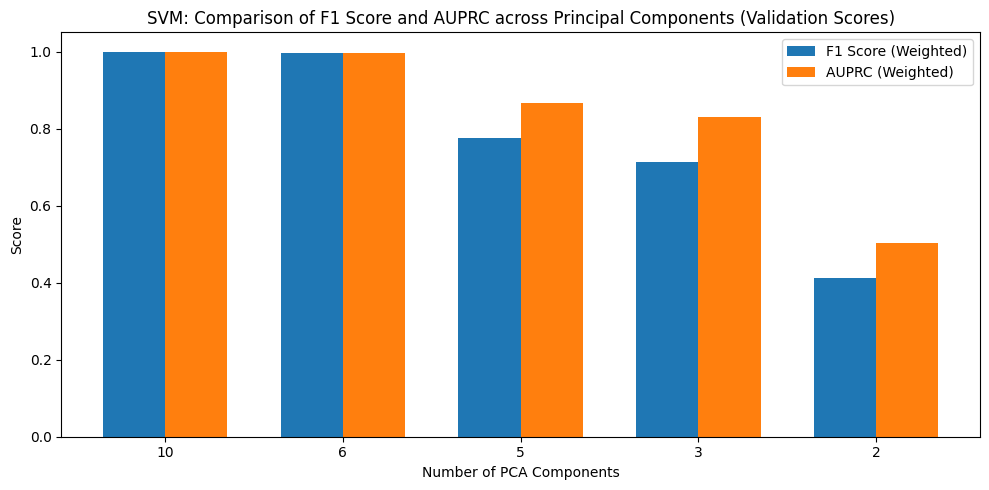

In [162]:
# The number of PCA components
components = [10, 6, 5, 3, 2]

# Extract F1 Scores and AUPRC for each component from the SVM-specific DataFrame
component_f1_scores = [svm_dim_red_combined_pca.loc['F1 Score (Weighted)', (component, 'Test Score')] for component in components]
component_auprc_scores = [svm_dim_red_combined_pca.loc['AUPRC', (component, 'Test Score')] for component in components]

# Set up plotting parameters
bar_width = 0.35
index = np.arange(len(components))  

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting F1 scores and AUPRC side by side for each PCA component
ax.bar(index - bar_width/2, component_f1_scores, bar_width, label='F1 Score (Weighted)')
ax.bar(index + bar_width/2, component_auprc_scores, bar_width, label='AUPRC (Weighted)')

# Set the labels and titles
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Score')
ax.set_title('SVM: Comparison of F1 Score and AUPRC across Principal Components (Validation Scores)')
ax.set_xticks(index)
ax.set_xticklabels(components, rotation=0)
ax.legend(loc='upper right')

fig.savefig('SVM_pca_dim_red_comparison.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## Feature transformation (LDA)

In [163]:
# Apply Linear Discriminant Analysis
lda_2 = LinearDiscriminantAnalysis(n_components=2)
X_train_comb_lda_2 = lda_2.fit_transform(X_train_comb_scaled, y_train_species_comb)
X_valid_comb_lda_2 = lda_2.transform(X_valid_comb_scaled)
X_test_comb_lda_2 = lda_2.transform(X_test_comb_scaled)

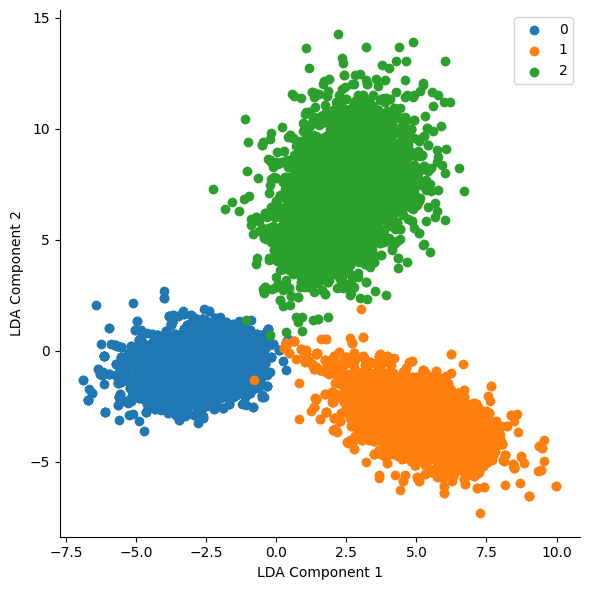

In [34]:
tmp_df = pd.DataFrame(X_train_comb_lda_2, columns=['LDA Component 1','LDA Component 2'])
tmp_df['Class']=y_train_species_comb

sns.FacetGrid(tmp_df, hue ="Class", height = 6).map(plt.scatter, 'LDA Component 1', 'LDA Component 2')
plt.legend(loc='upper right')

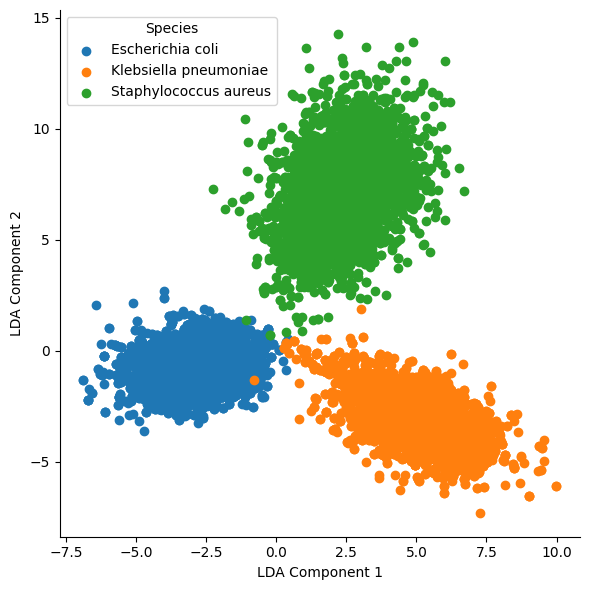

In [40]:
# Create a custom legend using species_mapping
custom_legend = {key: value for key, value in species_mapping.items() if key in tmp_df['Class'].unique()}

sns.FacetGrid(tmp_df, hue="Class", height=6).map(plt.scatter, 'LDA Component 1', 'LDA Component 2')

# Insert the custom legend
plt.legend(custom_legend.values(), title='Species')
plt.show()

### RF after LDA

In [164]:
rf_model_after_lda_2 = RandomForestClassifier(**best_params, random_state=42)
results_rf_model_after_lda_2 = evaluate_model_with_time(rf_model_after_lda_2, 
                                                  X_train_comb_lda_2, y_train_species_comb, 
                                                  X_valid_comb_lda_2, y_valid_species_comb, 
                                                  X_test_comb_lda_2, y_test_species_comb, task=1)
results_rf_model_after_lda_2

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,1.0,0.997224,0.995220,0 min 1 sec
1,Balanced Accuracy,1.0,0.995698,0.993734,0 min 1 sec
2,Precision (Weighted),1.0,0.997227,0.995219,0 min 1 sec
3,Recall (Weighted),1.0,0.997224,0.995220,0 min 1 sec
4,F1 Score (Weighted),1.0,0.997221,0.995219,0 min 1 sec
5,AUPRC,1.0,0.996449,0.996193,0 min 1 sec


### SVM after LDA

In [165]:
svm_model_ovr_after_lda_2 = svm.SVC(**best_params_svm_1, decision_function_shape='ovr', probability=True, random_state=42)
results_svm_model_ovr_after_lda_2  = evaluate_model_with_time(svm_model_ovr_after_lda_2,
                                                        X_train_comb_lda_2, y_train_species_comb, 
                                                        X_valid_comb_lda_2, y_valid_species_comb, 
                                                        X_test_comb_lda_2, y_test_species_comb, task=1)
results_svm_model_ovr_after_lda_2

,Metric,Train Score,Validation Score,Test Score,Execution Time
0,Accuracy,0.998909,0.992289,0.993678,0 min 2 sec
1,Balanced Accuracy,0.998478,0.988615,0.991974,0 min 2 sec
2,Precision (Weighted),0.998911,0.992311,0.993676,0 min 2 sec
3,Recall (Weighted),0.998909,0.992289,0.993678,0 min 2 sec
4,F1 Score (Weighted),0.998909,0.992276,0.993676,0 min 2 sec
5,AUPRC,0.999997,0.997517,0.998087,0 min 2 sec


In [166]:
combined_results_lda = pd.concat([results_rf_model_after_lda_2, results_svm_model_ovr_after_lda_2.iloc[:, 1:]], axis=1)

In [167]:
models = ['RF_LDA_2_Comp', 'SVM_LDA_2_Comp']

combined_results_lda_ = pd.DataFrame()

for model, df in zip(models, [results_rf_model_after_lda_2, results_svm_model_ovr_after_lda_2]):
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[model], df_selected.columns])
    combined_results_lda_ = pd.concat([combined_results_lda_, df_selected], axis=1)

combined_results_lda_.columns.names = ['Model', None]

combined_results_lda_

Model                RF_LDA_2_Comp                                             \
                       Train Score Validation Score Test Score Execution Time   
Metric                                                                          
Accuracy                       1.0         0.997224   0.995220    0 min 1 sec   
Balanced Accuracy              1.0         0.995698   0.993734    0 min 1 sec   
Precision (Weighted)           1.0         0.997227   0.995219    0 min 1 sec   
Recall (Weighted)              1.0         0.997224   0.995220    0 min 1 sec   
F1 Score (Weighted)            1.0         0.997221   0.995219    0 min 1 sec   
AUPRC                          1.0         0.996449   0.996193    0 min 1 sec   

Model                SVM_LDA_2_Comp                                             
                        Train Score Validation Score Test Score Execution Time  
Metric                                                                          
Accuracy                   0.998909         0.992289   0.993678    0 min 2 sec  
Balanced Accuracy          0.998478         0.988615   0.991974    0 min 2 sec  
Precision (Weighted)       0.998911         0.992311   0.993676    0 min 2 sec  
Recall (Weighted)          0.998909         0.992289   0.993678    0 min 2 sec  
F1 Score (Weighted)        0.998909         0.992276   0.993676    0 min 2 sec  
AUPRC                      0.999997         0.997517   0.998087    0 min 2 sec

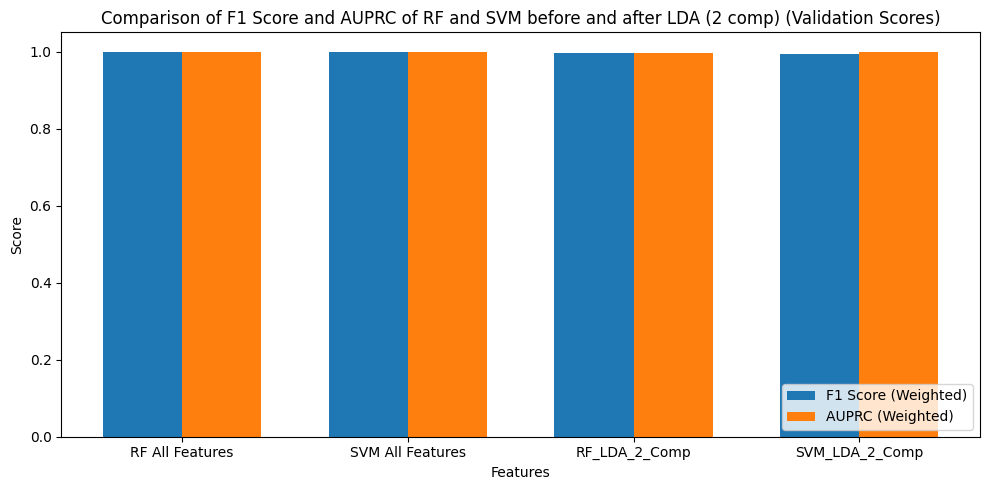

In [168]:
# Model names and feature set names
models = ['RF', 'SVM']
features = ['RF_LDA_2_Comp', 'SVM_LDA_2_Comp']

# Extract F1 Scores and AUPRC for each model
model_f1_scores = {model: combined_results_species.loc['F1 Score (Weighted)', (model, 'Test Score')] for model in models}
model_auprc_scores = {model: combined_results_species.loc['AUPRC', (model, 'Test Score')] for model in models}

# Extract F1 Scores and AUPRC for models after LDA
feature_f1_scores = [combined_results_lda_.loc['F1 Score (Weighted)', (feature, 'Test Score')] for feature in features]
feature_auprc_scores = [combined_results_lda_.loc['AUPRC', (feature, 'Test Score')] for feature in features]

# Include SVM model scores
feature_f1_scores.insert(0, model_f1_scores['SVM'])
feature_auprc_scores.insert(0, model_auprc_scores['SVM'])
features.insert(0, 'SVM')
features[0] = 'SVM All Features'

# Include RF model scores
feature_f1_scores.insert(0, model_f1_scores['RF'])
feature_auprc_scores.insert(0, model_auprc_scores['RF'])
features.insert(0, 'RF')
features[0] = 'RF All Features'

# Set up plotting parameters
bar_width = 0.35
index = np.arange(len(features))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting F1 scores and AUPRC side by side for each feature set and the RF model
ax.bar(index - bar_width/2, feature_f1_scores, bar_width, label='F1 Score (Weighted)')
ax.bar(index + bar_width/2, feature_auprc_scores, bar_width, label='AUPRC (Weighted)')

# Set the labels and titles
ax.set_xlabel('Features')
ax.set_ylabel('Score')
ax.set_title('Comparison of F1 Score and AUPRC of RF and SVM before and after LDA (2 comp) (Validation Scores)')
ax.set_xticks(index)
ax.set_xticklabels(features, rotation=0)
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Second task: classification of the resistance antibiotics

In [169]:
antibiotics = ['Ciprofloxacin', 'Ceftriaxone', 'Cefepime', 'Piperacillin', 'Tobramycin']

## Data preprocessing

### Y: label encoding

In [14]:
split_results.keys()

dict_keys(['Ciprofloxacin', 'Ceftriaxone', 'Cefepime', 'Piperacillin', 'Tobramycin'])

In [170]:
for x in split_results.values():
    del x['X_train']['species']
    del x['X_valid']['species']
    del x['X_test']['species']

In [171]:
for antibiotic in antibiotics:
    split_results[antibiotic]['y_train'] = split_results[antibiotic]['y_train'].astype(int)

In [172]:
for antibiotic in antibiotics:
    unique_values = split_results[antibiotic]['y_train'].unique()
    print(f"Unique values in y_train for {antibiotic}: {unique_values}")

Unique values in y_train for Ciprofloxacin: [0 1]
Unique values in y_train for Ceftriaxone: [0 1]
Unique values in y_train for Cefepime: [0 1]
Unique values in y_train for Piperacillin: [0 1]
Unique values in y_train for Tobramycin: [0 1]


### X: outlier detection

In [145]:
antibiotics = ['Ciprofloxacin', 'Ceftriaxone', 'Cefepime', 'Piperacillin', 'Tobramycin']

for antibiotic in antibiotics:
    X_train = split_results[antibiotic]['X_train']
    X_valid = split_results[antibiotic]['X_valid']
    
    iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
    outliers_iso_forest = iso_forest.fit_predict(X_train)
    
    scores_iso_forest = iso_forest.decision_function(X_train)
    
    num_outliers = sum(scores_iso_forest == -1)
    
    print(f"Number of outliers detected for {antibiotic}: {num_outliers}")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Number of outliers detected for Ciprofloxacin: 0
Number of outliers detected for Ceftriaxone: 0
Number of outliers detected for Cefepime: 0
Number of outliers detected for Piperacillin: 0
Number of outliers detected for Tobramycin: 0


In [146]:
for antibiotic in antibiotics:
    X_train = split_results[antibiotic]['X_train']
    X_valid = split_results[antibiotic]['X_valid']
    
    lof = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
    outliers_lof = lof.fit_predict(X_train)
    
    scores_lof = lof.negative_outlier_factor_
    
    num_outliers = sum(scores_lof == -1)
    
    print(f"Number of outliers detected for {antibiotic}: {num_outliers}")

Number of outliers detected for Ciprofloxacin: 0
Number of outliers detected for Ceftriaxone: 0
Number of outliers detected for Cefepime: 0
Number of outliers detected for Piperacillin: 0
Number of outliers detected for Tobramycin: 0


### X: Normalization

In [173]:
scaler = StandardScaler()

scaled_datasets = {} 

for antibiotic in antibiotics:
    X_train = split_results[antibiotic]['X_train']
    X_valid = split_results[antibiotic]['X_valid']
    X_test = split_results[antibiotic]['X_test']
    
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                                  columns=X_train.columns, 
                                  index=X_train.index)
    
    X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), 
                                  columns=X_valid.columns, 
                                  index=X_valid.index)
    
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                                 columns=X_test.columns, 
                                 index=X_test.index)
    
    scaled_datasets[antibiotic] = {'X_train_scaled': X_train_scaled,
                                   'X_valid_scaled': X_valid_scaled,
                                   'X_test_scaled': X_test_scaled}

In [174]:
scaled_datasets['Ciprofloxacin']['X_train_scaled']

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19970,19973,19976,19979,19982,19985,19988,19991,19994,19997
4417,-0.049848,-0.062575,-0.033781,-0.005632,-0.030540,0.011721,0.041802,0.069139,-0.020867,-0.037900,...,-0.175854,-0.157893,0.121994,0.106076,-0.186111,-0.148131,-0.359590,0.099599,-0.222172,-0.174915
1109,-0.647774,-0.654829,-0.660371,-0.634553,-0.638351,-0.667422,-0.644420,-0.650696,-0.645881,-0.645083,...,-0.085837,-0.522475,-0.334917,-0.316274,-0.414087,-0.377115,-0.285383,-0.495811,-0.462198,-0.345724
1757,-0.273436,-0.283741,-0.270745,-0.301954,-0.308989,-0.312618,-0.261790,-0.248485,-0.244428,-0.230041,...,0.785683,0.838631,0.615951,0.519894,0.485151,0.411609,0.765886,1.104353,0.568256,0.907773
7629,1.334412,1.040355,0.878626,0.766502,0.753026,0.946824,0.914375,0.974744,0.872728,1.019370,...,-0.527735,-0.522475,-0.532500,-0.546647,-0.540740,-0.542493,-0.532740,-0.533024,-0.536688,-0.546445
9068,-0.499110,-0.516242,-0.517069,-0.485842,-0.524584,-0.518710,-0.515012,-0.506622,-0.519153,-0.515413,...,-0.171762,-0.279421,0.084947,-0.418662,-0.464748,-0.432241,-0.347222,-0.384172,-0.102160,-0.348522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0.094531,0.163114,0.106501,0.103320,0.073267,0.129260,0.108988,0.055240,-0.009405,0.121399,...,6.845406,5.711878,7.160887,7.196443,6.847365,5.792743,8.038194,5.793205,5.662586,6.663364
4824,1.650005,1.715986,1.558539,1.402125,1.402471,1.365514,1.663090,1.530675,1.389152,1.509702,...,-0.527735,-0.522475,-0.532500,-0.546647,-0.540740,-0.542493,-0.532740,-0.533024,-0.536688,-0.545957
660,-0.457674,-0.462463,-0.454326,-0.443336,-0.473670,-0.467010,-0.426574,-0.453844,-0.464740,-0.457419,...,-0.294511,-0.461712,-0.322568,-0.265080,-0.426753,-0.288066,-0.285383,-0.326284,0.009576,-0.252946
2620,0.235922,0.166367,0.177102,0.217647,0.250321,0.226331,0.283698,0.220522,0.179653,0.228652,...,0.159661,0.595576,0.208436,0.630814,0.105191,0.487937,-0.013289,0.459326,0.605501,0.468577


# EDA

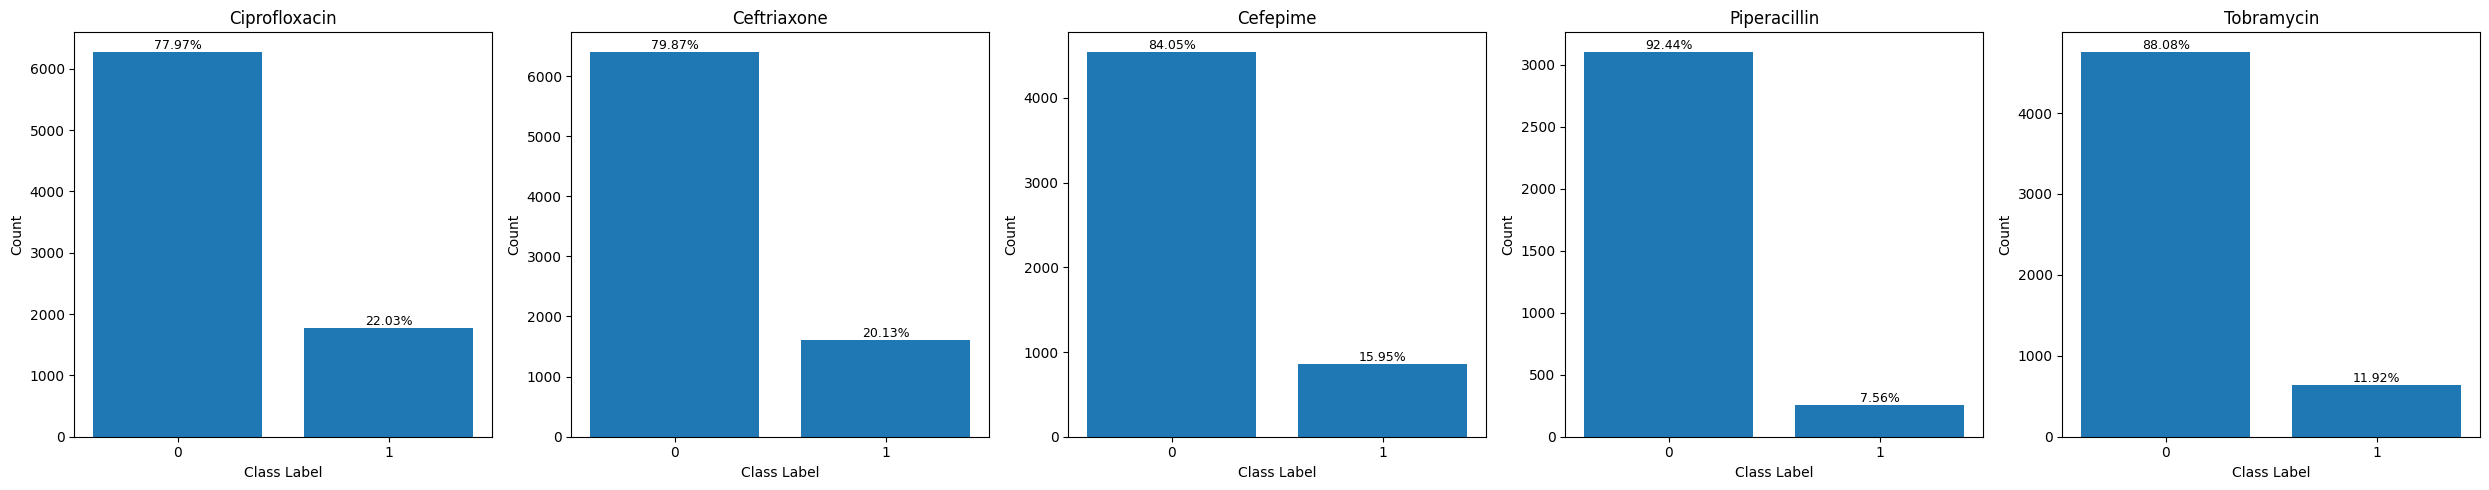

In [207]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))  
for i, antibiotic in enumerate(antibiotics):
    y_train_current = split_results[antibiotic]['y_train']
    
    counts = y_train_current.value_counts().sort_index()
    proportions = y_train_current.value_counts(normalize=True).sort_index()

    bars = axes[i].bar(counts.index, counts.values)

    for bar, proportion in zip(bars, proportions):
        yval = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2, yval, f'{proportion:.2%}', va='bottom', ha='center', fontsize=9, color='black')

    axes[i].set_title(f'{antibiotic}')
    axes[i].set_xlabel('Class Label')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(counts.index)

plt.tight_layout()
plt.savefig('Proportions_y_train_per_ab.png', dpi=300, bbox_inches='tight')
plt.show()

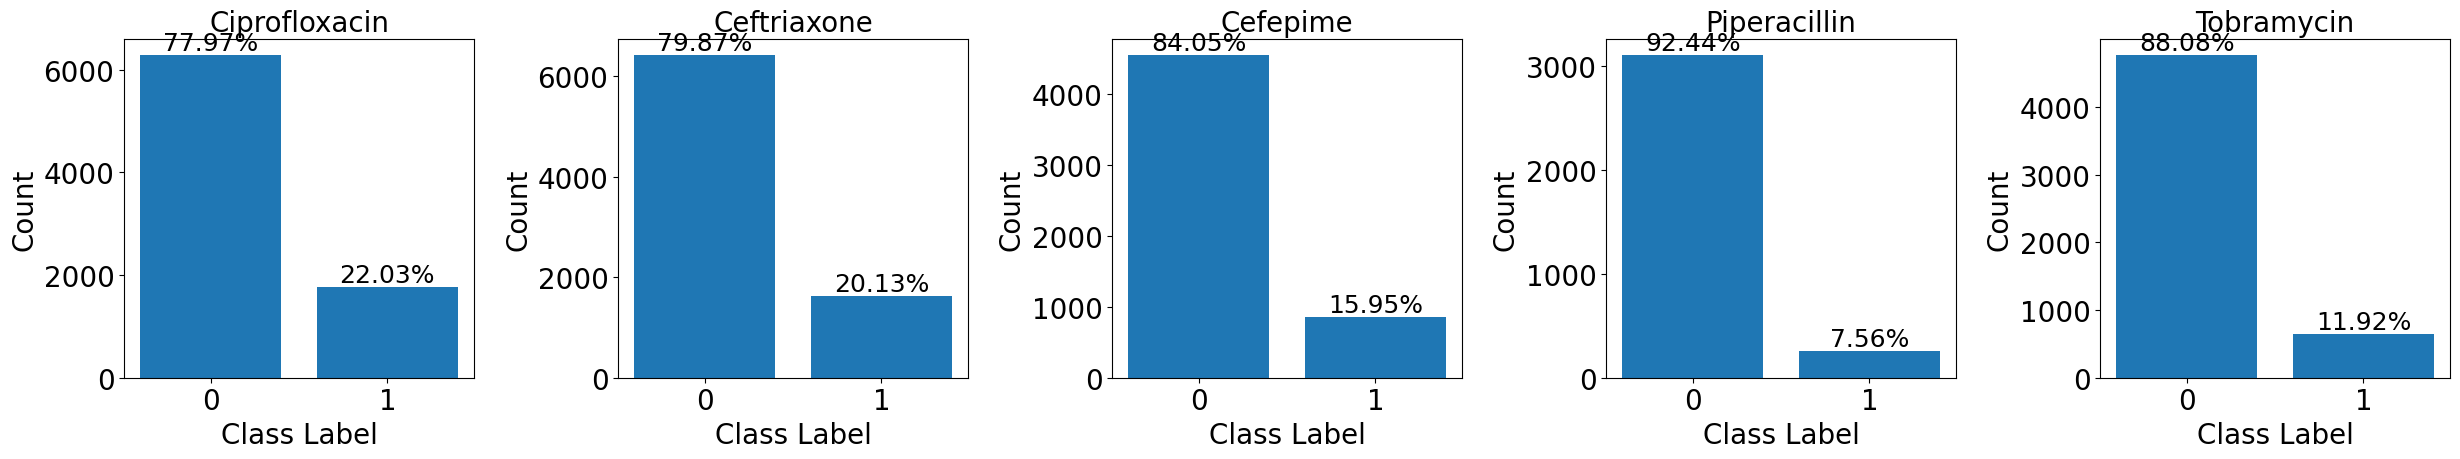

In [218]:
import matplotlib.pyplot as plt

# Set font size parameters
plt.rcParams.update({
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'font.size': 20
})

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
for i, antibiotic in enumerate(antibiotics):
    y_train_current = split_results[antibiotic]['y_train']
    
    counts = y_train_current.value_counts().sort_index()
    proportions = y_train_current.value_counts(normalize=True).sort_index()

    bars = axes[i].bar(counts.index, counts.values)

    for bar, proportion in zip(bars, proportions):
        yval = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2, yval, f'{proportion:.2%}', va='bottom', ha='center', fontsize=18, color='black')

    axes[i].set_title(f'{antibiotic}')
    axes[i].set_xlabel('Class Label')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(counts.index)

plt.tight_layout()
#plt.savefig('Proportions_y_train_per_ab.png', dpi=300, bbox_inches='tight')
plt.show()


## Model comparison

### RF

In [175]:
split_results['Ciprofloxacin']['y_train'].shape

(8054,)

In [176]:
# Parameters to optimize
parameters  = {
    'n_estimators': randint(50, 200),        # The number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50], # The maximum depth of the tree
}

In [177]:
# Number of configurations to try
n_iter = 10

# Initialize dictionaries to store best parameters and scores for each antibiotic
best_params_rf_dict = {}
best_scores_rf_dict = {}

# Iterate through each antibiotic for RandomForest
for antibiotic in antibiotics:
    print(f"Evaluating RandomForest models for {antibiotic}...")

    # Get the scaled training and validation data for the current antibiotic
    current = scaled_datasets[antibiotic]
    X_train = current['X_train_scaled']
    y_train = split_results[antibiotic]['y_train']
    X_valid = current['X_valid_scaled']
    y_valid = split_results[antibiotic]['y_valid']

    # Initialize the best parameters and score for the current antibiotic
    best_params = None
    best_score = 0

    # Create a parameter sampler
    param_sampler = ParameterSampler(parameters, n_iter=n_iter, random_state=42)

    # Iterate through the sampled parameter settings
    for params in tqdm(param_sampler):
        rf_model = RandomForestClassifier(**params, n_jobs=100, random_state=42)

        # Train the model
        rf_model.fit(X_train, y_train)

        # Predict on the validation set
        y_pred = rf_model.predict(X_valid)

        # Calculate the F1 score
        score = f1_score(y_valid, y_pred, average='weighted')

        # Update the best parameters and score if the current model is better
        if score > best_score:
            best_score = score
            best_params = params

    # Store the best parameters and score for the current antibiotic
    best_params_rf_dict[antibiotic] = best_params
    best_scores_rf_dict[antibiotic] = best_score

    print(f"Best parameters for RandomForest {antibiotic}: {best_params}")
    print(f"Best validation F1-score for RandomForest {antibiotic}: {best_score}")

# Output the best parameters and scores for all antibiotics
print("Best parameters for all antibiotics (RandomForest):", best_params_rf_dict)
print("Best validation F1-scores for all antibiotics (RandomForest):", best_scores_rf_dict)

Evaluating RandomForest models for Ciprofloxacin...


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


Best parameters for RandomForest Ciprofloxacin: {'max_depth': 40, 'n_estimators': 51}
Best validation F1-score for RandomForest Ciprofloxacin: 0.6825439252495096
Evaluating RandomForest models for Ceftriaxone...


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


Best parameters for RandomForest Ceftriaxone: {'max_depth': 40, 'n_estimators': 70}
Best validation F1-score for RandomForest Ceftriaxone: 0.7754192531394326
Evaluating RandomForest models for Cefepime...


100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


Best parameters for RandomForest Cefepime: {'max_depth': 30, 'n_estimators': 142}
Best validation F1-score for RandomForest Cefepime: 0.8171299181869739
Evaluating RandomForest models for Piperacillin...


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Best parameters for RandomForest Piperacillin: {'max_depth': 30, 'n_estimators': 142}
Best validation F1-score for RandomForest Piperacillin: 0.9031845736619606
Evaluating RandomForest models for Tobramycin...


100%|██████████| 10/10 [00:19<00:00,  1.90s/it]

Best parameters for RandomForest Tobramycin: {'max_depth': 30, 'n_estimators': 142}
Best validation F1-score for RandomForest Tobramycin: 0.8103182233360107
Best parameters for all antibiotics (RandomForest): {'Ciprofloxacin': {'max_depth': 40, 'n_estimators': 51}, 'Ceftriaxone': {'max_depth': 40, 'n_estimators': 70}, 'Cefepime': {'max_depth': 30, 'n_estimators': 142}, 'Piperacillin': {'max_depth': 30, 'n_estimators': 142}, 'Tobramycin': {'max_depth': 30, 'n_estimators': 142}}
Best validation F1-scores for all antibiotics (RandomForest): {'Ciprofloxacin': 0.6825439252495096, 'Ceftriaxone': 0.7754192531394326, 'Cefepime': 0.8171299181869739, 'Piperacillin': 0.9031845736619606, 'Tobramycin': 0.8103182233360107}


In [178]:
# Final models with optimized hyperparameters
# Initialize dictionaries to store the final RandomForest models and evaluation results
final_models_rf_ = {}
results_rf_ = {}

# Fit the final models using the best hyperparameters for each antibiotic
for antibiotic in antibiotics:
    print(f"Fitting final RandomForest model for {antibiotic}...")

    # Get the best parameters for the current antibiotic
    best_params = best_params_rf_dict[antibiotic]

    # Initialize the RandomForestClassifier with the best parameters
    final_model = RandomForestClassifier(**best_params,  n_jobs=100, random_state=42)

    # Get the training and validation data for the current antibiotic
    current = scaled_datasets[antibiotic]
    X_train = current['X_train_scaled']
    y_train = split_results[antibiotic]['y_train']
    X_valid = current['X_valid_scaled']
    y_valid = split_results[antibiotic]['y_valid']
    X_test = current['X_test_scaled']
    y_test = split_results[antibiotic]['y_test']

    
    # Fit the model on the training data
    final_model.fit(X_train, y_train)

    # Store the fitted model in the dictionary
    final_models_rf_[antibiotic] = final_model

    # Evaluate the final model using the evaluate_model_with_time function
    results_rf_[antibiotic] = evaluate_model_with_time(final_model, 
                                                       X_train, y_train, 
                                                       X_valid, y_valid,
                                                       X_test, y_test, task=2)

Fitting final RandomForest model for Ciprofloxacin...
Fitting final RandomForest model for Ceftriaxone...
Fitting final RandomForest model for Cefepime...
Fitting final RandomForest model for Piperacillin...
Fitting final RandomForest model for Tobramycin...


In [33]:
results_rf_['Ciprofloxacin']

,Metric,Train Score,Validation Score,Execution Time
0,Accuracy,0.999876,0.769409,0 min 2 sec
1,Balanced Accuracy,0.999718,0.520511,0 min 2 sec
2,Precision (Weighted),0.999876,0.760681,0 min 2 sec
3,Recall (Weighted),0.999876,0.769409,0 min 2 sec
4,F1 Score (Weighted),0.999876,0.682544,0 min 2 sec
5,AUPRC,1.000000,0.639319,0 min 2 sec


In [179]:
combined_results_ab_rf = pd.DataFrame()

for antibiotic in antibiotics:
    df = results_rf_[antibiotic]  
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[antibiotic], df_selected.columns])
    combined_results_ab_rf = pd.concat([combined_results_ab_rf, df_selected], axis=1)

combined_results_ab_rf.columns.names = ['Antibiotic', None]
combined_results_ab_rf = combined_results_ab_rf.round(4)
combined_results_ab_rf

Antibiotic           Ciprofloxacin                                             \
                       Train Score Validation Score Test Score Execution Time   
Metric                                                                          
Accuracy                    0.9999           0.7694     0.7654    0 min 2 sec   
Balanced Accuracy           0.9997           0.5205     0.5182    0 min 2 sec   
Precision (Weighted)        0.9999           0.7607     0.7270    0 min 2 sec   
Recall (Weighted)           0.9999           0.7694     0.7654    0 min 2 sec   
F1 Score (Weighted)         0.9999           0.6825     0.6798    0 min 2 sec   
AUPRC                       1.0000           0.6393     0.6278    0 min 2 sec   

Antibiotic           Ceftriaxone                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                     1.0           0.8348     0.8349    0 min 2 sec   
Balanced Accuracy            1.0           0.5488     0.5573    0 min 2 sec   
Precision (Weighted)         1.0           0.8522     0.8538    0 min 2 sec   
Recall (Weighted)            1.0           0.8348     0.8349    0 min 2 sec   
F1 Score (Weighted)          1.0           0.7754     0.7778    0 min 2 sec   
AUPRC                        1.0           0.7111     0.7023    0 min 2 sec   

Antibiotic              Cefepime                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                     1.0           0.8672     0.8621    0 min 3 sec   
Balanced Accuracy            1.0           0.5441     0.5367    0 min 3 sec   
Precision (Weighted)         1.0           0.8766     0.8554    0 min 3 sec   
Recall (Weighted)            1.0           0.8672     0.8621    0 min 3 sec   
F1 Score (Weighted)          1.0           0.8171     0.8099    0 min 3 sec   
AUPRC                        1.0           0.7007     0.6869    0 min 3 sec   

Antibiotic           Piperacillin                                             \
                      Train Score Validation Score Test Score Execution Time   
Metric                                                                         
Accuracy                      1.0           0.9347     0.9333    0 min 2 sec   
Balanced Accuracy             1.0           0.5000     0.5102    0 min 2 sec   
Precision (Weighted)          1.0           0.8737     0.9378    0 min 2 sec   
Recall (Weighted)             1.0           0.9347     0.9333    0 min 2 sec   
F1 Score (Weighted)           1.0           0.9032     0.9025    0 min 2 sec   
AUPRC                         1.0           0.5182     0.5410    0 min 2 sec   

Antibiotic            Tobramycin                                             
                     Train Score Validation Score Test Score Execution Time  
Metric                                                                       
Accuracy                  0.9989           0.8689     0.8619    0 min 3 sec  
Balanced Accuracy         0.9953           0.5023     0.5000    0 min 3 sec  
Precision (Weighted)      0.9989           0.8003     0.7430    0 min 3 sec  
Recall (Weighted)         0.9989           0.8689     0.8619    0 min 3 sec  
F1 Score (Weighted)       0.9989           0.8103     0.7980    0 min 3 sec  
AUPRC                     1.0000           0.5483     0.5398    0 min 3 sec

In [180]:
combined_results_ab_rf.T

Metric                             Accuracy Balanced Accuracy  \
Antibiotic                                                      
Ciprofloxacin Train Score            0.9999            0.9997   
              Validation Score       0.7694            0.5205   
              Test Score             0.7654            0.5182   
              Execution Time    0 min 2 sec       0 min 2 sec   
Ceftriaxone   Train Score               1.0               1.0   
              Validation Score       0.8348            0.5488   
              Test Score             0.8349            0.5573   
              Execution Time    0 min 2 sec       0 min 2 sec   
Cefepime      Train Score               1.0               1.0   
              Validation Score       0.8672            0.5441   
              Test Score             0.8621            0.5367   
              Execution Time    0 min 3 sec       0 min 3 sec   
Piperacillin  Train Score               1.0               1.0   
              Validation Score       0.9347               0.5   
              Test Score             0.9333            0.5102   
              Execution Time    0 min 2 sec       0 min 2 sec   
Tobramycin    Train Score            0.9989            0.9953   
              Validation Score       0.8689            0.5023   
              Test Score             0.8619               0.5   
              Execution Time    0 min 3 sec       0 min 3 sec   

Metric                         Precision (Weighted) Recall (Weighted)  \
Antibiotic                                                              
Ciprofloxacin Train Score                    0.9999            0.9999   
              Validation Score               0.7607            0.7694   
              Test Score                      0.727            0.7654   
              Execution Time            0 min 2 sec       0 min 2 sec   
Ceftriaxone   Train Score                       1.0               1.0   
              Validation Score               0.8522            0.8348   
              Test Score                     0.8538            0.8349   
              Execution Time            0 min 2 sec       0 min 2 sec   
Cefepime      Train Score                       1.0               1.0   
              Validation Score               0.8766            0.8672   
              Test Score                     0.8554            0.8621   
              Execution Time            0 min 3 sec       0 min 3 sec   
Piperacillin  Train Score                       1.0               1.0   
              Validation Score               0.8737            0.9347   
              Test Score                     0.9378            0.9333   
              Execution Time            0 min 2 sec       0 min 2 sec   
Tobramycin    Train Score                    0.9989            0.9989   
              Validation Score               0.8003            0.8689   
              Test Score                      0.743            0.8619   
              Execution Time            0 min 3 sec       0 min 3 sec   

Metric                         F1 Score (Weighted)        AUPRC  
Antibiotic                                                       
Ciprofloxacin Train Score                   0.9999          1.0  
              Validation Score              0.6825       0.6393  
              Test Score                    0.6798       0.6278  
              Execution Time           0 min 2 sec  0 min 2 sec  
Ceftriaxone   Train Score                      1.0          1.0  
              Validation Score              0.7754       0.7111  
              Test Score                    0.7778       0.7023  
              Execution Time           0 min 2 sec  0 min 2 sec  
Cefepime      Train Score                      1.0          1.0  
              Validation Score              0.8171       0.7007  
              Test Score                    0.8099       0.6869  
              Execution Time           0 min 3 sec  0 min 3 sec  
Piperacillin  Train Score             

### SVM

In [181]:
parameters_svm = {
    "C": np.logspace(-3,3,7), 
    "kernel": ['linear', 'rbf']
}

In [182]:
# Trying less combinations because SVM takes longer time
n_iter_svm = 5

# Initialize dictionaries to store best parameters and scores for each antibiotic
best_params_svm_dict = {}
best_scores_svm_dict = {}

# Iterate through each antibiotic to find the best parameters for SVM
for antibiotic in antibiotics:
    print(f"Evaluating SVM models for {antibiotic}...")

    # Get the scaled training and validation data for the current antibiotic
    current = scaled_datasets[antibiotic]
    X_train = current['X_train_scaled']
    y_train = split_results[antibiotic]['y_train']
    X_valid = current['X_valid_scaled']
    y_valid = split_results[antibiotic]['y_valid']

    # Initialize the best parameters and score for the current antibiotic
    best_params = None
    best_score = 0

    # Create a parameter sampler
    param_sampler = ParameterSampler(parameters_svm, n_iter=n_iter_svm, random_state=42)

    # Iterate through the sampled parameter settings
    for params in tqdm(param_sampler):
        svm_model = svm.SVC(**params, decision_function_shape='ovr', probability=True, random_state=42)

        # Train the model
        svm_model.fit(X_train, y_train)

        # Predict on the validation set
        y_pred = svm_model.predict(X_valid)

        # Calculate the F1 score
        score = f1_score(y_valid, y_pred, average='weighted')

        # Update the best parameters and score if the current model is better
        if score > best_score:
            best_score = score
            best_params = params

    # Store the best parameters and score for the current antibiotic
    best_params_svm_dict[antibiotic] = best_params
    best_scores_svm_dict[antibiotic] = best_score

    print(f"Best parameters for SVM {antibiotic}: {best_params}")
    print(f"Best validation F1-score for SVM {antibiotic}: {best_score}")

Evaluating SVM models for Ciprofloxacin...


100%|██████████| 5/5 [42:50<00:00, 514.13s/it]


Best parameters for SVM Ciprofloxacin: {'kernel': 'rbf', 'C': 100.0}
Best validation F1-score for SVM Ciprofloxacin: 0.7673665903229016
Evaluating SVM models for Ceftriaxone...


100%|██████████| 5/5 [38:22<00:00, 460.43s/it]


Best parameters for SVM Ceftriaxone: {'kernel': 'rbf', 'C': 100.0}
Best validation F1-score for SVM Ceftriaxone: 0.8689654101897613
Evaluating SVM models for Cefepime...


100%|██████████| 5/5 [16:05<00:00, 193.17s/it]


Best parameters for SVM Cefepime: {'kernel': 'rbf', 'C': 100.0}
Best validation F1-score for SVM Cefepime: 0.8730866291740856
Evaluating SVM models for Piperacillin...


100%|██████████| 5/5 [04:54<00:00, 58.89s/it]


Best parameters for SVM Piperacillin: {'kernel': 'rbf', 'C': 100.0}
Best validation F1-score for SVM Piperacillin: 0.9066269371628431
Evaluating SVM models for Tobramycin...


100%|██████████| 5/5 [17:52<00:00, 214.56s/it]

Best parameters for SVM Tobramycin: {'kernel': 'rbf', 'C': 100.0}
Best validation F1-score for SVM Tobramycin: 0.8251280582244898


In [184]:
# Initialize dictionaries to store the final SVM models and evaluation results
final_models_svm_ = {}
results_svm_ = {}

# Fit the final models using the best hyperparameters for each antibiotic
for antibiotic in antibiotics:
    print(f"Fitting final SVM model for {antibiotic}...")

    # Get the best parameters for the current antibiotic
    best_params = best_params_svm_dict[antibiotic]

    # Initialize the SVM with the best parameters
    final_model = svm.SVC(**best_params, decision_function_shape='ovr', probability=True, random_state=42)

    # Get the training and validation data for the current antibiotic
    current = scaled_datasets[antibiotic]
    X_train = current['X_train_scaled']
    y_train = split_results[antibiotic]['y_train']
    X_valid = current['X_valid_scaled']
    y_valid = split_results[antibiotic]['y_valid']
    X_test = current['X_test_scaled']
    y_test = split_results[antibiotic]['y_test']
    
    # Store the fitted model in the dictionary
    final_models_svm_[antibiotic] = final_model

    # Evaluate the final model using the evaluate_model_with_time function
    results_svm_[antibiotic] = evaluate_model_with_time(final_model, 
                                                        X_train, y_train, 
                                                        X_valid, y_valid, 
                                                        X_test, y_test, task=2)

Fitting final SVM model for Ciprofloxacin...
Fitting final SVM model for Ceftriaxone...
Fitting final SVM model for Cefepime...
Fitting final SVM model for Piperacillin...
Fitting final SVM model for Tobramycin...


In [185]:
combined_results_ab_svm = pd.DataFrame()

for antibiotic in antibiotics:
    df = results_svm_[antibiotic]  
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[antibiotic], df_selected.columns])
    combined_results_ab_svm = pd.concat([combined_results_ab_svm, df_selected], axis=1)

combined_results_ab_svm.columns.names = ['Antibiotic', None]
combined_results_ab_svm = combined_results_ab_svm.round(4)
combined_results_ab_svm

Antibiotic           Ciprofloxacin                                             \
                       Train Score Validation Score Test Score Execution Time   
Metric                                                                          
Accuracy                    0.9621           0.7897     0.7972  14 min 46 sec   
Balanced Accuracy           0.9173           0.6354     0.6645  14 min 46 sec   
Precision (Weighted)        0.9633           0.7673     0.7799  14 min 46 sec   
Recall (Weighted)           0.9621           0.7897     0.7972  14 min 46 sec   
F1 Score (Weighted)         0.9610           0.7674     0.7824  14 min 46 sec   
AUPRC                       0.9871           0.7237     0.7251  14 min 46 sec   

Antibiotic           Ceftriaxone                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                  0.9707           0.8773     0.8727  13 min 41 sec   
Balanced Accuracy         0.9289           0.7387     0.7391  13 min 41 sec   
Precision (Weighted)      0.9715           0.8683     0.8637  13 min 41 sec   
Recall (Weighted)         0.9707           0.8773     0.8727  13 min 41 sec   
F1 Score (Weighted)       0.9699           0.8690     0.8650  13 min 41 sec   
AUPRC                     0.9866           0.8063     0.8215  13 min 41 sec   

Antibiotic              Cefepime                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                  0.9808           0.8828     0.8690   6 min 21 sec   
Balanced Accuracy         0.9416           0.6966     0.6601   6 min 21 sec   
Precision (Weighted)      0.9811           0.8702     0.8517   6 min 21 sec   
Recall (Weighted)         0.9808           0.8828     0.8690   6 min 21 sec   
F1 Score (Weighted)       0.9803           0.8731     0.8558   6 min 21 sec   
AUPRC                     0.9952           0.7552     0.7297   6 min 21 sec   

Antibiotic           Piperacillin                                             \
                      Train Score Validation Score Test Score Execution Time   
Metric                                                                         
Accuracy                   0.9753           0.9319     0.9292    2 min 6 sec   
Balanced Accuracy          0.8366           0.5183     0.5269    2 min 6 sec   
Precision (Weighted)       0.9759           0.8976     0.8973    2 min 6 sec   
Recall (Weighted)          0.9753           0.9319     0.9292    2 min 6 sec   
F1 Score (Weighted)        0.9730           0.9066     0.9047    2 min 6 sec   
AUPRC                      0.9909           0.6005     0.5724    2 min 6 sec   

Antibiotic            Tobramycin                                             
                     Train Score Validation Score Test Score Execution Time  
Metric                                                                       
Accuracy                  0.9758           0.8559     0.8516   6 min 11 sec  
Balanced Accuracy         0.8983           0.5456     0.5439   6 min 11 sec  
Precision (Weighted)      0.9764           0.8117     0.8048   6 min 11 sec  
Recall (Weighted)         0.9758           0.8559     0.8516   6 min 11 sec  
F1 Score (Weighted)       0.9746           0.8251     0.8166   6 min 11 sec  
AUPRC                     0.9894           0.5968     0.5950   6 min 11 sec

In [186]:
combined_results_ab_svm.T

Metric                               Accuracy Balanced Accuracy  \
Antibiotic                                                        
Ciprofloxacin Train Score              0.9621            0.9173   
              Validation Score         0.7897            0.6354   
              Test Score               0.7972            0.6645   
              Execution Time    14 min 46 sec     14 min 46 sec   
Ceftriaxone   Train Score              0.9707            0.9289   
              Validation Score         0.8773            0.7387   
              Test Score               0.8727            0.7391   
              Execution Time    13 min 41 sec     13 min 41 sec   
Cefepime      Train Score              0.9808            0.9416   
              Validation Score         0.8828            0.6966   
              Test Score                0.869            0.6601   
              Execution Time     6 min 21 sec      6 min 21 sec   
Piperacillin  Train Score              0.9753            0.8366   
              Validation Score         0.9319            0.5183   
              Test Score               0.9292            0.5269   
              Execution Time      2 min 6 sec       2 min 6 sec   
Tobramycin    Train Score              0.9758            0.8983   
              Validation Score         0.8559            0.5456   
              Test Score               0.8516            0.5439   
              Execution Time     6 min 11 sec      6 min 11 sec   

Metric                         Precision (Weighted) Recall (Weighted)  \
Antibiotic                                                              
Ciprofloxacin Train Score                    0.9633            0.9621   
              Validation Score               0.7673            0.7897   
              Test Score                     0.7799            0.7972   
              Execution Time          14 min 46 sec     14 min 46 sec   
Ceftriaxone   Train Score                    0.9715            0.9707   
              Validation Score               0.8683            0.8773   
              Test Score                     0.8637            0.8727   
              Execution Time          13 min 41 sec     13 min 41 sec   
Cefepime      Train Score                    0.9811            0.9808   
              Validation Score               0.8702            0.8828   
              Test Score                     0.8517             0.869   
              Execution Time           6 min 21 sec      6 min 21 sec   
Piperacillin  Train Score                    0.9759            0.9753   
              Validation Score               0.8976            0.9319   
              Test Score                     0.8973            0.9292   
              Execution Time            2 min 6 sec       2 min 6 sec   
Tobramycin    Train Score                    0.9764            0.9758   
              Validation Score               0.8117            0.8559   
              Test Score                     0.8048            0.8516   
              Execution Time           6 min 11 sec      6 min 11 sec   

Metric                         F1 Score (Weighted)          AUPRC  
Antibiotic                                                         
Ciprofloxacin Train Score                    0.961         0.9871  
              Validation Score              0.7674         0.7237  
              Test Score                    0.7824         0.7251  
              Execution Time         14 min 46 sec  14 min 46 sec  
Ceftriaxone   Train Score                   0.9699         0.9866  
              Validation Score               0.869         0.8063  
              Test Score                     0.865         0.8215  
              Execution Time         13 min 41 sec  13 min 41 sec  
Cefepime      Train Score                   0.9803         0.9952  
              Validation Score              0.8731         0.7552  
              Test Score                    0.8558         0.7297  
              Execution Time      

# Feature importance

In [163]:
antibiotics = ['Ciprofloxacin', 'Ceftriaxone', 'Cefepime', 'Piperacillin', 'Tobramycin']

In [187]:
importance_dfs_ = {}  

for antibiotic in tqdm(antibiotics, desc="Running DTC"):
    clf_antibiotic = DecisionTreeClassifier(max_depth=40, random_state=42)
    current = split_results[antibiotic]
    
    X_train_scaled = scaled_datasets[antibiotic]['X_train_scaled']
    clf_antibiotic.fit(X_train_scaled, current['y_train'])

    importances_antibiotic = clf_antibiotic.feature_importances_
    importance_df_antibiotic = pd.DataFrame({'Feature': X_train_species_comb.columns, 'Importance': importances_antibiotic})
    importance_df_antibiotic = importance_df_antibiotic.sort_values(by='Importance', ascending=False)  
    importance_dfs_[antibiotic] = importance_df_antibiotic

Running DTC: 100%|██████████| 5/5 [05:12<00:00, 62.41s/it]


In [188]:
importance_dfs_['Ciprofloxacin'].head(10)

,Feature,Importance
1001,5003,0.020574
1011,5033,0.014528
3235,11705,0.013104
3261,11783,0.012294
3260,11780,0.010476
2967,10901,0.008423
1621,6863,0.008134
926,4778,0.007752
45,2135,0.007496
137,2411,0.007363


In [189]:
importance_dfs_['Ceftriaxone'].head(10)

,Feature,Importance
45,2135,0.080652
22,2066,0.040012
135,2405,0.015839
456,3368,0.015520
489,3467,0.014121
1001,5003,0.011015
1777,7331,0.009112
210,2630,0.008311
1174,5522,0.008216
505,3515,0.008072


In [190]:
importance_dfs_['Cefepime'].head(10)

,Feature,Importance
45,2135,0.083918
705,4115,0.020660
50,2150,0.016864
1778,7334,0.016586
3262,11786,0.016348
327,2981,0.016195
22,2066,0.015213
720,4160,0.013534
496,3488,0.011088
51,2153,0.010407


In [191]:
importance_dfs_['Piperacillin'].head(10)

,Feature,Importance
1778,7334,0.022974
4073,14219,0.018988
3229,11687,0.018853
86,2258,0.018228
4219,14657,0.017672
1842,7526,0.016312
1704,7112,0.016215
1401,6203,0.015425
136,2408,0.013444
4692,16076,0.013105


In [192]:
importance_dfs_['Tobramycin'].head(10)

,Feature,Importance
3259,11777,0.018491
632,3896,0.016082
45,2135,0.012714
645,3935,0.011901
1137,5411,0.011875
387,3161,0.010216
2544,9632,0.010050
1050,5150,0.009782
317,2951,0.009560
3553,12659,0.009457


## RF adter DR

In [193]:
threshold = 0.01
results_rf_dr_ = {}

for antibiotic in tqdm(antibiotics, desc="Running RF_dr"):
    selected_features = importance_dfs_[antibiotic][importance_dfs_[antibiotic]['Importance'] > threshold]['Feature']

    X_train_selected = scaled_datasets[antibiotic]['X_train_scaled'][selected_features]
    X_valid_selected = scaled_datasets[antibiotic]['X_valid_scaled'][selected_features]
    X_test_selected = scaled_datasets[antibiotic]['X_test_scaled'][selected_features]

    best_params = best_params_rf_dict[antibiotic]

    models_rf_dr = RandomForestClassifier(**best_params, n_jobs=100, random_state=42)
    results_rf_dr_[antibiotic] = evaluate_model_with_time(models_rf_dr, 
                                                           X_train_selected, split_results[antibiotic]['y_train'],
                                                           X_valid_selected, split_results[antibiotic]['y_valid'],
                                                           X_test_selected, split_results[antibiotic]['y_test'], task=2)

Running RF_dr: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


In [194]:
combined_results_ab_rf_dr = pd.DataFrame()

for antibiotic in antibiotics:
    df = results_rf_dr_[antibiotic]  
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[antibiotic], df_selected.columns])
    combined_results_ab_rf_dr = pd.concat([combined_results_ab_rf_dr, df_selected], axis=1)

combined_results_ab_rf_dr.columns.names = ['Antibiotic', None]
combined_results_ab_rf_dr = combined_results_ab_rf_dr.round(4)
combined_results_ab_rf_dr

Antibiotic           Ciprofloxacin                                             \
                       Train Score Validation Score Test Score Execution Time   
Metric                                                                          
Accuracy                    0.9995           0.7659     0.7735    0 min 0 sec   
Balanced Accuracy           0.9989           0.5485     0.5703    0 min 0 sec   
Precision (Weighted)        0.9995           0.7212     0.7389    0 min 0 sec   
Recall (Weighted)           0.9995           0.7659     0.7735    0 min 0 sec   
F1 Score (Weighted)         0.9995           0.7084     0.7256    0 min 0 sec   
AUPRC                       1.0000           0.5999     0.6185    0 min 0 sec   

Antibiotic           Ceftriaxone                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                     1.0           0.8639     0.8657    0 min 0 sec   
Balanced Accuracy            1.0           0.6486     0.6609    0 min 0 sec   
Precision (Weighted)         1.0           0.8614     0.8637    0 min 0 sec   
Recall (Weighted)            1.0           0.8639     0.8657    0 min 0 sec   
F1 Score (Weighted)          1.0           0.8369     0.8409    0 min 0 sec   
AUPRC                        1.0           0.7304     0.7403    0 min 0 sec   

Antibiotic              Cefepime                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                     1.0           0.8940     0.8940    0 min 1 sec   
Balanced Accuracy            1.0           0.6611     0.6504    0 min 1 sec   
Precision (Weighted)         1.0           0.8886     0.8958    0 min 1 sec   
Recall (Weighted)            1.0           0.8940     0.8940    0 min 1 sec   
F1 Score (Weighted)          1.0           0.8737     0.8704    0 min 1 sec   
AUPRC                        1.0           0.7349     0.7578    0 min 1 sec   

Antibiotic           Piperacillin                                             \
                      Train Score Validation Score Test Score Execution Time   
Metric                                                                         
Accuracy                      1.0           0.9347     0.9319    0 min 1 sec   
Balanced Accuracy             1.0           0.5000     0.5095    0 min 1 sec   
Precision (Weighted)          1.0           0.8737     0.9037    0 min 1 sec   
Recall (Weighted)             1.0           0.9347     0.9319    0 min 1 sec   
F1 Score (Weighted)           1.0           0.9032     0.9017    0 min 1 sec   
AUPRC                         1.0           0.5056     0.5234    0 min 1 sec   

Antibiotic            Tobramycin                                             
                     Train Score Validation Score Test Score Execution Time  
Metric                                                                       
Accuracy                  0.9998           0.8689     0.8628    0 min 1 sec  
Balanced Accuracy         0.9992           0.5164     0.5136    0 min 1 sec  
Precision (Weighted)      0.9998           0.8198     0.8225    0 min 1 sec  
Recall (Weighted)         0.9998           0.8689     0.8628    0 min 1 sec  
F1 Score (Weighted)       0.9998           0.8179     0.8063    0 min 1 sec  
AUPRC                     1.0000           0.5573     0.5572    0 min 1 sec

## SVM after DR

In [195]:
threshold = 0.01
results_svm_dr_ = {}

for antibiotic in tqdm(antibiotics, desc="Running SVM_dr"):
    selected_features = importance_dfs_[antibiotic][importance_dfs_[antibiotic]['Importance'] > threshold]['Feature']

    X_train_selected = scaled_datasets[antibiotic]['X_train_scaled'][selected_features]
    X_valid_selected = scaled_datasets[antibiotic]['X_valid_scaled'][selected_features]
    X_test_selected = scaled_datasets[antibiotic]['X_test_scaled'][selected_features]

    best_params = best_params_svm_dict[antibiotic]
    models_svm_dr = svm.SVC(**best_params, decision_function_shape='ovr', probability=True, random_state=42)
    results_svm_dr_[antibiotic] = evaluate_model_with_time(models_svm_dr, 
                                                           X_train_selected, split_results[antibiotic]['y_train'],
                                                           X_valid_selected, split_results[antibiotic]['y_valid'],
                                                           X_test_selected, split_results[antibiotic]['y_test'], task=2)

Running SVM_dr: 100%|██████████| 5/5 [01:00<00:00, 12.03s/it]


In [196]:
combined_results_ab_svm_dr = pd.DataFrame()

for antibiotic in antibiotics:
    df = results_svm_dr_[antibiotic]  
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[antibiotic], df_selected.columns])
    combined_results_ab_svm_dr = pd.concat([combined_results_ab_svm_dr, df_selected], axis=1)

combined_results_ab_svm_dr.columns.names = ['Antibiotic', None]
combined_results_ab_svm_dr = combined_results_ab_svm_dr.round(4)
combined_results_ab_svm_dr

Antibiotic           Ciprofloxacin                                             \
                       Train Score Validation Score Test Score Execution Time   
Metric                                                                          
Accuracy                    0.7976           0.7735     0.7793   0 min 29 sec   
Balanced Accuracy           0.5477           0.5332     0.5524   0 min 29 sec   
Precision (Weighted)        0.8053           0.7620     0.7671   0 min 29 sec   
Recall (Weighted)           0.7976           0.7735     0.7793   0 min 29 sec   
F1 Score (Weighted)         0.7294           0.6956     0.7130   0 min 29 sec   
AUPRC                       0.6579           0.5918     0.6245   0 min 29 sec   

Antibiotic           Ceftriaxone                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                  0.8488           0.8551     0.8547    0 min 9 sec   
Balanced Accuracy         0.6282           0.6171     0.6227    0 min 9 sec   
Precision (Weighted)      0.8666           0.8563     0.8569    0 min 9 sec   
Recall (Weighted)         0.8488           0.8551     0.8547    0 min 9 sec   
F1 Score (Weighted)       0.8116           0.8199     0.8202    0 min 9 sec   
AUPRC                     0.7671           0.7088     0.7302    0 min 9 sec   

Antibiotic              Cefepime                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                  0.9002           0.8879     0.8871    0 min 5 sec   
Balanced Accuracy         0.7069           0.6724     0.6610    0 min 5 sec   
Precision (Weighted)      0.8999           0.8752     0.8756    0 min 5 sec   
Recall (Weighted)         0.9002           0.8879     0.8871    0 min 5 sec   
F1 Score (Weighted)       0.8846           0.8721     0.8683    0 min 5 sec   
AUPRC                     0.8212           0.7275     0.7166    0 min 5 sec   

Antibiotic           Piperacillin                                             \
                      Train Score Validation Score Test Score Execution Time   
Metric                                                                         
Accuracy                   0.9384           0.9264     0.9236    0 min 2 sec   
Balanced Accuracy          0.5925           0.4955     0.5050    0 min 2 sec   
Precision (Weighted)       0.9422           0.8732     0.8776    0 min 2 sec   
Recall (Weighted)          0.9384           0.9264     0.9236    0 min 2 sec   
F1 Score (Weighted)        0.9182           0.8990     0.8973    0 min 2 sec   
AUPRC                      0.7900           0.5141     0.5056    0 min 2 sec   

Antibiotic            Tobramycin                                             
                     Train Score Validation Score Test Score Execution Time  
Metric                                                                       
Accuracy                  0.8921           0.8689     0.8654   0 min 16 sec  
Balanced Accuracy         0.5494           0.5192     0.5256   0 min 16 sec  
Precision (Weighted)      0.8989           0.8210     0.8370   0 min 16 sec  
Recall (Weighted)         0.8921           0.8689     0.8654   0 min 16 sec  
F1 Score (Weighted)       0.8514           0.8193     0.8135   0 min 16 sec  
AUPRC                     0.6877           0.5454     0.5494   0 min 16 sec

# PCA

In [197]:
results_rf_model_species_pca = {}
results_svm_model_species_pca = {}

for antibiotic in tqdm(antibiotics, desc="Running PCA and Models"):
    pca = PCA(n_components=5)
    X_train_pca = pca.fit_transform(scaled_datasets[antibiotic]['X_train_scaled'])
    X_valid_pca = pca.transform(scaled_datasets[antibiotic]['X_valid_scaled'])
    X_test_pca = pca.transform(scaled_datasets[antibiotic]['X_test_scaled'])
    
    # RF
    best_params = best_params_rf_dict[antibiotic]
    rf_model_after_d_red = RandomForestClassifier(**best_params,  n_jobs=100, random_state=42)
    results_rf_model_species_pca[antibiotic] = evaluate_model_with_time(rf_model_after_d_red, 
                                                                        X_train_pca, split_results[antibiotic]['y_train'], 
                                                                        X_valid_pca, split_results[antibiotic]['y_valid'],
                                                                        X_test_pca, split_results[antibiotic]['y_test'], task=2)
    
    # SVM
    best_params = best_params_svm_dict[antibiotic]
    svm_model_after_d_red = svm.SVC(**best_params, decision_function_shape='ovr', probability=True, random_state=42)
    results_svm_model_species_pca[antibiotic] = evaluate_model_with_time(svm_model_after_d_red, 
                                                                         X_train_pca, split_results[antibiotic]['y_train'], 
                                                                         X_valid_pca, split_results[antibiotic]['y_valid'], 
                                                                         X_test_pca, split_results[antibiotic]['y_test'], task=2)

Running PCA and Models: 100%|██████████| 5/5 [05:28<00:00, 65.63s/it] 


In [198]:
combined_results_ab_rf_pca = pd.DataFrame()

for antibiotic in antibiotics:
    df = results_rf_model_species_pca[antibiotic]
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[antibiotic], df_selected.columns])
    combined_results_ab_rf_pca = pd.concat([combined_results_ab_rf_pca, df_selected], axis=1)

combined_results_ab_rf_pca.columns.names = ['Antibiotic', None]
combined_results_ab_rf_pca = combined_results_ab_rf_pca.round(4)

combined_results_ab_rf_pca

Antibiotic           Ciprofloxacin                                             \
                       Train Score Validation Score Test Score Execution Time   
Metric                                                                          
Accuracy                    0.9994           0.7572     0.7462    0 min 0 sec   
Balanced Accuracy           0.9986           0.5184     0.5031    0 min 0 sec   
Precision (Weighted)        0.9994           0.6879     0.6459    0 min 0 sec   
Recall (Weighted)           0.9994           0.7572     0.7462    0 min 0 sec   
F1 Score (Weighted)         0.9994           0.6815     0.6662    0 min 0 sec   
AUPRC                       1.0000           0.5621     0.5280    0 min 0 sec   

Antibiotic           Ceftriaxone                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                  0.9996           0.8063     0.8035    0 min 1 sec   
Balanced Accuracy         0.9991           0.5028     0.5029    0 min 1 sec   
Precision (Weighted)      0.9996           0.7102     0.7066    0 min 1 sec   
Recall (Weighted)         0.9996           0.8063     0.8035    0 min 1 sec   
F1 Score (Weighted)       0.9996           0.7381     0.7337    0 min 1 sec   
AUPRC                     1.0000           0.5268     0.5390    0 min 1 sec   

Antibiotic              Cefepime                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                     1.0           0.8509     0.8500    0 min 1 sec   
Balanced Accuracy            1.0           0.5000     0.5029    0 min 1 sec   
Precision (Weighted)         1.0           0.7520     0.7656    0 min 1 sec   
Recall (Weighted)            1.0           0.8509     0.8500    0 min 1 sec   
F1 Score (Weighted)          1.0           0.7879     0.7874    0 min 1 sec   
AUPRC                        1.0           0.5322     0.5402    0 min 1 sec   

Antibiotic           Piperacillin                                             \
                      Train Score Validation Score Test Score Execution Time   
Metric                                                                         
Accuracy                      1.0           0.9347     0.9347    0 min 1 sec   
Balanced Accuracy             1.0           0.5000     0.5204    0 min 1 sec   
Precision (Weighted)          1.0           0.8737     0.9390    0 min 1 sec   
Recall (Weighted)             1.0           0.9347     0.9347    0 min 1 sec   
F1 Score (Weighted)           1.0           0.9032     0.9057    0 min 1 sec   
AUPRC                         1.0           0.5151     0.5246    0 min 1 sec   

Antibiotic            Tobramycin                                             
                     Train Score Validation Score Test Score Execution Time  
Metric                                                                       
Accuracy                     1.0           0.8697     0.8619    0 min 1 sec  
Balanced Accuracy            1.0           0.5000     0.5000    0 min 1 sec  
Precision (Weighted)         1.0           0.7564     0.7430    0 min 1 sec  
Recall (Weighted)            1.0           0.8697     0.8619    0 min 1 sec  
F1 Score (Weighted)          1.0           0.8091     0.7980    0 min 1 sec  
AUPRC                        1.0           0.5065     0.4963    0 min 1 sec

In [199]:
combined_results_ab_svm_pca = pd.DataFrame()

for antibiotic in antibiotics:
    df = results_svm_model_species_pca[antibiotic]
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[antibiotic], df_selected.columns])
    combined_results_ab_svm_pca = pd.concat([combined_results_ab_svm_pca, df_selected], axis=1)

combined_results_ab_svm_pca.columns.names = ['Antibiotic', None]
combined_results_ab_svm_pca = combined_results_ab_svm_pca.round(4)

combined_results_ab_svm_pca

Antibiotic           Ciprofloxacin                                             \
                       Train Score Validation Score Test Score Execution Time   
Metric                                                                          
Accuracy                    0.7842           0.7648     0.7607    2 min 8 sec   
Balanced Accuracy           0.5103           0.5074     0.5043    2 min 8 sec   
Precision (Weighted)        0.8252           0.7497     0.6837    2 min 8 sec   
Recall (Weighted)           0.7842           0.7648     0.7607    2 min 8 sec   
F1 Score (Weighted)         0.6939           0.6683     0.6647    2 min 8 sec   
AUPRC                       0.5999           0.5571     0.5286    2 min 8 sec   

Antibiotic           Ceftriaxone                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                  0.8042           0.8156     0.8093   1 min 44 sec   
Balanced Accuracy         0.5136           0.4986     0.4980   1 min 44 sec   
Precision (Weighted)      0.8427           0.6686     0.6798   1 min 44 sec   
Recall (Weighted)         0.8042           0.8156     0.8093   1 min 44 sec   
F1 Score (Weighted)       0.7221           0.7348     0.7298   1 min 44 sec   
AUPRC                     0.6030           0.5443     0.5327   1 min 44 sec   

Antibiotic              Cefepime                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                  0.8453           0.8543     0.8474   0 min 44 sec   
Balanced Accuracy         0.5151           0.5119     0.4965   0 min 44 sec   
Precision (Weighted)      0.8693           0.7997     0.7276   0 min 44 sec   
Recall (Weighted)         0.8453           0.8543     0.8474   0 min 44 sec   
F1 Score (Weighted)       0.7789           0.7958     0.7830   0 min 44 sec   
AUPRC                     0.6054           0.5216     0.5347   0 min 44 sec   

Antibiotic           Piperacillin                                             \
                      Train Score Validation Score Test Score Execution Time   
Metric                                                                         
Accuracy                   0.9280           0.9319     0.9306   0 min 10 sec   
Balanced Accuracy          0.5236           0.4985     0.4993   0 min 10 sec   
Precision (Weighted)       0.9332           0.8735     0.8684   0 min 10 sec   
Recall (Weighted)          0.9280           0.9319     0.9306   0 min 10 sec   
F1 Score (Weighted)        0.8965           0.9018     0.8984   0 min 10 sec   
AUPRC                      0.5831           0.5183     0.5003   0 min 10 sec   

Antibiotic            Tobramycin                                             
                     Train Score Validation Score Test Score Execution Time  
Metric                                                                       
Accuracy                  0.8851           0.8637     0.8594   0 min 37 sec  
Balanced Accuracy         0.5179           0.4965     0.4985   0 min 37 sec  
Precision (Weighted)      0.8983           0.7557     0.7426   0 min 37 sec  
Recall (Weighted)         0.8851           0.8637     0.8594   0 min 37 sec  
F1 Score (Weighted)       0.8351           0.8061     0.7968   0 min 37 sec  
AUPRC                     0.5969           0.5276     0.5053   0 min 37 sec

# LDA

In [200]:
results_rf_model_species_lda = {}
results_svm_model_species_lda = {}

for antibiotic in tqdm(antibiotics, desc="Running LDA and Models"):
    lda = LinearDiscriminantAnalysis(n_components=1)
    X_train_lda = lda.fit_transform(scaled_datasets[antibiotic]['X_train_scaled'], split_results[antibiotic]['y_train'])
    X_valid_lda = lda.transform(scaled_datasets[antibiotic]['X_valid_scaled'])
    X_test_lda = lda.transform(scaled_datasets[antibiotic]['X_test_scaled'])
    
    # RF
    best_params = best_params_rf_dict[antibiotic]
    rf_model_after_lda = RandomForestClassifier(**best_params, n_jobs=100, random_state=42)
    results_rf_model_species_lda[antibiotic] = evaluate_model_with_time(rf_model_after_lda, 
                                                                        X_train_lda, split_results[antibiotic]['y_train'], 
                                                                        X_valid_lda, split_results[antibiotic]['y_valid'], 
                                                                        X_test_lda, split_results[antibiotic]['y_test'], task=2)
    
    # SVM
    best_params = best_params_svm_dict[antibiotic]
    svm_model_after_lda = svm.SVC(**best_params, decision_function_shape='ovr', probability=True, random_state=42)
    results_svm_model_species_lda[antibiotic] = evaluate_model_with_time(svm_model_after_lda, 
                                                                         X_train_lda, split_results[antibiotic]['y_train'], 
                                                                         X_valid_lda, split_results[antibiotic]['y_valid'], 
                                                                         X_test_lda, split_results[antibiotic]['y_test'], task=2)

Running LDA and Models: 100%|██████████| 5/5 [04:24<00:00, 52.88s/it]


In [203]:
combined_results_ab_rf_lda = pd.DataFrame()

for antibiotic in antibiotics:
    df = results_rf_model_species_lda[antibiotic]
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[antibiotic], df_selected.columns])
    combined_results_ab_rf_lda = pd.concat([combined_results_ab_rf_lda, df_selected], axis=1)

combined_results_ab_rf_lda.columns.names = ['Antibiotic', None]
combined_results_ab_rf_lda = combined_results_ab_rf_lda.round(4)

combined_results_ab_rf_lda

Antibiotic           Ciprofloxacin                                             \
                       Train Score Validation Score Test Score Execution Time   
Metric                                                                          
Accuracy                    0.9996           0.6402     0.6205    0 min 0 sec   
Balanced Accuracy           0.9996           0.5928     0.5770    0 min 0 sec   
Precision (Weighted)        0.9996           0.7000     0.6890    0 min 0 sec   
Recall (Weighted)           0.9996           0.6402     0.6205    0 min 0 sec   
F1 Score (Weighted)         0.9996           0.6615     0.6443    0 min 0 sec   
AUPRC                       1.0000           0.5510     0.5390    0 min 0 sec   

Antibiotic           Ceftriaxone                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                     1.0           0.6876     0.6733    0 min 0 sec   
Balanced Accuracy            1.0           0.6315     0.6239    0 min 0 sec   
Precision (Weighted)         1.0           0.7715     0.7645    0 min 0 sec   
Recall (Weighted)            1.0           0.6876     0.6733    0 min 0 sec   
F1 Score (Weighted)          1.0           0.7170     0.7045    0 min 0 sec   
AUPRC                        1.0           0.5639     0.5636    0 min 0 sec   

Antibiotic              Cefepime                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                     1.0           0.3948     0.3905    0 min 1 sec   
Balanced Accuracy            1.0           0.5176     0.5016    0 min 1 sec   
Precision (Weighted)         1.0           0.7642     0.7510    0 min 1 sec   
Recall (Weighted)            1.0           0.3948     0.3905    0 min 1 sec   
F1 Score (Weighted)          1.0           0.4580     0.4543    0 min 1 sec   
AUPRC                        1.0           0.5199     0.5146    0 min 1 sec   

Antibiotic           Piperacillin                                             \
                      Train Score Validation Score Test Score Execution Time   
Metric                                                                         
Accuracy                      1.0           0.5278     0.5597    0 min 1 sec   
Balanced Accuracy             1.0           0.4209     0.4706    0 min 1 sec   
Precision (Weighted)          1.0           0.8603     0.8665    0 min 1 sec   
Recall (Weighted)             1.0           0.5278     0.5597    0 min 1 sec   
F1 Score (Weighted)           1.0           0.6432     0.6671    0 min 1 sec   
AUPRC                         1.0           0.4945     0.5038    0 min 1 sec   

Antibiotic            Tobramycin                                             
                     Train Score Validation Score Test Score Execution Time  
Metric                                                                       
Accuracy                     1.0           0.4478     0.4202    0 min 1 sec  
Balanced Accuracy            1.0           0.5249     0.5219    0 min 1 sec  
Precision (Weighted)         1.0           0.7865     0.7752    0 min 1 sec  
Recall (Weighted)            1.0           0.4478     0.4202    0 min 1 sec  
F1 Score (Weighted)          1.0           0.5255     0.4911    0 min 1 sec  
AUPRC                        1.0           0.5104     0.5024    0 min 1 sec

In [204]:
combined_results_ab_svm_lda = pd.DataFrame()

for antibiotic in antibiotics:
    df = results_svm_model_species_lda[antibiotic]
    df_selected = df.set_index('Metric')
    df_selected.columns = pd.MultiIndex.from_product([[antibiotic], df_selected.columns])
    combined_results_ab_svm_lda = pd.concat([combined_results_ab_svm_lda, df_selected], axis=1)

combined_results_ab_svm_lda.columns.names = ['Antibiotic', None]
combined_results_ab_svm_lda = combined_results_ab_svm_lda.round(4)

combined_results_ab_svm_lda

Antibiotic           Ciprofloxacin                                             \
                       Train Score Validation Score Test Score Execution Time   
Metric                                                                          
Accuracy                    0.9844           0.5759     0.5672    0 min 2 sec   
Balanced Accuracy           0.9734           0.5699     0.5629    0 min 2 sec   
Precision (Weighted)        0.9843           0.6863     0.6812    0 min 2 sec   
Recall (Weighted)           0.9844           0.5759     0.5672    0 min 2 sec   
F1 Score (Weighted)         0.9843           0.6071     0.5991    0 min 2 sec   
AUPRC                       0.9942           0.5443     0.5421    0 min 2 sec   

Antibiotic           Ceftriaxone                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                  0.9898           0.6440     0.6401    0 min 2 sec   
Balanced Accuracy         0.9788           0.6209     0.6120    0 min 2 sec   
Precision (Weighted)      0.9898           0.7671     0.7590    0 min 2 sec   
Recall (Weighted)         0.9898           0.6440     0.6401    0 min 2 sec   
F1 Score (Weighted)       0.9897           0.6826     0.6779    0 min 2 sec   
AUPRC                     0.9877           0.5615     0.5624    0 min 2 sec   

Antibiotic              Cefepime                                             \
                     Train Score Validation Score Test Score Execution Time   
Metric                                                                        
Accuracy                  0.9982           0.3853     0.3681    0 min 0 sec   
Balanced Accuracy         0.9966           0.5244     0.4909    0 min 0 sec   
Precision (Weighted)      0.9982           0.7697     0.7433    0 min 0 sec   
Recall (Weighted)         0.9982           0.3853     0.3681    0 min 0 sec   
F1 Score (Weighted)       0.9982           0.4452     0.4283    0 min 0 sec   
AUPRC                     0.9990           0.5144     0.5028    0 min 0 sec   

Antibiotic           Piperacillin                                             \
                      Train Score Validation Score Test Score Execution Time   
Metric                                                                         
Accuracy                   0.9979           0.5931     0.6042    0 min 0 sec   
Balanced Accuracy          0.9898           0.4558     0.5039    0 min 0 sec   
Precision (Weighted)       0.9979           0.8689     0.8740    0 min 0 sec   
Recall (Weighted)          0.9979           0.5931     0.6042    0 min 0 sec   
F1 Score (Weighted)        0.9979           0.6957     0.7022    0 min 0 sec   
AUPRC                      0.9989           0.4897     0.4988    0 min 0 sec   

Antibiotic            Tobramycin                                             
                     Train Score Validation Score Test Score Execution Time  
Metric                                                                       
Accuracy                  0.9989           0.4271     0.4029    0 min 0 sec  
Balanced Accuracy         0.9953           0.5074     0.5014    0 min 0 sec  
Precision (Weighted)      0.9989           0.7774     0.7629    0 min 0 sec  
Recall (Weighted)         0.9989           0.4271     0.4029    0 min 0 sec  
F1 Score (Weighted)       0.9989           0.5048     0.4739    0 min 0 sec  
AUPRC                     0.9996           0.5238     0.5079    0 min 0 sec

# Visualization of 2nd task

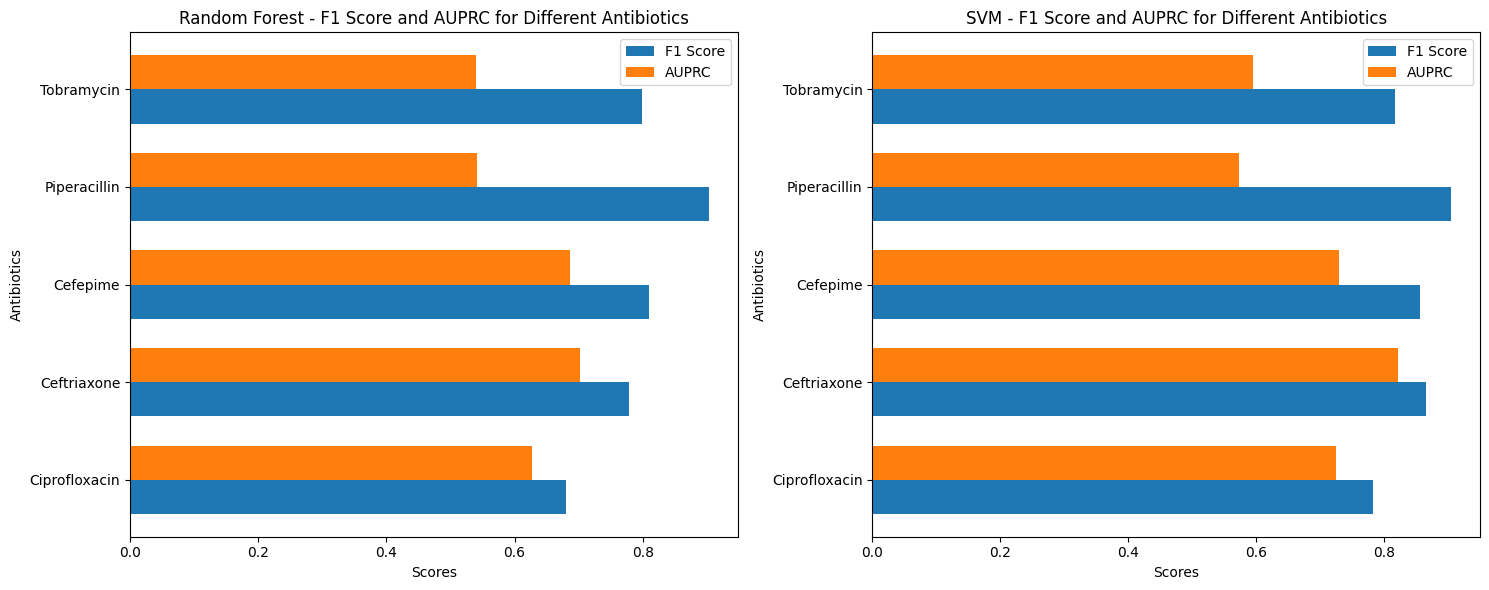

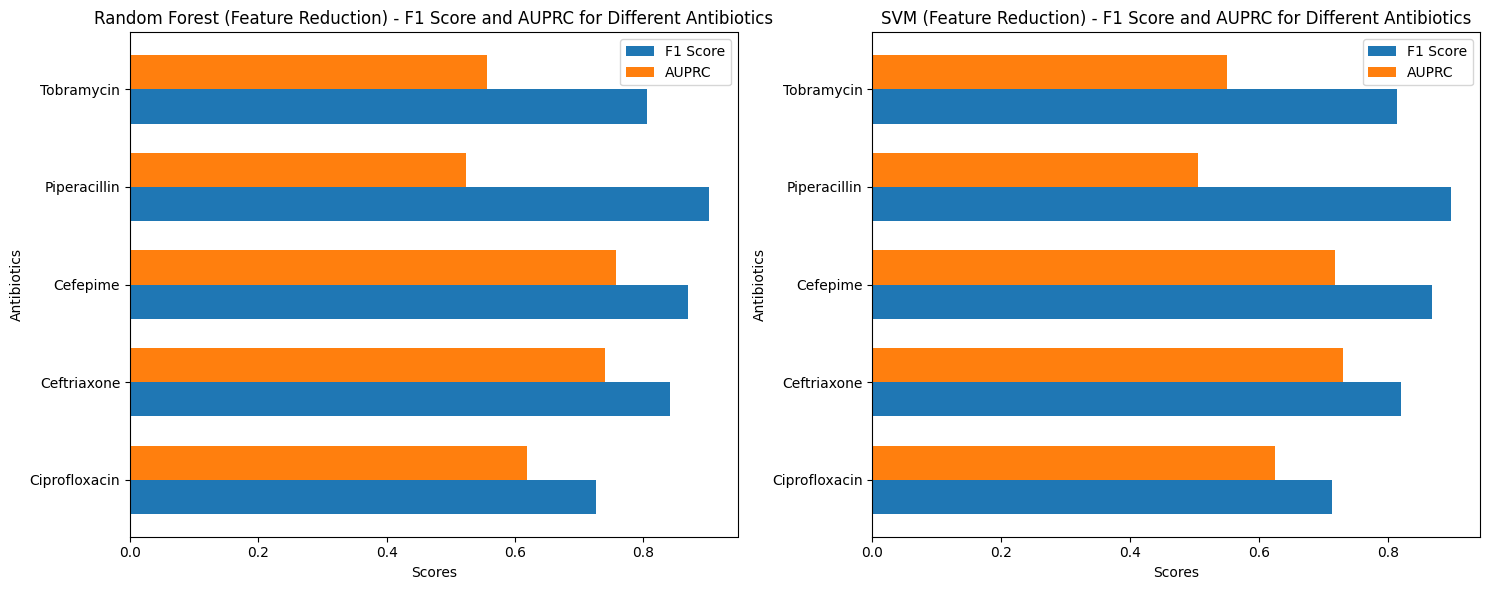

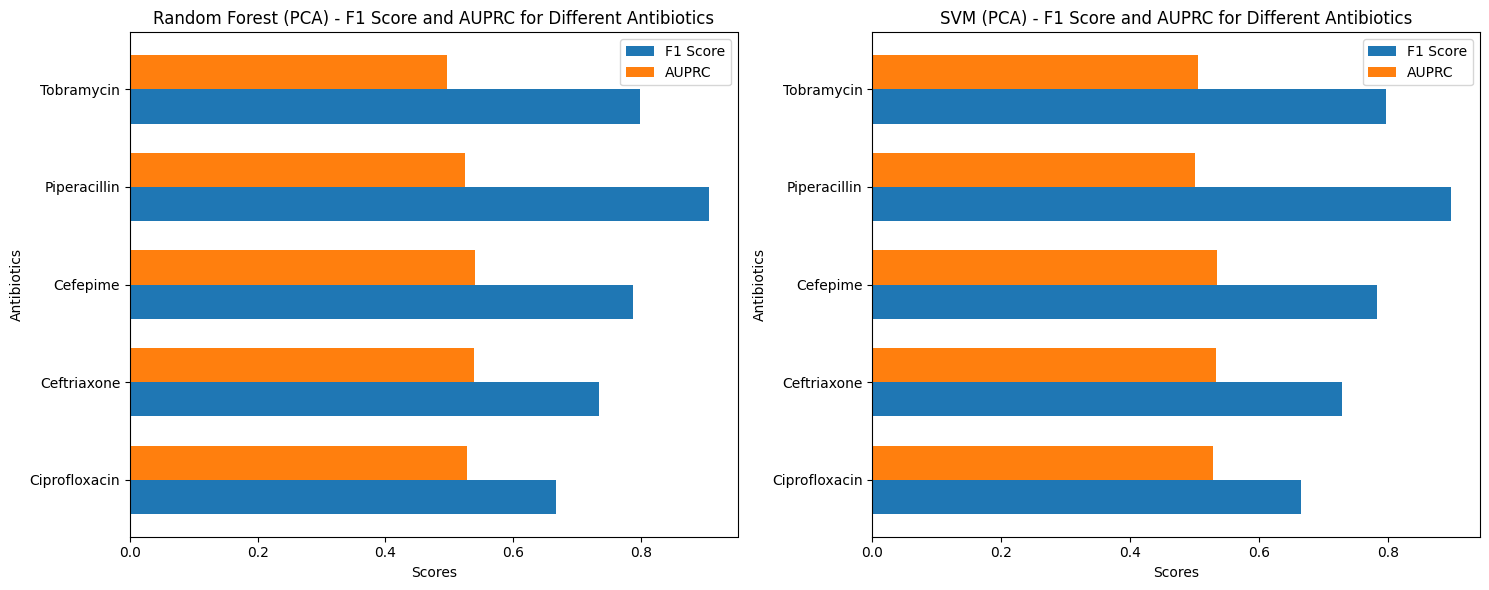

In [205]:
antibiotics = ['Ciprofloxacin', 'Ceftriaxone', 'Cefepime', 'Piperacillin', 'Tobramycin']
models = ['Random Forest', 'SVM', 'Random Forest (Feature Reduction)', 'SVM (Feature Reduction)', 'Random Forest (PCA)', 'SVM (PCA)']

f1_scores = {
    'Random Forest': [combined_results_ab_rf.loc['F1 Score (Weighted)', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics],
    'SVM': [combined_results_ab_svm.loc['F1 Score (Weighted)', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics],
    'Random Forest (Feature Reduction)': [combined_results_ab_rf_dr.loc['F1 Score (Weighted)', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics],
    'SVM (Feature Reduction)': [combined_results_ab_svm_dr.loc['F1 Score (Weighted)', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics],
    'Random Forest (PCA)': [combined_results_ab_rf_pca.loc['F1 Score (Weighted)', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics],
    'SVM (PCA)': [combined_results_ab_svm_pca.loc['F1 Score (Weighted)', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics]
}

auprc_scores = {
    'Random Forest': [combined_results_ab_rf.loc['AUPRC', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics],
    'SVM': [combined_results_ab_svm.loc['AUPRC', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics],
    'Random Forest (Feature Reduction)': [combined_results_ab_rf_dr.loc['AUPRC', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics],
    'SVM (Feature Reduction)': [combined_results_ab_svm_dr.loc['AUPRC', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics],
    'Random Forest (PCA)': [combined_results_ab_rf_pca.loc['AUPRC', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics],
    'SVM (PCA)': [combined_results_ab_svm_pca.loc['AUPRC', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics]
}

for i in range(0, len(models), 2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    index = np.arange(len(antibiotics))
    bar_width = 0.35

    model1 = models[i]
    model2 = models[i + 1]

    # Plot for first model
    axs[0].barh(index, f1_scores[model1], bar_width, label='F1 Score')
    axs[0].barh(index + bar_width, auprc_scores[model1], bar_width, label='AUPRC')
    axs[0].set_ylabel('Antibiotics')
    axs[0].set_xlabel('Scores')
    axs[0].set_title(f'{model1} - F1 Score and AUPRC for Different Antibiotics')
    axs[0].set_yticks(index + bar_width / 2)
    axs[0].set_yticklabels(antibiotics)
    axs[0].legend()

    # Plot for second model
    axs[1].barh(index, f1_scores[model2], bar_width, label='F1 Score')
    axs[1].barh(index + bar_width, auprc_scores[model2], bar_width, label='AUPRC')
    axs[1].set_ylabel('Antibiotics')
    axs[1].set_xlabel('Scores')
    axs[1].set_title(f'{model2} - F1 Score and AUPRC for Different Antibiotics')
    axs[1].set_yticks(index + bar_width / 2)
    axs[1].set_yticklabels(antibiotics)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

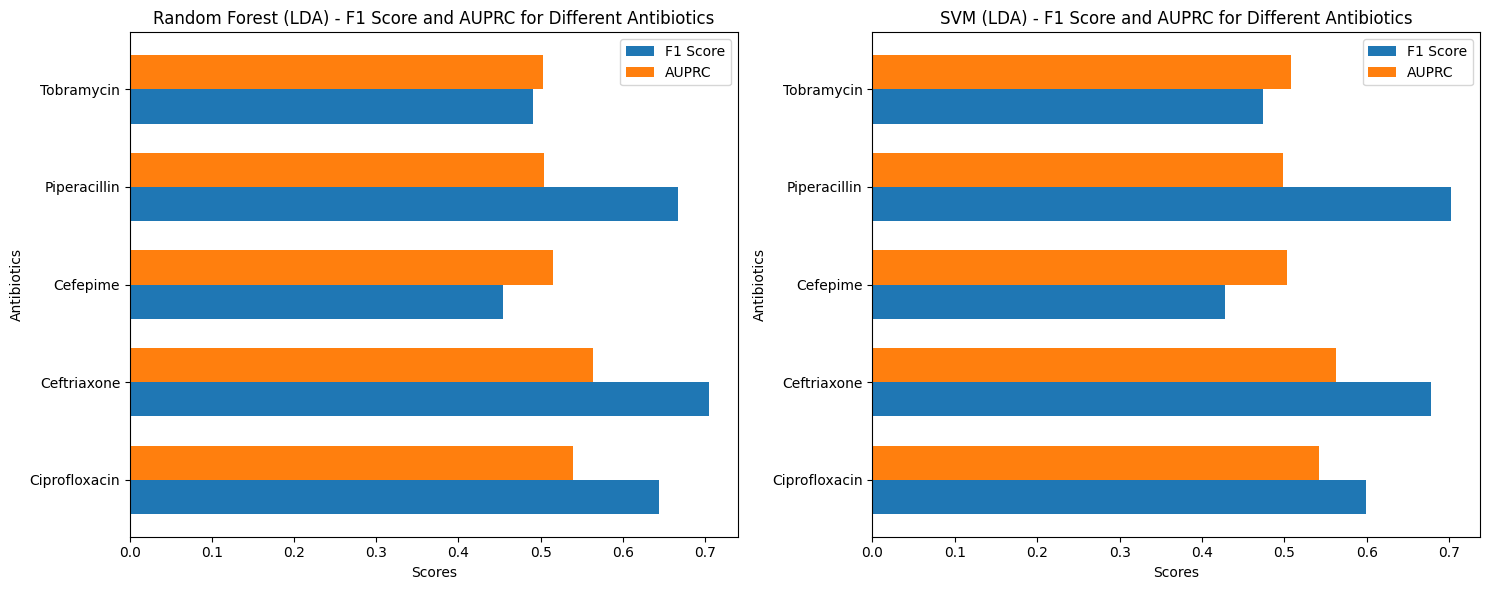

In [206]:
antibiotics = ['Ciprofloxacin', 'Ceftriaxone', 'Cefepime', 'Piperacillin', 'Tobramycin']
models = ['Random Forest (LDA)', 'SVM (LDA)']

f1_scores = {
    'Random Forest (LDA)': [combined_results_ab_rf_lda.loc['F1 Score (Weighted)', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics],
    'SVM (LDA)': [combined_results_ab_svm_lda.loc['F1 Score (Weighted)', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics]
}

auprc_scores = {
    'Random Forest (LDA)': [combined_results_ab_rf_lda.loc['AUPRC', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics],
    'SVM (LDA)': [combined_results_ab_svm_lda.loc['AUPRC', pd.IndexSlice[antibiotic, 'Test Score']] for antibiotic in antibiotics]
}

for i in range(0, len(models), 2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    index = np.arange(len(antibiotics))
    bar_width = 0.35

    model1 = models[i]
    model2 = models[i + 1]

    # Plot for first model
    axs[0].barh(index, f1_scores[model1], bar_width, label='F1 Score')
    axs[0].barh(index + bar_width, auprc_scores[model1], bar_width, label='AUPRC')
    axs[0].set_ylabel('Antibiotics')
    axs[0].set_xlabel('Scores')
    axs[0].set_title(f'{model1} - F1 Score and AUPRC for Different Antibiotics')
    axs[0].set_yticks(index + bar_width / 2)
    axs[0].set_yticklabels(antibiotics)
    axs[0].legend()

    # Plot for second model
    axs[1].barh(index, f1_scores[model2], bar_width, label='F1 Score')
    axs[1].barh(index + bar_width, auprc_scores[model2], bar_width, label='AUPRC')
    axs[1].set_ylabel('Antibiotics')
    axs[1].set_xlabel('Scores')
    axs[1].set_title(f'{model2} - F1 Score and AUPRC for Different Antibiotics')
    axs[1].set_yticks(index + bar_width / 2)
    axs[1].set_yticklabels(antibiotics)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Combined classifier (NN) for both fisrt and second task

In [15]:
# data
combined_df

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19991,19994,19997,split,y_species,Ciprofloxacin,Ceftriaxone,Cefepime,Piperacillin,Tobramycin
0,1544.142857,1501.000000,1500.000000,1542.285714,1485.571429,1664.428571,1676.750000,1743.428571,1537.285714,1426.000000,...,25.5,12.666667,14.384615,0,0,0.0,NaN,NaN,NaN,NaN
1,29.000000,44.571429,17.714286,71.142857,82.000000,24.285714,47.285714,26.857143,26.000000,18.571429,...,1.5,3.000000,7.784314,0,0,0.0,NaN,NaN,NaN,NaN
2,977.571429,957.125000,939.428571,849.142857,842.571429,881.142857,955.857143,986.000000,996.714286,980.625000,...,66.0,44.500000,56.221154,0,0,0.0,NaN,NaN,NaN,NaN
3,5051.857143,4213.250000,3658.428571,3348.428571,3295.000000,3922.714286,3748.714286,3903.000000,3698.000000,3876.714286,...,0.0,0.000000,0.028188,0,1,0.0,NaN,NaN,NaN,NaN
4,405.714286,385.375000,356.714286,419.000000,344.714286,383.428571,354.571429,370.428571,332.428571,319.142857,...,6.0,17.500000,7.676190,0,2,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43212,610.285714,546.714286,489.250000,422.857143,350.142857,476.428571,452.714286,458.714286,455.000000,511.875000,...,0.0,0.000000,0.001346,2,1,NaN,NaN,NaN,NaN,0.0
43213,578.428571,505.428571,548.571429,625.000000,548.250000,554.571429,551.428571,521.000000,630.571429,563.428571,...,0.0,0.000000,0.022667,2,0,NaN,NaN,NaN,NaN,0.0
43214,3082.571429,3350.125000,3681.142857,3558.000000,3108.857143,3611.857143,3183.571429,3406.571429,3542.285714,3309.750000,...,36.0,40.000000,37.096154,2,1,NaN,NaN,NaN,NaN,1.0
43215,1197.571429,1095.714286,1026.428571,886.571429,1066.857143,1131.875000,1008.428571,1143.714286,1043.714286,913.857143,...,11.5,9.333333,11.086538,2,0,NaN,NaN,NaN,NaN,0.0


In [10]:
features_comb = combined_df.iloc[:, :-7]
resistance_labels = combined_df.iloc[:, -5:]
species_labels = combined_df.iloc[:, -6]

In [131]:
resistance_labels[combined_df.split==0]

,Ciprofloxacin,Ceftriaxone,Cefepime,Piperacillin,Tobramycin
0,0.0,NaN,NaN,NaN,NaN
1,0.0,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN
3,0.0,NaN,NaN,NaN,NaN
4,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
40894,NaN,NaN,NaN,NaN,0.0
40895,NaN,NaN,NaN,NaN,0.0
40896,NaN,NaN,NaN,NaN,0.0
40897,NaN,NaN,NaN,NaN,0.0


In [12]:
X_train_features_nn = combined_df[combined_df.split==0].iloc[:, :-7]
X_valid_features_nn = combined_df[combined_df.split==1].iloc[:, :-7]
X_test_features_nn = combined_df[combined_df.split==2].iloc[:, :-7]

## Outliers detection

In [41]:
# Detection of the outliers using IsolationForest
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
outliers_iso_forest = iso_forest.fit_predict(X_train_features)

scores_iso_forest = iso_forest.decision_function(X_train_features)
sum(scores_iso_forest == -1)

0

In [44]:
# Detection of the outliers using IsolationForest
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
outliers_iso_forest = iso_forest.fit_predict(X_valid_features)

scores_iso_forest = iso_forest.decision_function(X_valid_features)
sum(scores_iso_forest == -1)

0

In [45]:
# Detection of the outliers using LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
outliers_lof = lof.fit_predict(X_train_features)
scores_lof = lof.negative_outlier_factor_
sum(scores_lof == -1)

0

In [46]:
# Detection of the outliers using LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
outliers_lof = lof.fit_predict(X_valid_features)
scores_lof = lof.negative_outlier_factor_
sum(scores_lof == -1)

0

## Normalization

In [13]:
scaler = StandardScaler()
X_train_features_scaled_nn = pd.DataFrame(scaler.fit_transform(X_train_features_nn), 
                                         columns=X_train_features_nn.columns, 
                                         index=X_train_features_nn.index)

X_valid_features_scaled_nn = pd.DataFrame(scaler.transform(X_valid_features_nn), 
                                         columns=X_valid_features_nn.columns, 
                                         index=X_valid_features_nn.index)

X_test_features_scaled_nn = pd.DataFrame(scaler.transform(X_test_features_nn), 
                                         columns=X_test_features_nn.columns, 
                                         index=X_test_features_nn.index)

In [31]:
X_train_features_scaled_nn.shape

(30248, 6000)

In [14]:
X_train_features_scaled_ar = np.array(X_train_features_scaled_nn) 
X_valid_features_scaled_ar = np.array(X_valid_features_scaled_nn) 
X_test_features_scaled_ar = np.array(X_test_features_scaled_nn) 

## Dataloaders

In [17]:
train_dataset = StackDataset(torch.tensor(X_train_features_scaled_ar).float(), 
                             torch.tensor(np.array(species_labels[combined_df.split==0])).long(), 
                             torch.tensor(np.array(resistance_labels[combined_df.split==0])).float())

valid_dataset = StackDataset(torch.tensor(X_valid_features_scaled_ar).float(), 
                             torch.tensor(np.array(species_labels[combined_df.split==1])).long(), 
                             torch.tensor(np.array(resistance_labels[combined_df.split==1])).float())

test_dataset = StackDataset(torch.tensor(X_test_features_scaled_ar).float(), 
                            torch.tensor(np.array(species_labels[combined_df.split==2])).long(), 
                            torch.tensor(np.array(resistance_labels[combined_df.split==2])).float())

#torch.save(train_dataset, './analysis/train_dataset.pt')
#torch.save(valid_dataset, './analysis/valid_dataset.pt')
#torch.save(test_dataset, './analysis/test_dataset.pt')

In [21]:
#torch.save(train_dataset, './analysis/train_dataset.pt')
#torch.save(valid_dataset, './analysis/valid_dataset.pt')
#torch.save(test_dataset, './analysis/test_dataset.pt')

## NN

the model is defined in ``model.py`` script

finetuning methods are located in ``funetuning.py``

Wandb is used for tracking the sweep. sweep is run by ``sweep.py``:

In [ ]:
from finetuning import start_sweep


sweep_config = {
        "method": "random",
        "metric": {
            "goal": "minimize",
            "name": "Validation/val_loss"
        },
        "parameters": {
            "n_hidden_layers": {"values": [1, 2, 3, 4]},
            "hidden_dim": {"values": [16, 32, 64, 128, 256, 512, 768, 1024]},
            "lr": {"values": [0.00001, 0.00003, 0.0001, 0.0003, 0.001]},
            "dr": {'values': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]},
            "accelerator": {"value": "cpu"},
            "max_epochs": {"value": 2},
            "train_dataset": {"value": './analysis/train_dataset.pt'},
            "valid_dataset": {"value": './analysis/valid_dataset.pt'},
            "test_dataset": {"value": './analysis/test_dataset.pt'},
            "save_preds": {"value": False},
        }
}

start_sweep(config=sweep_config, project_name='BDS_task_combined', num_config=100)

## Feature importance

### based on y_species

In [28]:
clf_comb = DecisionTreeClassifier(max_depth=128, random_state=42)
clf_comb.fit(X_train_features_scaled_nn, species_labels[combined_df.split==0])

DecisionTreeClassifier(max_depth=128, random_state=42)

In [29]:
y_valid_pred_comb = clf_comb.predict(X_valid_features_scaled_nn)
importances_comb = clf_comb.feature_importances_
clf_importance_comb_df = pd.DataFrame({'Feature': X_train_features_scaled_nn.columns, 'Importance': importances_comb})
clf_importance_comb_df = clf_importance_comb_df.sort_values(by='Importance', ascending=False)  

In [30]:
clf_importance_comb_df.head(15)

,Feature,Importance
1419,6257,0.353674
1914,7742,0.284028
1615,6845,0.276410
2354,9062,0.015435
1470,6410,0.013873
2584,9752,0.006533
1630,6890,0.006080
2492,9476,0.005876
1957,7871,0.004979
2495,9485,0.004290


In [31]:
threshold = 0.2
selected_features_nn = X_valid_features_scaled_nn.columns[importances_comb > threshold]

In [32]:
X_train_sc_comb_selected_fi = X_train_features_scaled_nn[selected_features_nn]
X_valid_sc_comb_selected_fi = X_valid_features_scaled_nn[selected_features_nn]
X_test_sc_comb_selected_fi = X_test_features_scaled_nn[selected_features_nn]

In [35]:
X_valid_sc_comb_selected_fi.shape

(6484, 3)

In [50]:
X_train_sc_comb_selected_fi_ar = np.array(X_train_sc_comb_selected_fi) 
X_valid_sc_comb_selected_fi_ar = np.array(X_valid_sc_comb_selected_fi) 
X_test_sc_comb_selected_fi_ar = np.array(X_test_sc_comb_selected_fi) 

In [51]:
train_dataset_fi = StackDataset(torch.tensor(X_train_sc_comb_selected_fi_ar).float(), 
                             torch.tensor(np.array(species_labels[combined_df.split==0])).long(), 
                             torch.tensor(np.array(resistance_labels[combined_df.split==0])).float())

valid_dataset_fi = StackDataset(torch.tensor(X_valid_sc_comb_selected_fi_ar).float(), 
                             torch.tensor(np.array(species_labels[combined_df.split==1])).long(), 
                             torch.tensor(np.array(resistance_labels[combined_df.split==1])).float())

test_dataset_fi = StackDataset(torch.tensor(X_test_sc_comb_selected_fi_ar).float(), 
                            torch.tensor(np.array(species_labels[combined_df.split==2])).long(), 
                            torch.tensor(np.array(resistance_labels[combined_df.split==2])).float())

torch.save(train_dataset_fi, './analysis/train_dataset_fi.pt')
torch.save(valid_dataset_fi, './analysis/valid_dataset_fi.pt')
torch.save(test_dataset_fi, './analysis/test_dataset_fi.pt')

### imputed NAs in y_resistance with -1

In [41]:
na_cols = resistance_labels[combined_df.split==0].columns[resistance_labels[combined_df.split==0].isna().any()].tolist()

In [53]:
resistance_labels_imp = resistance_labels.fillna(-1)

In [54]:
resistance_labels_imp

,Ciprofloxacin,Ceftriaxone,Cefepime,Piperacillin,Tobramycin
0,0.0,-1.0,-1.0,-1.0,-1.0
1,0.0,-1.0,-1.0,-1.0,-1.0
2,0.0,-1.0,-1.0,-1.0,-1.0
3,0.0,-1.0,-1.0,-1.0,-1.0
4,0.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...
43212,-1.0,-1.0,-1.0,-1.0,0.0
43213,-1.0,-1.0,-1.0,-1.0,0.0
43214,-1.0,-1.0,-1.0,-1.0,1.0
43215,-1.0,-1.0,-1.0,-1.0,0.0


In [56]:
from sklearn.multioutput import MultiOutputClassifier

In [58]:
y_train_combined = pd.concat([species_labels[combined_df.split==0], resistance_labels_imp[combined_df.split==0]], axis=1)

In [59]:
clf_comb_1 = DecisionTreeClassifier(max_depth=40, random_state=42)
multi_target_dt = MultiOutputClassifier(clf_comb_1, n_jobs=-1)
multi_target_dt.fit(X_train_features_scaled_nn, y_train_combined)

MultiOutputClassifier(estimator=DecisionTreeClassifier(max_depth=40,
                                                       random_state=42),
                      n_jobs=-1)

In [60]:
importances_mt_nn = np.array([est.feature_importances_ for est in multi_target_dt.estimators_])

mean_importances_mt_nn = np.mean(importances_mt_nn, axis=0)

# Create a DataFrame for better visualization
feature_importance_mt_nn_df = pd.DataFrame({
    'Feature': X_train_features_scaled_nn.columns,
    'Importance': mean_importances_mt_nn
}).sort_values(by='Importance', ascending=False)

In [61]:
feature_importance_mt_nn_df

,Feature,Importance
1615,6845,1.331869e-01
1419,6257,1.014642e-01
1914,7742,6.421932e-02
1630,6890,2.731042e-02
1417,6251,7.531853e-03
...,...,...
4504,15512,-2.553632e-19
5673,19019,-3.499750e-19
231,2693,-3.499750e-19
5718,19154,-3.499750e-19


## PCA

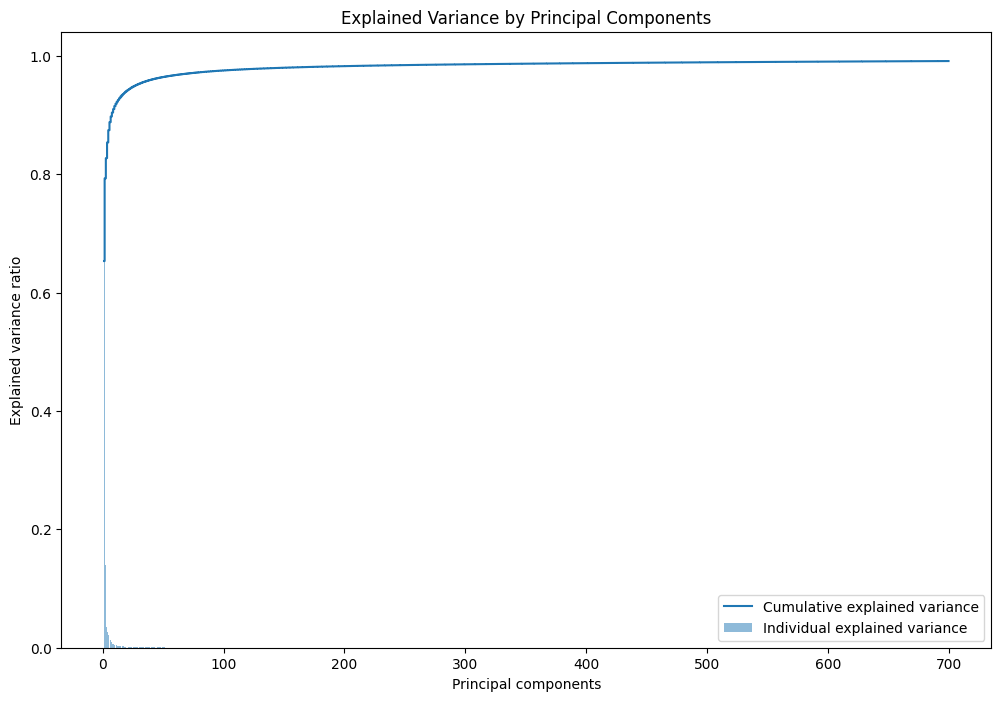

0.9909541112680964

In [20]:
n_components = 700

pca_nn1 = PCA(n_components=n_components)
X_train_pca_nn1 = pca_nn1.fit_transform(X_train_features_scaled_nn)
X_valid_pca_nn1 = pca_nn1.transform(X_valid_features_scaled_nn)

# Variance explained by each component
explained_variance_ratio_nn1 = pca_nn1.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance_nn1 = explained_variance_ratio_nn1.cumsum()

# Plotting the variance explained
plt.figure(figsize=(12, 8))
plt.bar(range(1, len(explained_variance_ratio_nn1) + 1), explained_variance_ratio_nn1, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance_nn1) + 1), cumulative_variance_nn1, where='mid', label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Explained Variance by Principal Components')
plt.show()

max_cumulative_variance = cumulative_variance_nn1.max()
max_cumulative_variance

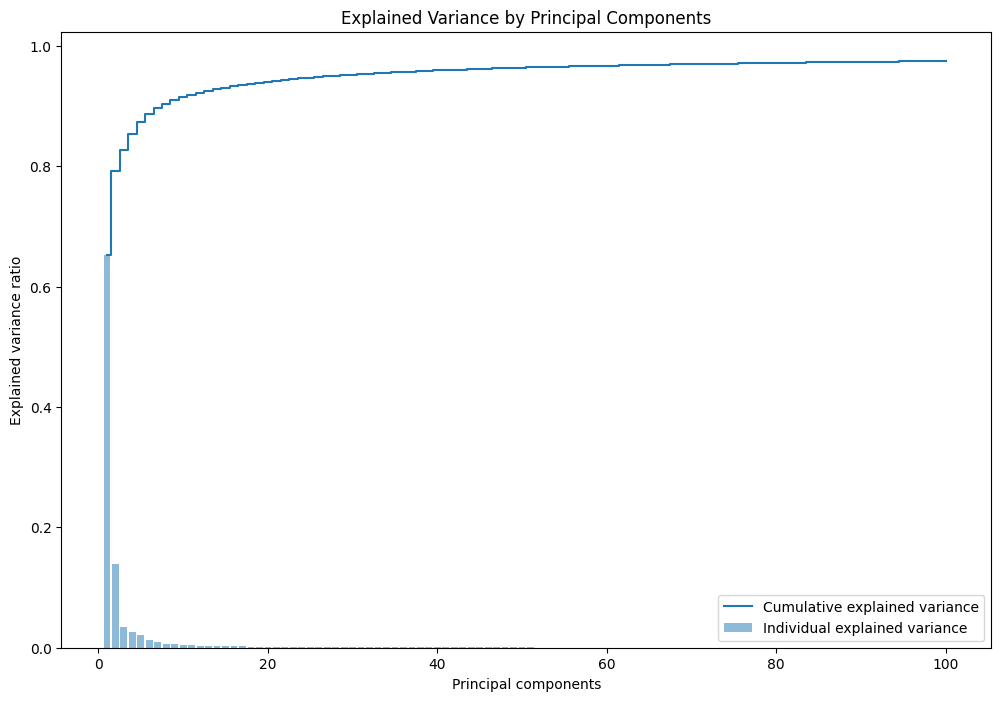

0.9750517517385223

In [16]:
n_components = 100

pca_nn1 = PCA(n_components=n_components)
X_train_pca_nn1 = pca_nn1.fit_transform(X_train_features_scaled_nn)
X_valid_pca_nn1 = pca_nn1.transform(X_valid_features_scaled_nn)

# Variance explained by each component
explained_variance_ratio_nn1 = pca_nn1.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance_nn1 = explained_variance_ratio_nn1.cumsum()

# Plotting the variance explained
plt.figure(figsize=(12, 8))
plt.bar(range(1, len(explained_variance_ratio_nn1) + 1), explained_variance_ratio_nn1, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance_nn1) + 1), cumulative_variance_nn1, where='mid', label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Explained Variance by Principal Components')
plt.show()

max_cumulative_variance = cumulative_variance_nn1.max()
max_cumulative_variance

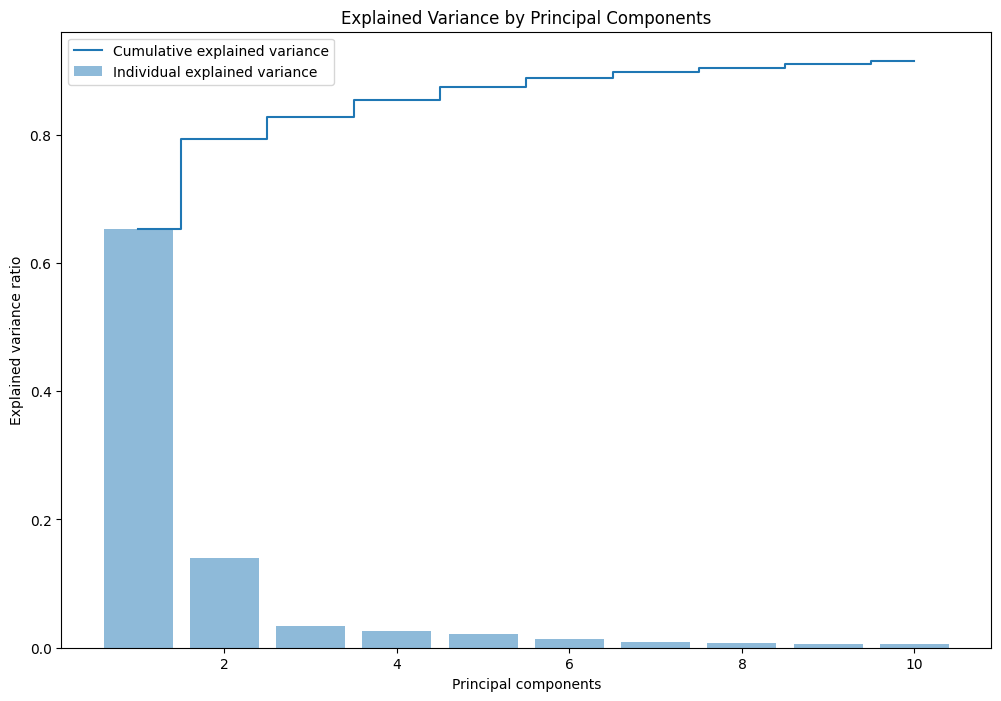

0.9148919042534218

In [20]:
n_components = 10

pca_nn1 = PCA(n_components=n_components)
X_train_pca_nn1 = pca_nn1.fit_transform(X_train_features_scaled_nn)
X_valid_pca_nn1 = pca_nn1.transform(X_valid_features_scaled_nn)

# Variance explained by each component
explained_variance_ratio_nn1 = pca_nn1.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance_nn1 = explained_variance_ratio_nn1.cumsum()

# Plotting the variance explained
plt.figure(figsize=(12, 8))
plt.bar(range(1, len(explained_variance_ratio_nn1) + 1), explained_variance_ratio_nn1, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance_nn1) + 1), cumulative_variance_nn1, where='mid', label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Explained Variance by Principal Components')
plt.show()

max_cumulative_variance = cumulative_variance_nn1.max()
max_cumulative_variance

### PCA with 91% of variance explained

In [36]:
pca_nn = PCA(n_components=10)  
X_train_nn_pca = pca_nn.fit_transform(X_train_features_scaled_nn)
X_valid_nn_pca = pca_nn.transform(X_valid_features_scaled_nn)
X_test_nn_pca = pca_nn.transform(X_test_features_scaled_nn)

In [37]:
X_train_nn_pca.shape

(30248, 10)

In [58]:
X_train_nn_pca_ar = np.array(X_train_nn_pca) 
X_valid_nn_pca_ar = np.array(X_valid_nn_pca) 
X_test_nn_pca_ar = np.array(X_test_nn_pca) 

train_dataset_pca = StackDataset(torch.tensor(X_train_nn_pca_ar).float(), 
                             torch.tensor(np.array(species_labels[combined_df.split==0])).long(), 
                             torch.tensor(np.array(resistance_labels[combined_df.split==0])).float())

valid_dataset_pca = StackDataset(torch.tensor(X_valid_nn_pca_ar).float(), 
                             torch.tensor(np.array(species_labels[combined_df.split==1])).long(), 
                             torch.tensor(np.array(resistance_labels[combined_df.split==1])).float())

test_dataset_pca = StackDataset(torch.tensor(X_test_nn_pca_ar).float(), 
                            torch.tensor(np.array(species_labels[combined_df.split==2])).long(), 
                            torch.tensor(np.array(resistance_labels[combined_df.split==2])).float())

torch.save(train_dataset_pca, './analysis/train_dataset_pca.pt')
torch.save(valid_dataset_pca, './analysis/valid_dataset_pca.pt')
torch.save(test_dataset_pca, './analysis/test_dataset_pca.pt')

### PCA with 99% of variance explained

In [21]:
pca_nn_700 = PCA(n_components=700)  
X_train_nn_pca_700 = pca_nn_700.fit_transform(X_train_features_scaled_nn)
X_valid_nn_pca_700 = pca_nn_700.transform(X_valid_features_scaled_nn)
X_test_nn_pca_700 = pca_nn_700.transform(X_test_features_scaled_nn)

In [22]:
X_train_nn_pca_700.shape

(30248, 700)

In [23]:
X_train_nn_pca_700_ar = np.array(X_train_nn_pca_700) 
X_valid_nn_pca_700_ar = np.array(X_valid_nn_pca_700) 
X_test_nn_pca_700_ar = np.array(X_test_nn_pca_700) 

In [26]:
train_dataset_pca_700 = StackDataset(torch.tensor(X_train_nn_pca_700_ar).float(), 
                             torch.tensor(np.array(species_labels[combined_df.split==0])).long(), 
                             torch.tensor(np.array(resistance_labels[combined_df.split==0])).float())

valid_dataset_pca_700 = StackDataset(torch.tensor(X_valid_nn_pca_700_ar).float(), 
                             torch.tensor(np.array(species_labels[combined_df.split==1])).long(), 
                             torch.tensor(np.array(resistance_labels[combined_df.split==1])).float())

test_dataset_pca_700 = StackDataset(torch.tensor(X_test_nn_pca_700_ar).float(), 
                            torch.tensor(np.array(species_labels[combined_df.split==2])).long(), 
                            torch.tensor(np.array(resistance_labels[combined_df.split==2])).float())

torch.save(train_dataset_pca_700, './analysis/train_dataset_pca_700.pt')
torch.save(valid_dataset_pca_700, './analysis/valid_dataset_pca_700.pt')
torch.save(test_dataset_pca_700, './analysis/test_dataset_pca_700.pt')

## LDA 

In [14]:
# Apply Linear Discriminant Analysis
lda_nn = LinearDiscriminantAnalysis(n_components=2)
X_train_comb_nn_lda = lda_nn.fit_transform(X_train_features_scaled_nn, species_labels[combined_df.split==0])
X_valid_comb_nn_lda = lda_nn.transform(X_valid_features_scaled_nn)
X_test_comb_nn_lda = lda_nn.transform(X_test_features_scaled_nn)

In [15]:
X_train_comb_nn_lda.shape

(30248, 2)

In [16]:
species_mapping = {0: 'Escherichia coli', 1: 'Klebsiella pneumoniae', 2: 'Staphylococcus aureus'}

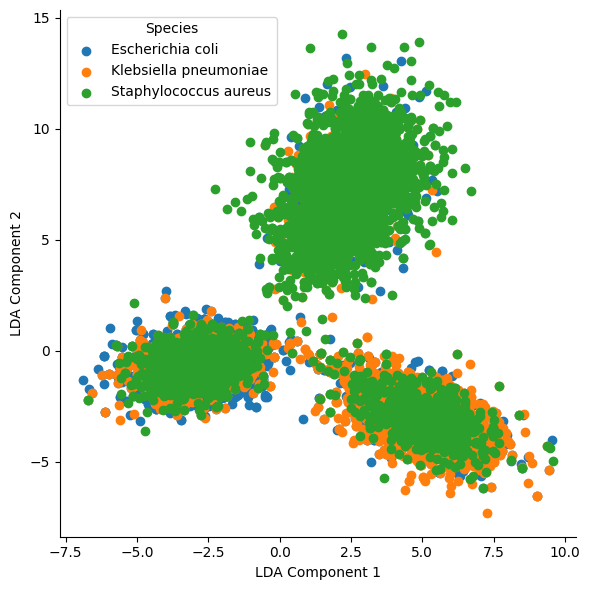

In [18]:
tmp_nn_df = pd.DataFrame(X_train_comb_nn_lda, columns=['LDA Component 1','LDA Component 2'])
tmp_nn_df['Class']=species_labels[combined_df.split==0]

# Create a custom legend using species_mapping
custom_legend = {key: value for key, value in species_mapping.items() if key in tmp_nn_df['Class'].unique()}

sns.FacetGrid(tmp_nn_df, hue ="Class", height = 6).map(plt.scatter, 'LDA Component 1', 'LDA Component 2')
plt.legend(custom_legend.values(), title='Species')
plt.show()

In [19]:
X_train_nn_lda_ar = np.array(X_train_comb_nn_lda) 
X_valid_nn_lda_ar = np.array(X_valid_comb_nn_lda) 
X_test_nn_lda_ar = np.array(X_test_comb_nn_lda) 

In [22]:
train_dataset_lda = StackDataset(torch.tensor(X_train_nn_lda_ar).float(), 
                             torch.tensor(np.array(species_labels[combined_df.split==0])).long(), 
                             torch.tensor(np.array(resistance_labels[combined_df.split==0])).float())

valid_dataset_lda = StackDataset(torch.tensor(X_valid_nn_lda_ar).float(), 
                             torch.tensor(np.array(species_labels[combined_df.split==1])).long(), 
                             torch.tensor(np.array(resistance_labels[combined_df.split==1])).float())

test_dataset_lda = StackDataset(torch.tensor(X_test_nn_lda_ar).float(), 
                            torch.tensor(np.array(species_labels[combined_df.split==2])).long(), 
                            torch.tensor(np.array(resistance_labels[combined_df.split==2])).float())

torch.save(train_dataset_lda, './analysis/train_dataset_lda.pt')
torch.save(valid_dataset_lda, './analysis/valid_dataset_lda.pt')
torch.save(test_dataset_lda, './analysis/test_dataset_lda.pt')

## autoencoder

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [117]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_features_scaled_ar, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid_features_scaled_ar, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_features_scaled_ar, dtype=torch.float32)

In [118]:
train_dataset = TensorDataset(X_train_tensor, X_train_tensor) 
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [119]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
input_dim = X_train_features_scaled_nn.shape[1]

# Number of dimensions to reduce to
encoding_dim = 100

autoencoder = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
with torch.no_grad():
    X_train_encoded = autoencoder.encoder(torch.tensor(X_train_features_scaled_ar, dtype=torch.float32)).numpy()
    X_valid_encoded = autoencoder.encoder(torch.tensor(X_valid_features_scaled_ar, dtype=torch.float32)).numpy()
    X_test_encoded = autoencoder.encoder(torch.tensor(X_test_features_scaled_ar, dtype=torch.float32)).numpy()

In [112]:
X_train_encoded.shape

(30248, 100)

In [ ]:
train_dataset_ae = StackDataset(torch.tensor(X_train_encoded).float(), 
                             torch.tensor(np.array(species_labels[combined_df.split==0])).long(), 
                             torch.tensor(np.array(resistance_labels[combined_df.split==0])).float())

valid_dataset_ae = StackDataset(torch.tensor(X_valid_encoded).float(), 
                             torch.tensor(np.array(species_labels[combined_df.split==1])).long(), 
                             torch.tensor(np.array(resistance_labels[combined_df.split==1])).float())

test_dataset_ae = StackDataset(torch.tensor(X_test_encoded).float(), 
                            torch.tensor(np.array(species_labels[combined_df.split==2])).long(), 
                            torch.tensor(np.array(resistance_labels[combined_df.split==2])).float())

torch.save(train_dataset_ae, './analysis/train_dataset_ae.pt')
torch.save(valid_dataset_ae, './analysis/valid_dataset_ae.pt')
torch.save(test_dataset_ae, './analysis/test_dataset_ae.pt')

In [143]:
class DeeperAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeeperAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, encoding_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

In [ ]:
input_dim = X_train_features_scaled_nn.shape[1]

# Number of dimensions to reduce to
encoding_dim = 100

autoencoder = DeeperAutoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Early stopping parameters
patience = 15
min_delta = 0.001
best_loss = -1
patience_counter = 0

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation loss
    autoencoder.eval()
    with torch.no_grad():
        val_outputs = autoencoder(X_valid_tensor)
        val_loss = criterion(val_outputs, X_valid_tensor).item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping 
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

In [146]:
with torch.no_grad():
    X_train_encoded_200 = autoencoder.encoder(torch.tensor(X_train_features_scaled_ar, dtype=torch.float32)).numpy()
    X_valid_encoded_200 = autoencoder.encoder(torch.tensor(X_valid_features_scaled_ar, dtype=torch.float32)).numpy()
    X_test_encoded_200 = autoencoder.encoder(torch.tensor(X_test_features_scaled_ar, dtype=torch.float32)).numpy()

In [147]:
train_dataset_ae_200 = StackDataset(torch.tensor(X_train_encoded_200).float(), 
                             torch.tensor(np.array(species_labels[combined_df.split==0])).long(), 
                             torch.tensor(np.array(resistance_labels[combined_df.split==0])).float())

valid_dataset_ae_200 = StackDataset(torch.tensor(X_valid_encoded_200).float(), 
                             torch.tensor(np.array(species_labels[combined_df.split==1])).long(), 
                             torch.tensor(np.array(resistance_labels[combined_df.split==1])).float())

test_dataset_ae_200 = StackDataset(torch.tensor(X_test_encoded_200).float(), 
                            torch.tensor(np.array(species_labels[combined_df.split==2])).long(), 
                            torch.tensor(np.array(resistance_labels[combined_df.split==2])).float())

torch.save(train_dataset_ae_200, './analysis/train_dataset_ae_200.pt')
torch.save(valid_dataset_ae_200, './analysis/valid_dataset_ae_200.pt')
torch.save(test_dataset_ae_200, './analysis/test_dataset_ae_200.pt')